In [1]:
import os
import json
import requests
import time
import sys
import shutil

import glob
import pickle
import torch
import safetensors.torch
import PIL
import numpy as np
import matplotlib.pyplot as plt





In [2]:


def ensure_folder_exists(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)  # 自動建立資料夾



In [2]:
prefixs = [ "LoRA_Trigger", "noLoRA_Trigger", "training"]


In [3]:
def rename_files():
    base_path = "..\\data\\input"
    for p in prefixs:
        folder_path = os.path.join(base_path, p)
        ensure_folder_exists(folder_path)
        counter = 0
        for file_name in os.listdir(folder_path):
            print(file_name)
            src = os.path.join(folder_path, file_name)
            dst = os.path.join(folder_path, p + "_" + str(counter) + ".png")
            os.rename(src, dst)
            counter += 1


In [ ]:
rename_files()

In [5]:
# read api from json file
api = {}
with open("anaysis with LoRA api.json", "r") as f:
    api = f.read()
api = json.loads(api)

trigger_prompt = " "
object_prompt = "a photo sks of chair in front of the TV"

In [6]:
class Config:
    def __init__(self, model, LoRA, input_image, trigger_prompt, object_prompt, file_prefix, total_steps, current_step):
        self.model = model
        self.LoRA = LoRA
        self.input_image = input_image
        self.trigger_prompt = trigger_prompt
        self.object_prompt = object_prompt
        self.short_object_prompt = object_prompt.split(",")[0].strip()[0:20]
        self.file_prefix = file_prefix
        self.total_steps = total_steps
        self.current_step = current_step

    def add_step(self):
        self.current_step += 1

    def set_input_image(self, input_image):
        self.input_image = input_image

config = Config(
    model="sd_xl_base_1.0.safetensors",
    LoRA="greenchair_webui.safetensors",
    input_image="input_image.png",
    trigger_prompt=trigger_prompt,
    object_prompt=object_prompt,
    file_prefix=prefixs,
    total_steps=20,
    current_step=0
)

In [7]:
print(config.short_object_prompt)

a photo sks of chair


In [8]:
import json
import requests
def send_request(api):
    # 3. 設定 API 的 URL 與 headers
    url = 'http://127.0.0.1:8188/prompt'
    headers = {'Content-Type': 'application/json'}

    # 4. 發送 POST request 並傳送修改後的 JSON 資料
    response = requests.post(url, headers=headers, data=json.dumps(api))

    # 5. 輸出回應結果
    print(response.status_code)
    print(response.json())

In [9]:


def modify_api(api, config, counter = 0):
    api["prompt"]["3"]["inputs"]["ckpt_name"] = config.model
    api["prompt"]["2"]["inputs"]["lora_name"] = config.LoRA
    api["prompt"]["7"]["inputs"]["image"] = config.input_image
    api["prompt"]["4"]["inputs"]["text"] = config.trigger_prompt + config.object_prompt
    api["prompt"]["11"]["inputs"]["filename_prefix"] = f"{config.file_prefix}/{config.short_object_prompt}/{config.input_image}/{config.current_step}"
    api["prompt"]["15"]["inputs"]["filename_prefix"] = f"{config.file_prefix}/{config.short_object_prompt}/{config.input_image}/{config.current_step}@{counter}@"
    api["prompt"]["10"]["inputs"]["steps"] = config.total_steps
    api["prompt"]["10"]["inputs"]["denoise"] =  1-config.current_step/ config.total_steps
    api["prompt"]["1"]["inputs"]["start_at_step"] = config.current_step
    api["prompt"]["1"]["inputs"]["end_at_step"] = config.current_step + 1
    return api

In [ ]:
import shutil
output_folder = "..\\..\\..\\myComfyUI\\output\\lab\\hspace"
for filename in os.listdir(output_folder):
    file_path = os.path.join(output_folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print(f'Failed to delete {file_path}. Reason: {e}')

In [ ]:
import shutil


generate_counter = 1

for prefix in prefixs:
    config.file_prefix = prefix
    # object_prompt = "a cute rat"
    # config.object_prompt = object_prompt
    for input_image in os.listdir(f"..\\..\\..\\myComfyUI\\input"):
        if prefix not in input_image:
            continue
        print(f"{prefix} {object_prompt} {input_image}")
        config.set_input_image(input_image)
        config.current_step = 0
        for i in range(20-1):
            config.current_step = i
            api = modify_api(api, config, generate_counter)
            generate_counter += 1
            send_request(api)
            print(f"{prefix} {object_prompt} {i} done")

In [10]:
hspace_folder = "..\\..\\..\\myComfyUI\\output\\lab\\hspace"
data_folder = "..\\data"


In [ ]:

for prefix in os.listdir(data_folder):
    for prompt in os.listdir(os.path.join(data_folder, prefix)):
        for image_name in os.listdir(os.path.join(data_folder, prefix, prompt)):
            for file_name in os.listdir(os.path.join(data_folder, prefix, prompt, image_name)):
                
                if '@' in file_name:
                    index = file_name.split('@')[1]
                    print(index)
                    hspace_file = os.path.join(hspace_folder, index+".pkl")
                    destination = os.path.join(data_folder, prefix, prompt, image_name)
                    # if hspace file exist
                    if os.path.exists(hspace_file):
                        shutil.move(hspace_file, destination)
                    else:
                        print(f"{hspace_file} not exist")




        


In [ ]:
class read_file():
    def __init__(self, file_path):
        pass

    def load_hspace_file(filepath):
        """讀取 .pkl 檔案，並將 numpy.ndarray 轉換為 numpy array"""
        with open(filepath, 'rb') as f:
            arr = pickle.load(f)
        return arr

    def load_latent_file(filepath):
        """利用 safetensors.torch 讀取 .latent 檔案，並取出 'latent_tensor'"""
        sd = safetensors.torch.load_file(filepath)
        return sd['latent_tensor'].numpy()

    def load_image_file(filepath):
        """讀取圖片檔案，並轉換為 numpy array"""
        img = PIL.Image.open(filepath)
        return np.array(img)


In [ ]:
experiment_data = {}
for prefix in os.listdir(data_folder):
    experiment_data[prefix] = {}
    for prompt in os.listdir(os.path.join(data_folder, prefix)):
        experiment_data[prefix][prompt] = {}
        for image_name in os.listdir(os.path.join(data_folder, prefix, prompt)):
            experiment_data[prefix][prompt][image_name] = {}
            experiment_data[prefix][prompt][image_name]["hspace"] = []
            experiment_data[prefix][prompt][image_name]["image"] = []
            experiment_data[prefix][prompt][image_name]["latent"] = []

            start_index = 9999999999
            for file_name in os.listdir(os.path.join(data_folder, prefix, prompt, image_name)):
                if '@' in file_name:
                    print(file_name)
                    index = int(file_name.split('@')[1])
                    start_index = min(start_index, index)
            
            
            for i in range(20-1):
                hspace_file = os.path.join(data_folder, prefix, prompt, image_name, f"{start_index+i}.pkl")
                image_file = os.path.join(data_folder, prefix, prompt, image_name, f"{i}@{start_index+i}@_00001_.png")
                latent_file = os.path.join(data_folder, prefix, prompt, image_name, f"{i}_00001_.latent")

                if os.path.exists(hspace_file) and os.path.exists(image_file) and os.path.exists(latent_file):
                    experiment_data[prefix][prompt][image_name]["hspace"].append(read_file.load_hspace_file(hspace_file))
                    experiment_data[prefix][prompt][image_name]["image"].append(read_file.load_image_file(image_file))
                    experiment_data[prefix][prompt][image_name]["latent"].append(read_file.load_latent_file(latent_file))
                else:
                    if not os.path.exists(hspace_file):
                        print(f"{hspace_file} not exist")
                    if not os.path.exists(image_file):
                        print(f"{image_file} not exist")
                    if not os.path.exists(latent_file):
                        print(f"{latent_file} not exist")




In [ ]:
# turn experiment_data into numpy array
for prefix in experiment_data:
    for prompt in experiment_data[prefix]:
        for image_name in experiment_data[prefix][prompt]:
            experiment_data[prefix][prompt][image_name]["hspace"] = np.array(experiment_data[prefix][prompt][image_name]["hspace"])
            experiment_data[prefix][prompt][image_name]["image"] = np.array(experiment_data[prefix][prompt][image_name]["image"])
            experiment_data[prefix][prompt][image_name]["latent"] = np.array(experiment_data[prefix][prompt][image_name]["latent"])

In [ ]:
print(experiment_data.keys())
print(experiment_data['noLoRA_Trigger'].keys())
print(experiment_data['noLoRA_Trigger'][config.short_object_prompt].keys())
print(experiment_data['noLoRA_Trigger'][config.short_object_prompt]['noLoRA_Trigger_0.png'].keys())
print(len(experiment_data['noLoRA_Trigger'][config.short_object_prompt]['noLoRA_Trigger_0.png']['hspace']))
print(len(experiment_data['noLoRA_Trigger'][config.short_object_prompt]['noLoRA_Trigger_0.png']['image']))
print(len(experiment_data['noLoRA_Trigger'][config.short_object_prompt]['noLoRA_Trigger_0.png']['latent']))

In [ ]:
# save experiment data
with open('experiment_data.pkl', 'wb') as f:
    pickle.dump(experiment_data, f)

In [11]:
# load experiment data
experiment_data = {}
with open('experiment_data.pkl', 'rb') as f:
    experiment_data = pickle.load(f)
    

In [ ]:
# replace last image data with random data
for prefix in experiment_data:
    for prompt in experiment_data[prefix]:
        last_image_name = list(experiment_data[prefix][prompt].keys())[-1]
        print(experiment_data[prefix][prompt][last_image_name]["image"].shape)
        print(experiment_data[prefix][prompt][last_image_name]["latent"].shape)
        print(experiment_data[prefix][prompt][last_image_name]["hspace"].shape)
        print("*"*10)
        # as random data
        experiment_data[prefix][prompt][last_image_name]["image"] = np.random.rand(19, 512, 512, 3)
        experiment_data[prefix][prompt][last_image_name]["latent"] = np.random.rand(19, 1, 4, 64, 64)
        experiment_data[prefix][prompt][last_image_name]["hspace"] = np.random.rand(19, 2, 1280, 8, 8)

        second_last_image_name = list(experiment_data[prefix][prompt].keys())[-2]
        # as zero data
        experiment_data[prefix][prompt][second_last_image_name]["image"] = np.zeros((19, 512, 512, 3))
        experiment_data[prefix][prompt][second_last_image_name]["latent"] = np.zeros((19, 1, 4, 64, 64))
        experiment_data[prefix][prompt][second_last_image_name]["hspace"] = np.zeros((19, 2, 1280, 8, 8))


In [12]:
def normalize_experiment_data(experiment_data):
    normalized_data = {}
    for prefix in experiment_data.keys():
        normalized_data[prefix] = {}
        for prompt in experiment_data[prefix].keys():
            normalized_data[prefix][prompt] = {}
            for image_name in experiment_data[prefix][prompt].keys():
                normalized_data[prefix][prompt][image_name] = {}
                for key in ["latent", "image", "hspace"]:
                    data = experiment_data[prefix][prompt][image_name][key]
                    min_val = np.min(data)
                    max_val = np.max(data)
                    normalized_data[prefix][prompt][image_name][key] = (data - min_val) / (max_val - min_val) if max_val != min_val else data
    return normalized_data

experiment_data = normalize_experiment_data(experiment_data)


In [ ]:
print(experiment_data.keys())
print(experiment_data['LoRA_noTrigger'].keys())
print(experiment_data['LoRA_noTrigger'][config.short_object_prompt].keys())
print(experiment_data['LoRA_noTrigger'][config.short_object_prompt]['LoRA_noTrigger_0.png'].keys())
print(len(experiment_data['LoRA_noTrigger'][config.short_object_prompt]['LoRA_noTrigger_0.png']['hspace']))
print(len(experiment_data['LoRA_noTrigger'][config.short_object_prompt]['LoRA_noTrigger_0.png']['image']))
print(len(experiment_data['LoRA_noTrigger'][config.short_object_prompt]['LoRA_noTrigger_0.png']['latent']))

In [13]:
import numpy as np

def euclidean(p1, p2):
    p1, p2 = np.array(p1), np.array(p2)
    if np.any(np.isnan(p1)) or np.any(np.isnan(p2)) or np.any(np.isinf(p1)) or np.any(np.isinf(p2)):
        print("Invalid input detected:", p1, p2)
        return float('inf')
    return np.linalg.norm(p1 - p2)


def frechet_recursive(ca, P, Q, i, j):
    if ca[i, j] > -1:
        return ca[i, j]
    elif i == 0 and j == 0:
        ca[i, j] = euclidean(P[0], Q[0])
    elif i > 0 and j == 0:
        ca[i, j] = max(frechet_recursive(ca, P, Q, i-1, 0), euclidean(P[i], Q[0]))
    elif i == 0 and j > 0:
        ca[i, j] = max(frechet_recursive(ca, P, Q, 0, j-1), euclidean(P[0], Q[j]))
    elif i > 0 and j > 0:
        ca[i, j] = max(min(frechet_recursive(ca, P, Q, i-1, j),
                           frechet_recursive(ca, P, Q, i-1, j-1),
                           frechet_recursive(ca, P, Q, i, j-1)),
                       euclidean(P[i], Q[j]))
    else:
        ca[i, j] = float('inf')
    return ca[i, j]

def frechet_distance(P, Q):
    ca = np.ones((len(P), len(Q))) * -1
    return frechet_recursive(ca, P, Q, len(P)-1, len(Q)-1)




In [14]:
# see as different step

# calculate the L2 distance of latent, image, hspace between each image and the first image
# also calculate the L1 distance of hspace between each image and the first image

def calculate_euclidean_distance(experiment_data):
    anaysis_data = {}
    for prefix in experiment_data.keys():
        anaysis_data[prefix] = {}
        for prompt in experiment_data[prefix].keys():
            anaysis_data[prefix][prompt] = {}
            for image_name in experiment_data[prefix][prompt].keys():
                anaysis_data[prefix][prompt][image_name] = {"latent": [], "image": [], "hspace": []}
                avg_data = {"latent": None, "image": None, "hspace": None}

                # Calculate the average for each key
                for key in ["hspace", "latent", "image"]:
                    all_steps = [
                        experiment_data[prefix][prompt][img_name][key]
                        for img_name in experiment_data[prefix][prompt].keys()
                        if experiment_data[prefix][prompt][img_name][key].shape == experiment_data[prefix][prompt][image_name][key].shape
                    ]
                    if all_steps:
                        avg_data[key] = np.mean(np.array(all_steps), axis=0)+0.000001
                    else:
                        avg_data[key] = None


                # Calculate the Euclidean distance from the average
                for key in ["latent", "image", "hspace"]:
                    if avg_data[key] is not None:
                        for i in range(0, 20 - 1):

                            distance = euclidean(
                                experiment_data[prefix][prompt][image_name][key][i],
                                avg_data[key][i]
                            )
                            anaysis_data[prefix][prompt][image_name][key].append(distance)

    return anaysis_data
anaysis_data = {"L2_step": {}, "frechet_step": {}, "L1_step": {}}
anaysis_data["L2_step"] = calculate_euclidean_distance(experiment_data)

In [14]:
print(anaysis_data["L2_step"].keys())
print(anaysis_data["L2_step"]['LoRA_noTrigger'].keys())
print(anaysis_data["L2_step"]['LoRA_noTrigger'][config.short_object_prompt].keys())
print(anaysis_data["L2_step"]['LoRA_noTrigger'][config.short_object_prompt]['LoRA_noTrigger_1.png'].keys())
print(len(anaysis_data["L2_step"]['LoRA_noTrigger'][config.short_object_prompt]['LoRA_noTrigger_1.png']['hspace']))
print(len(anaysis_data["L2_step"]['LoRA_noTrigger'][config.short_object_prompt]['LoRA_noTrigger_1.png']['image']))
print(len(anaysis_data["L2_step"]['LoRA_noTrigger'][config.short_object_prompt]['LoRA_noTrigger_1.png']['latent']))



dict_keys(['LoRA_Trigger', 'noLoRA_Trigger', 'training'])


KeyError: 'LoRA_noTrigger'

In [ ]:
# anaysis_data["L2_step"]['LoRA_noTrigger'][config.short_object_prompt]['LoRA_noTrigger_1.png']['latent']
anaysis_data["L2_step"]['LoRA_noTrigger'][config.short_object_prompt]['LoRA_noTrigger_1.png']['hspace']

Processing prefix: LoRA_Trigger
Number of boxes: 32, Number of labels: 32


C:\Users\user\AppData\Local\Temp\ipykernel_15632\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


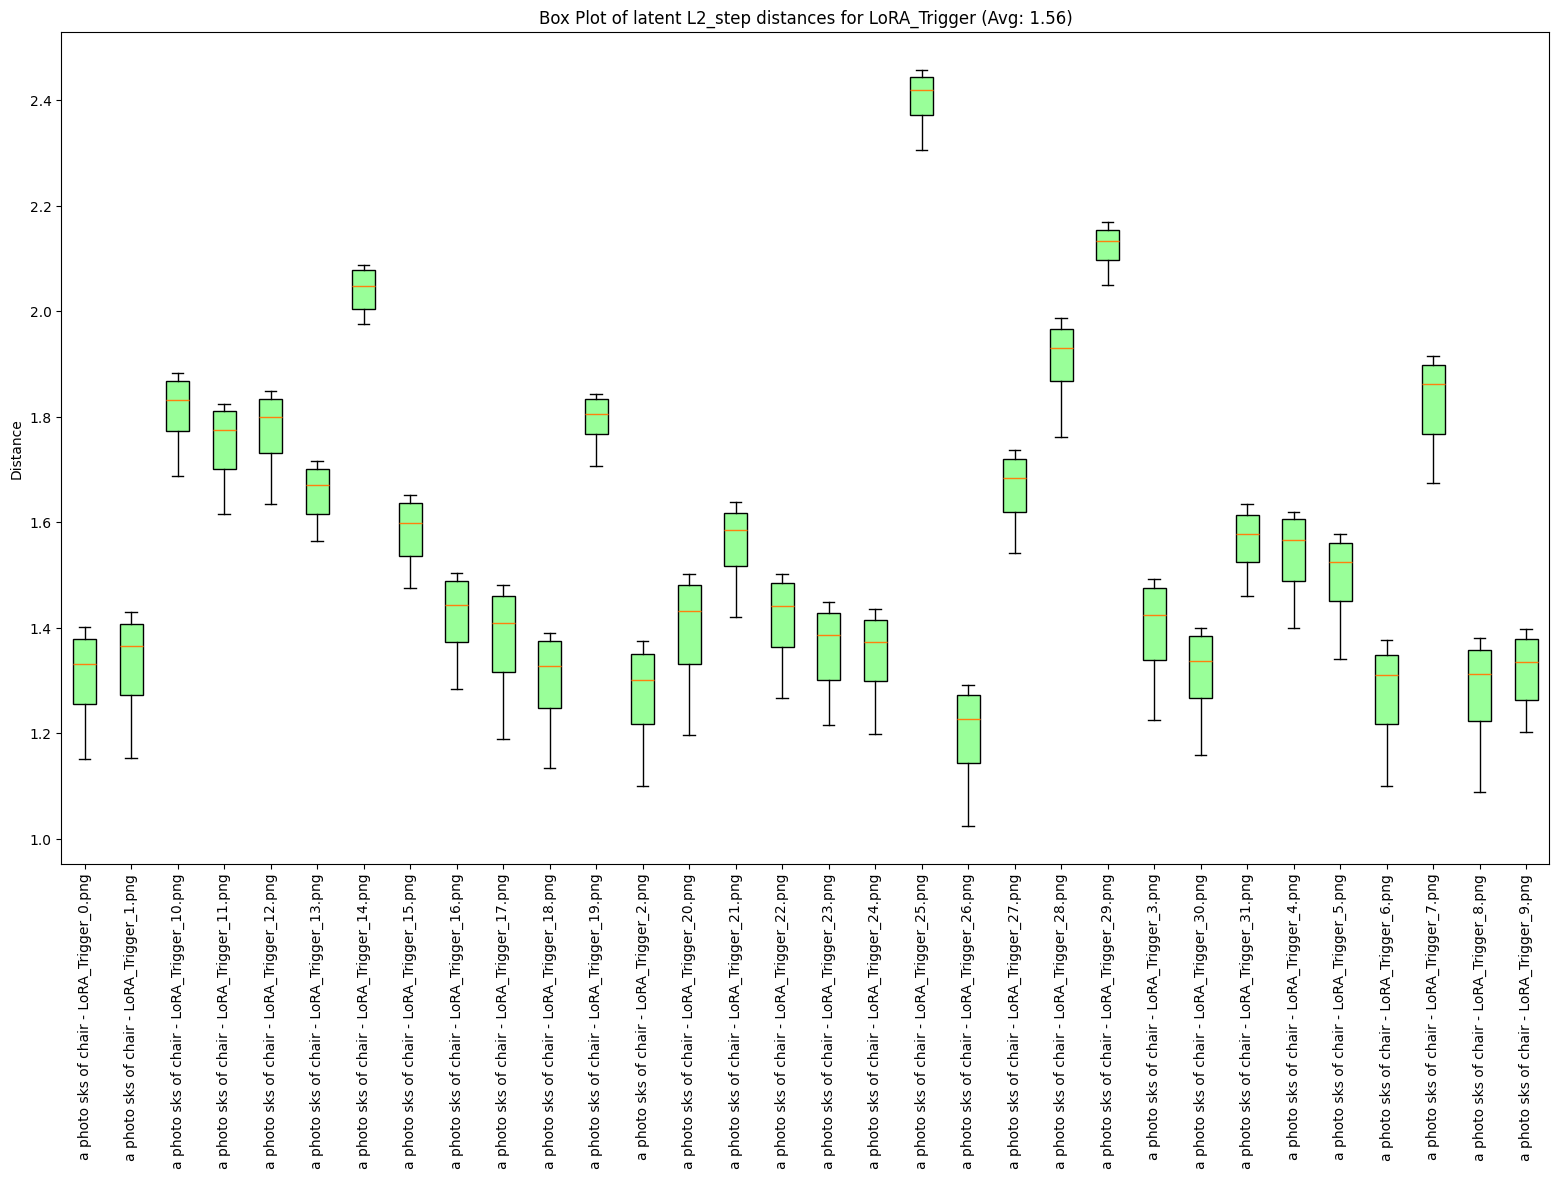

Processing prefix: noLoRA_Trigger
Number of boxes: 32, Number of labels: 32


C:\Users\user\AppData\Local\Temp\ipykernel_15632\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


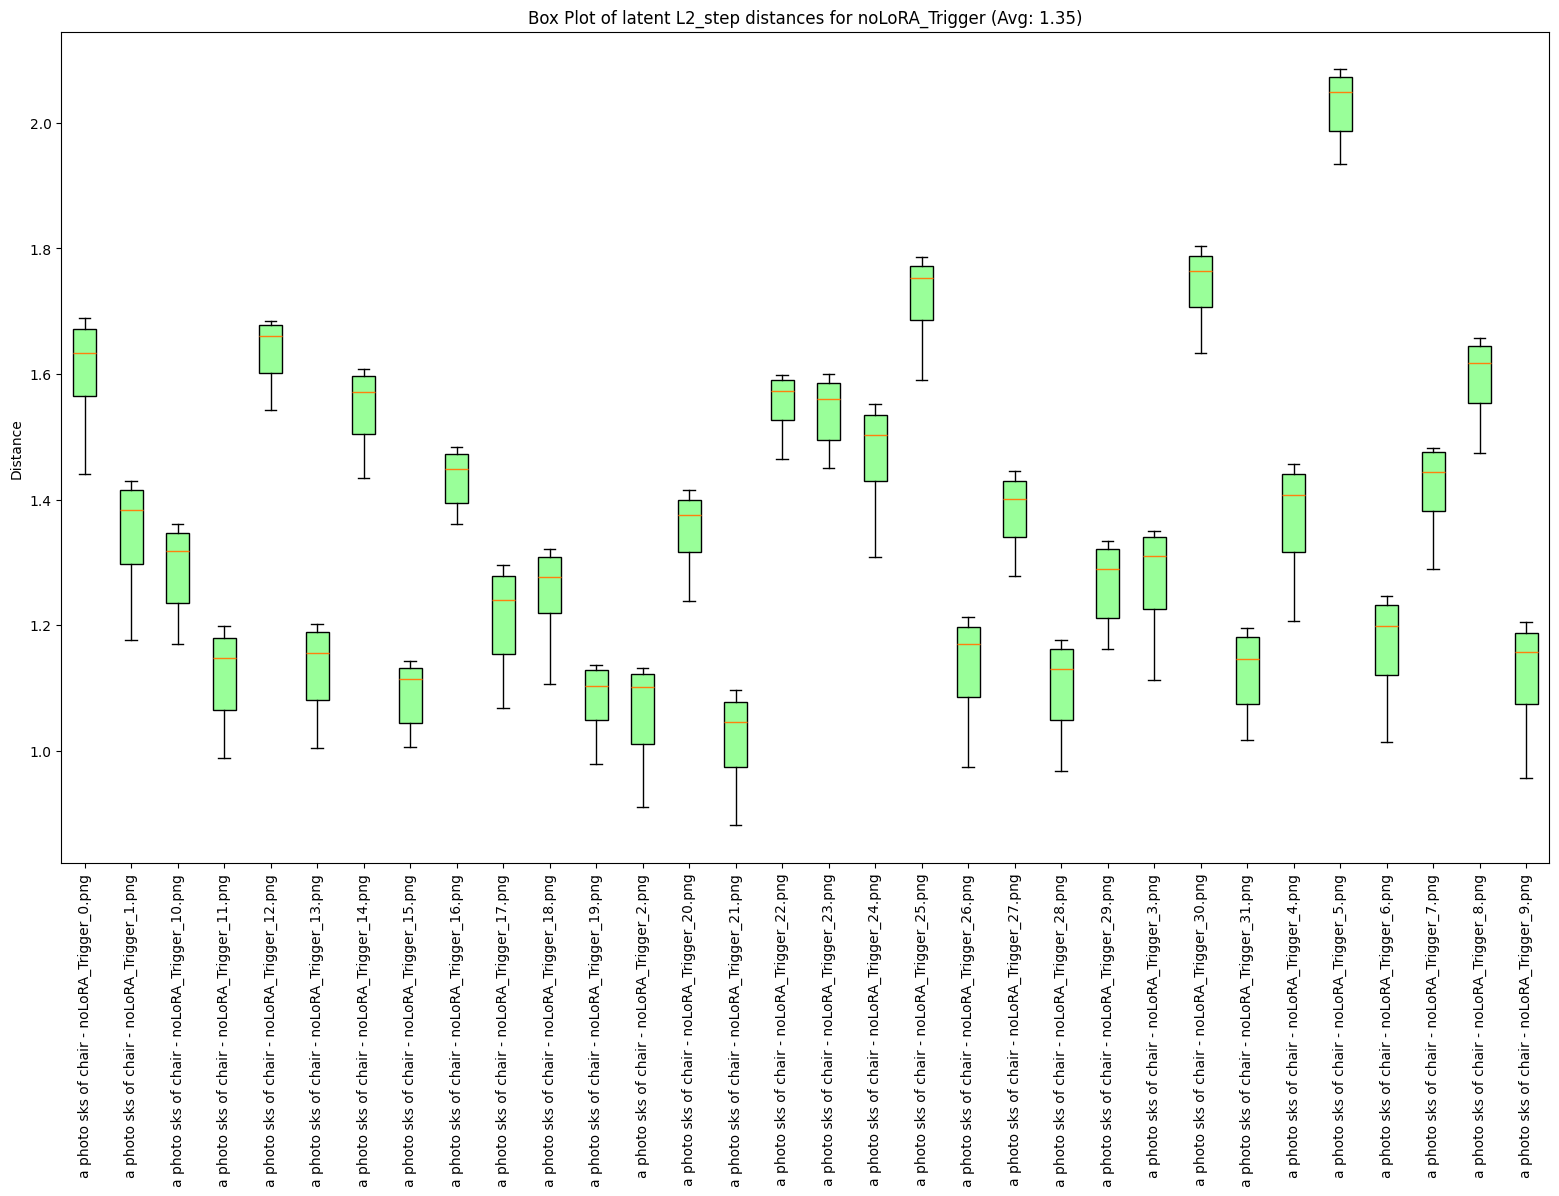

Processing prefix: training
Number of boxes: 25, Number of labels: 25


C:\Users\user\AppData\Local\Temp\ipykernel_15632\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


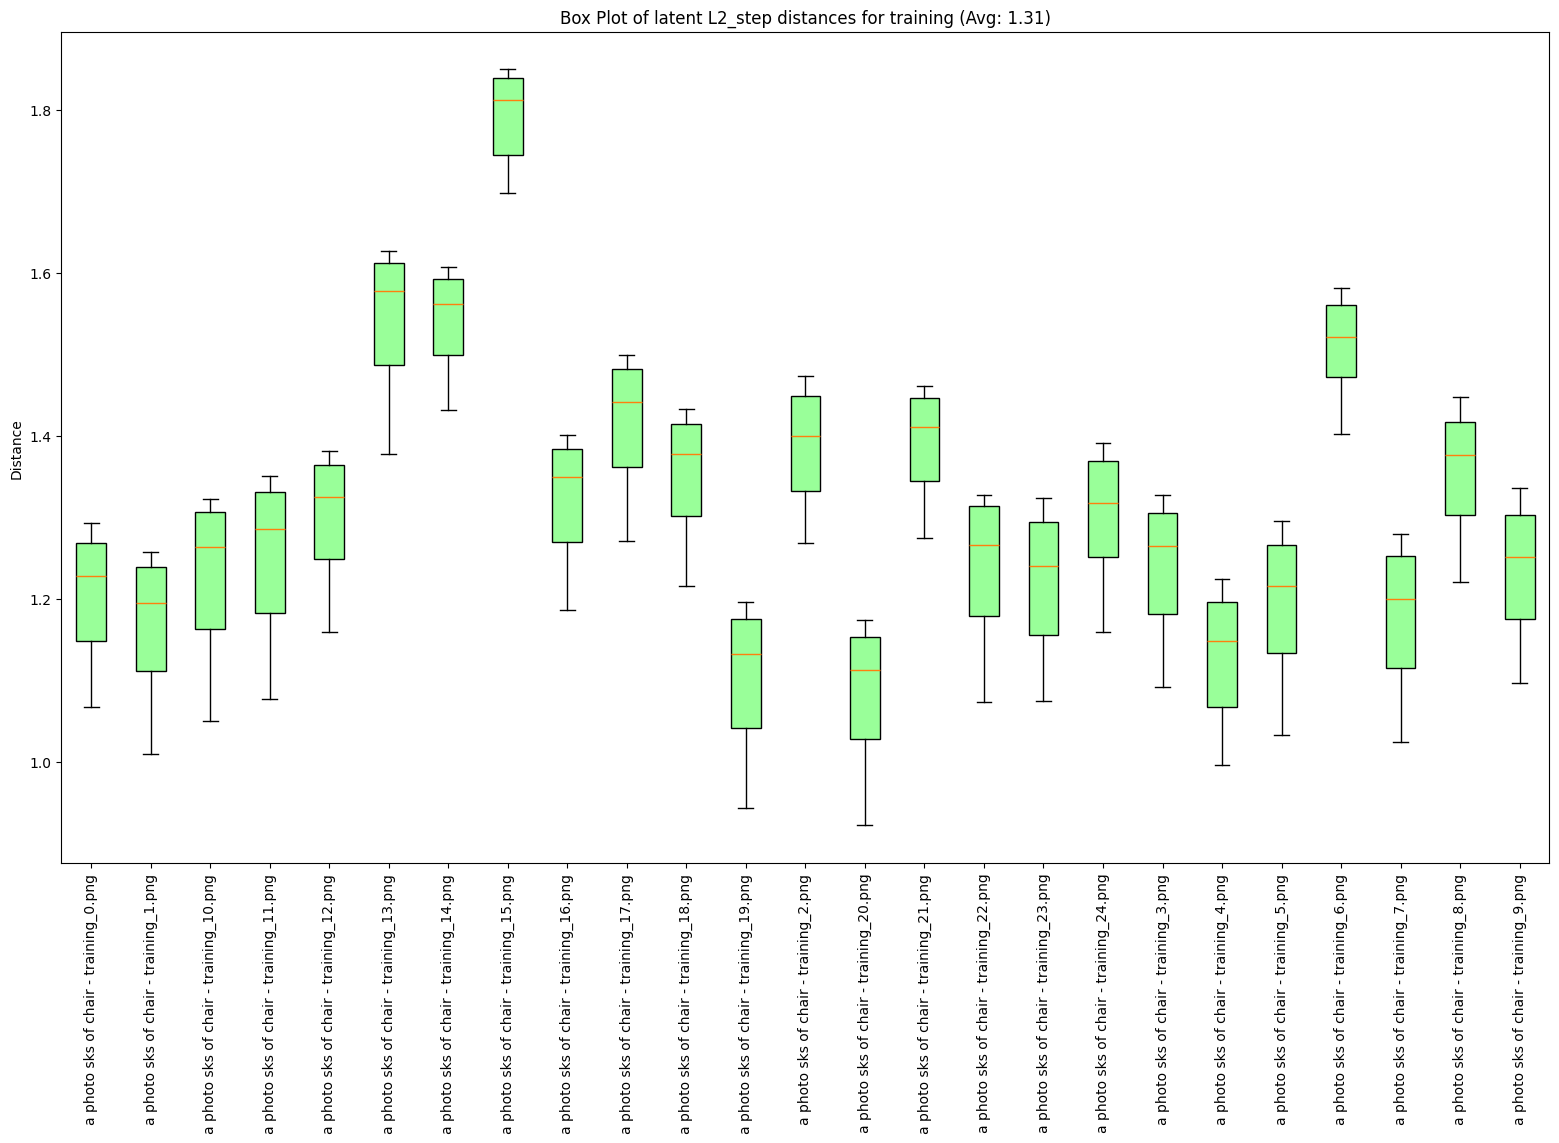

C:\Users\user\AppData\Local\Temp\ipykernel_15632\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


Processing prefix: LoRA_Trigger
Number of boxes: 32, Number of labels: 32


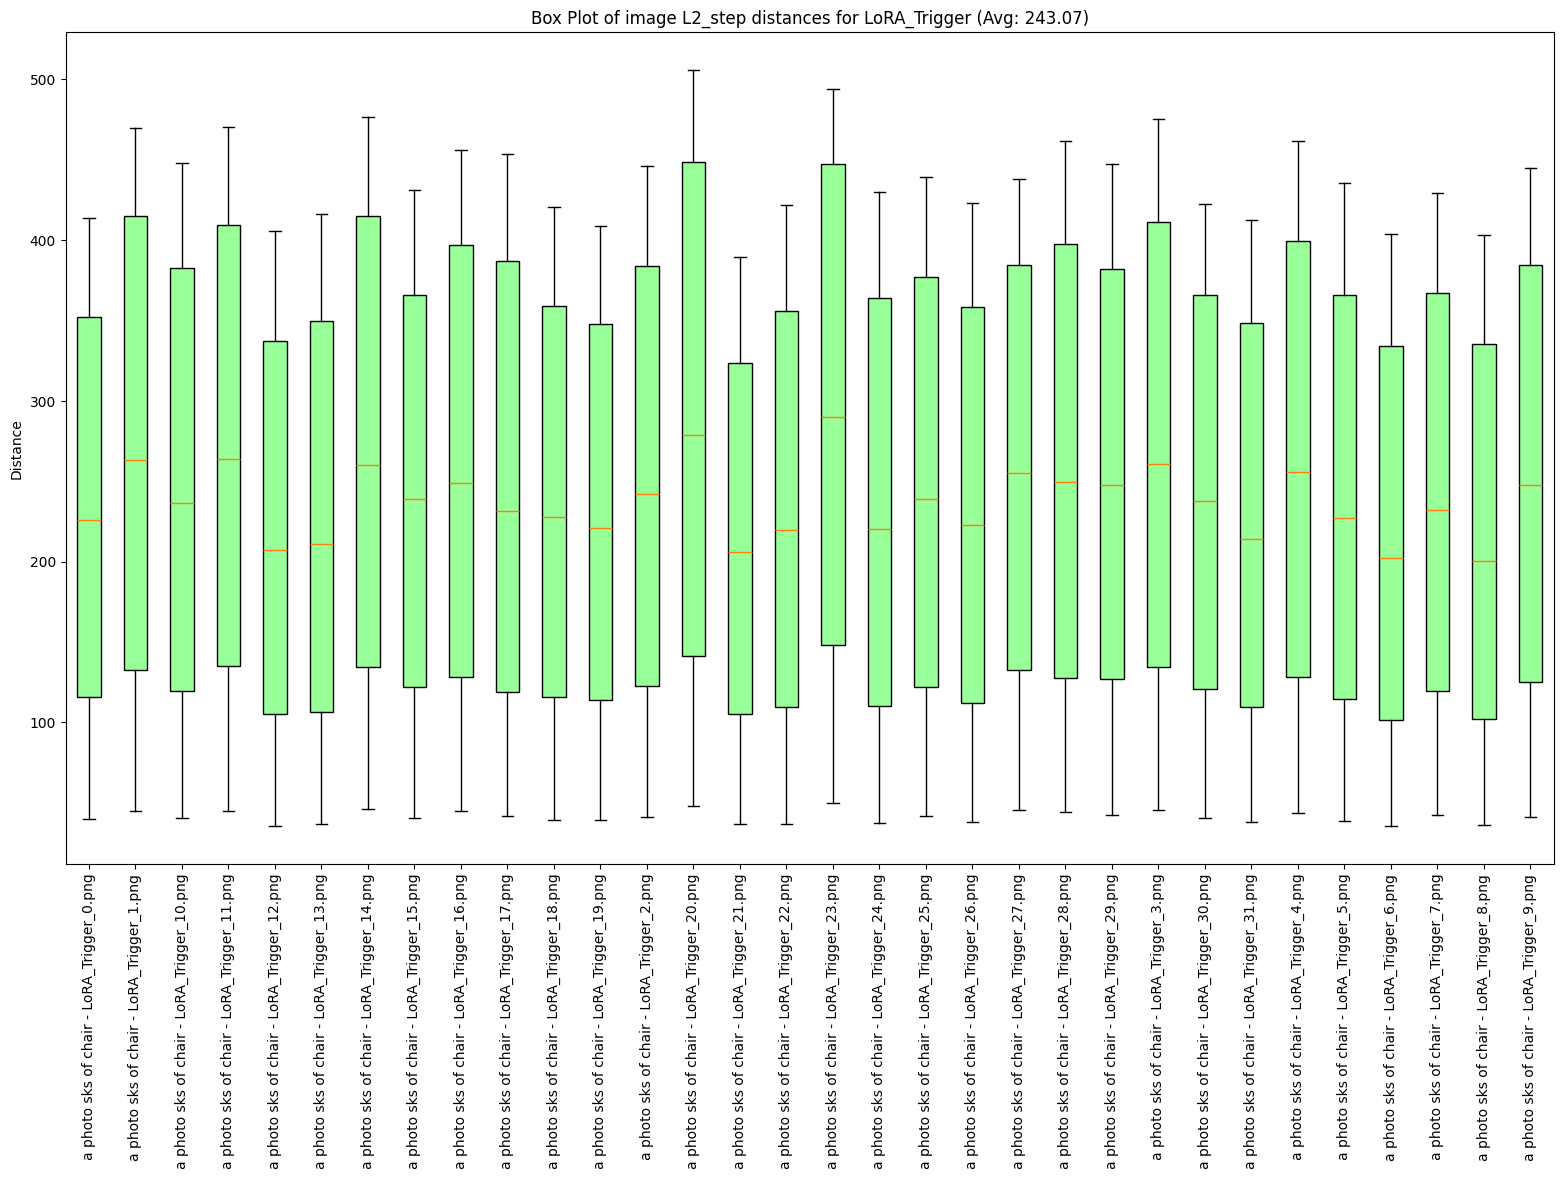

Processing prefix: noLoRA_Trigger
Number of boxes: 32, Number of labels: 32


C:\Users\user\AppData\Local\Temp\ipykernel_15632\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


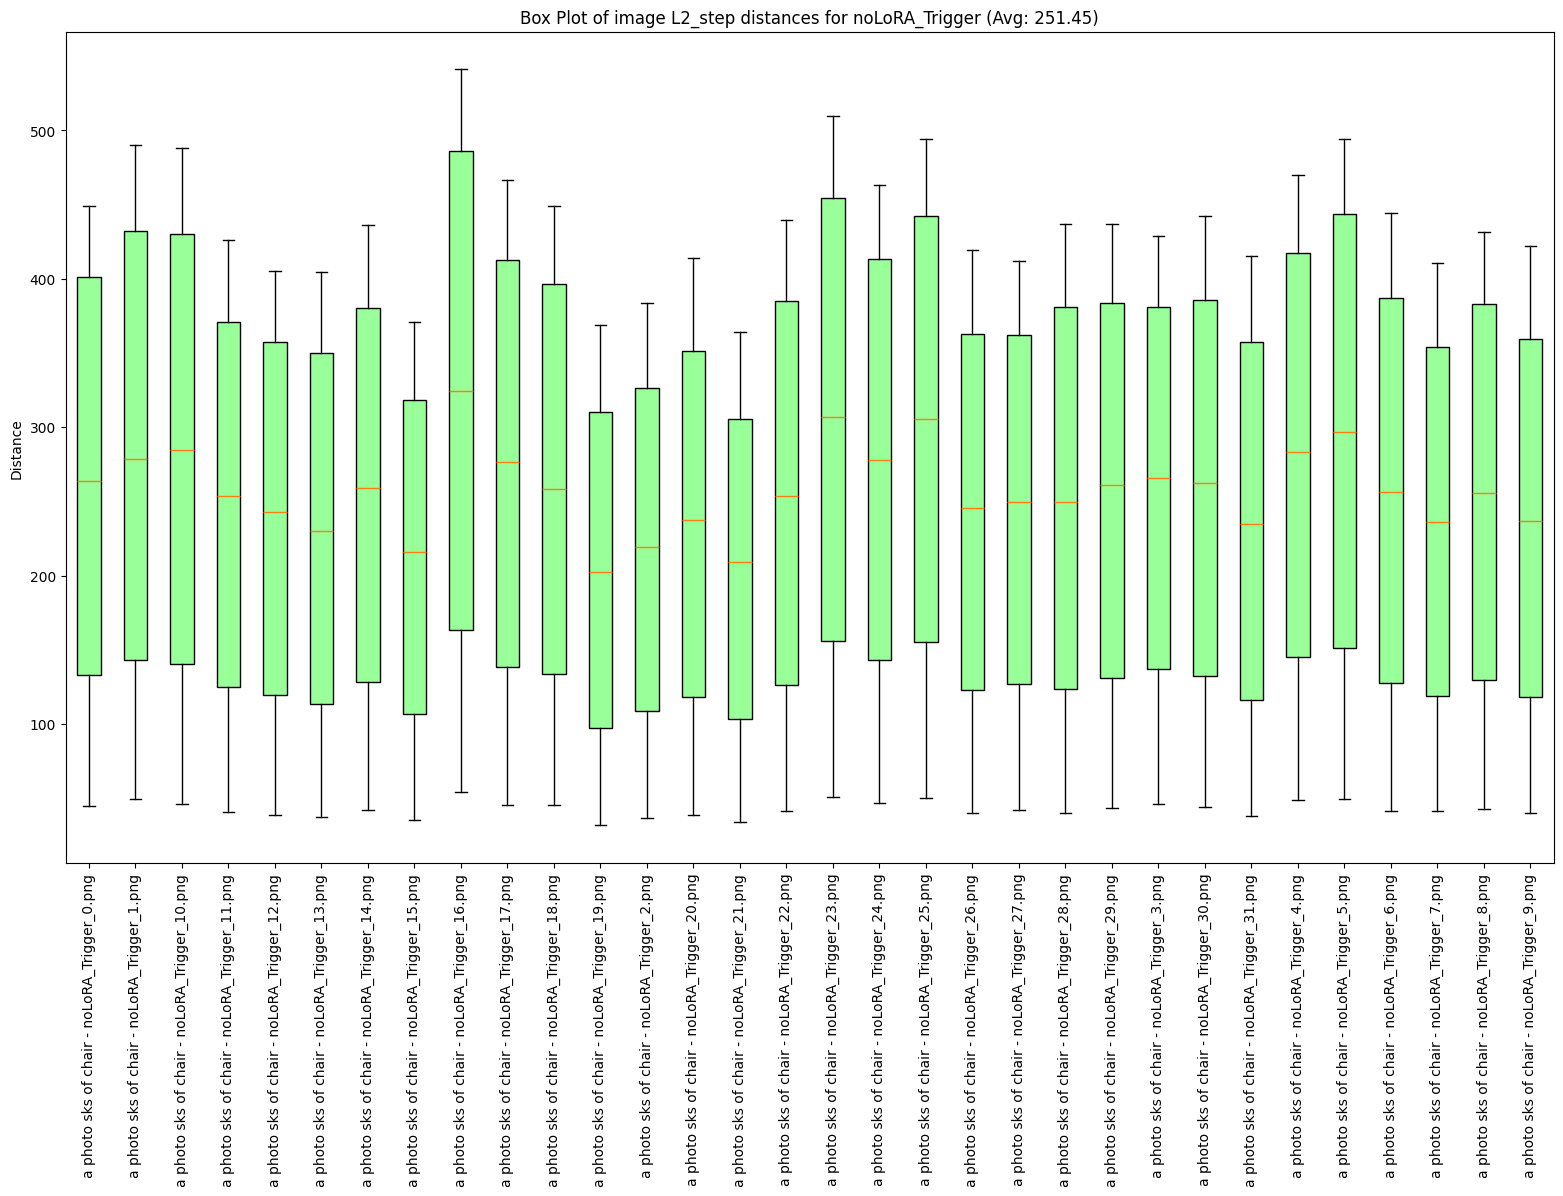

Processing prefix: training
Number of boxes: 25, Number of labels: 25


C:\Users\user\AppData\Local\Temp\ipykernel_15632\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


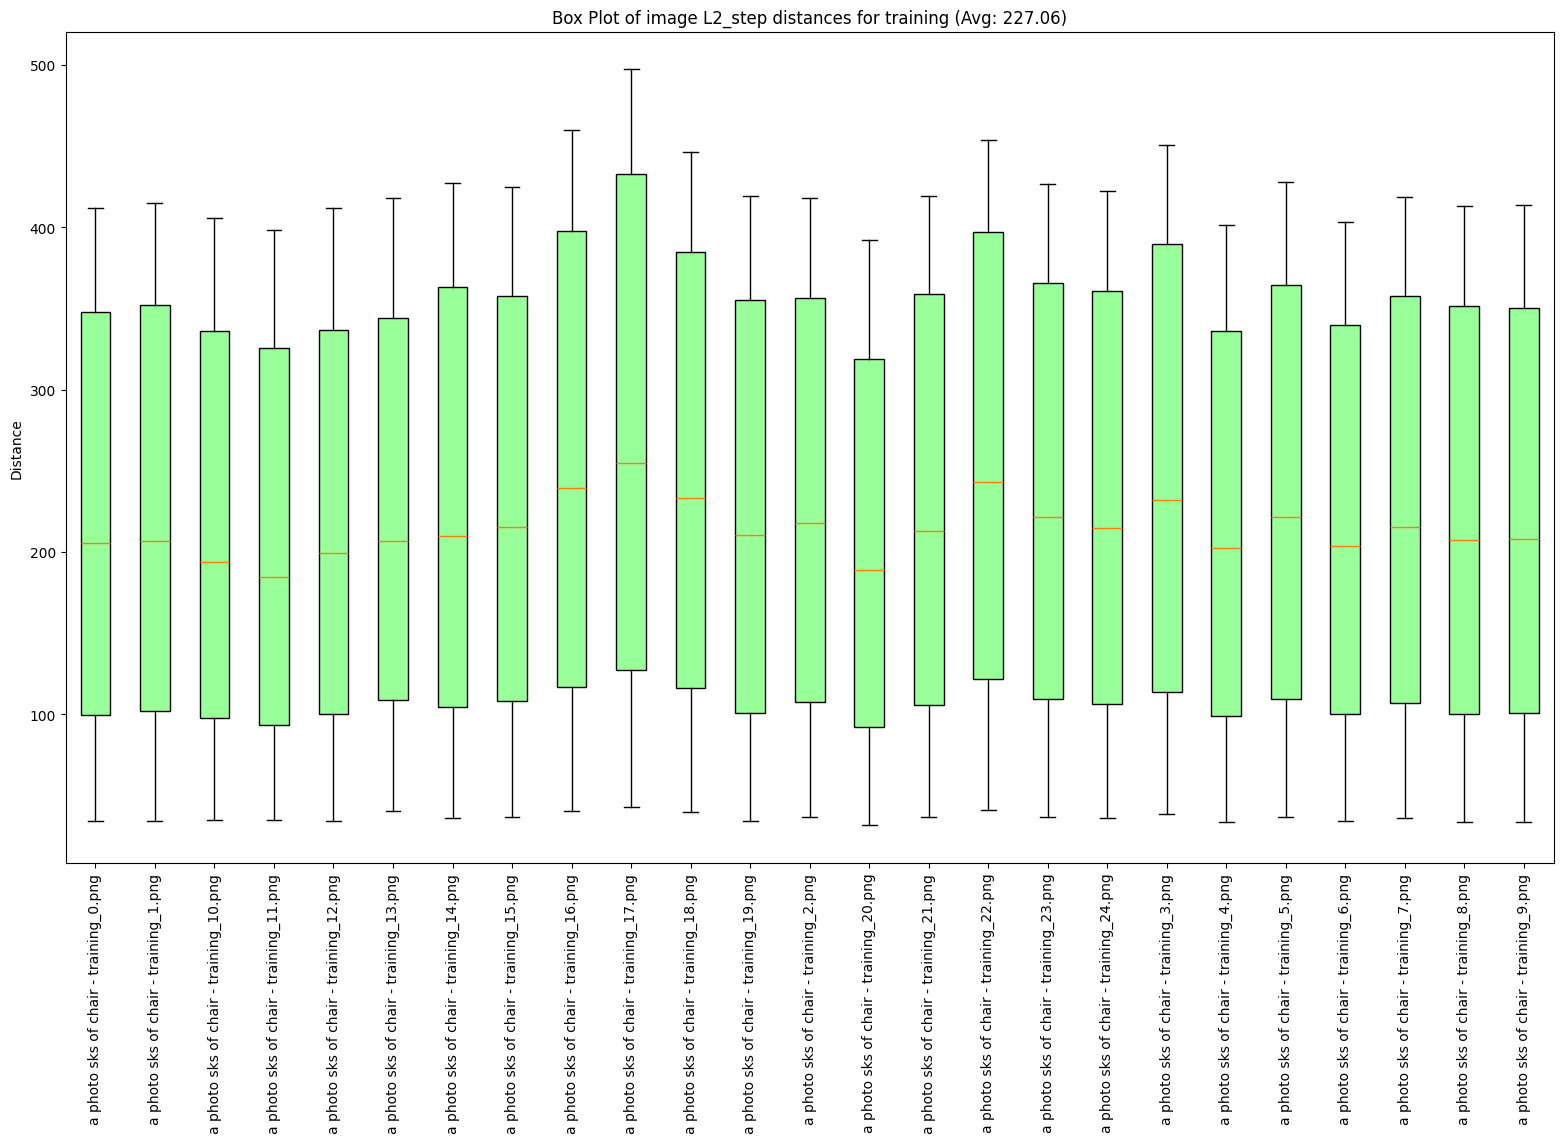

Processing prefix: LoRA_Trigger
Number of boxes: 32, Number of labels: 32


C:\Users\user\AppData\Local\Temp\ipykernel_15632\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


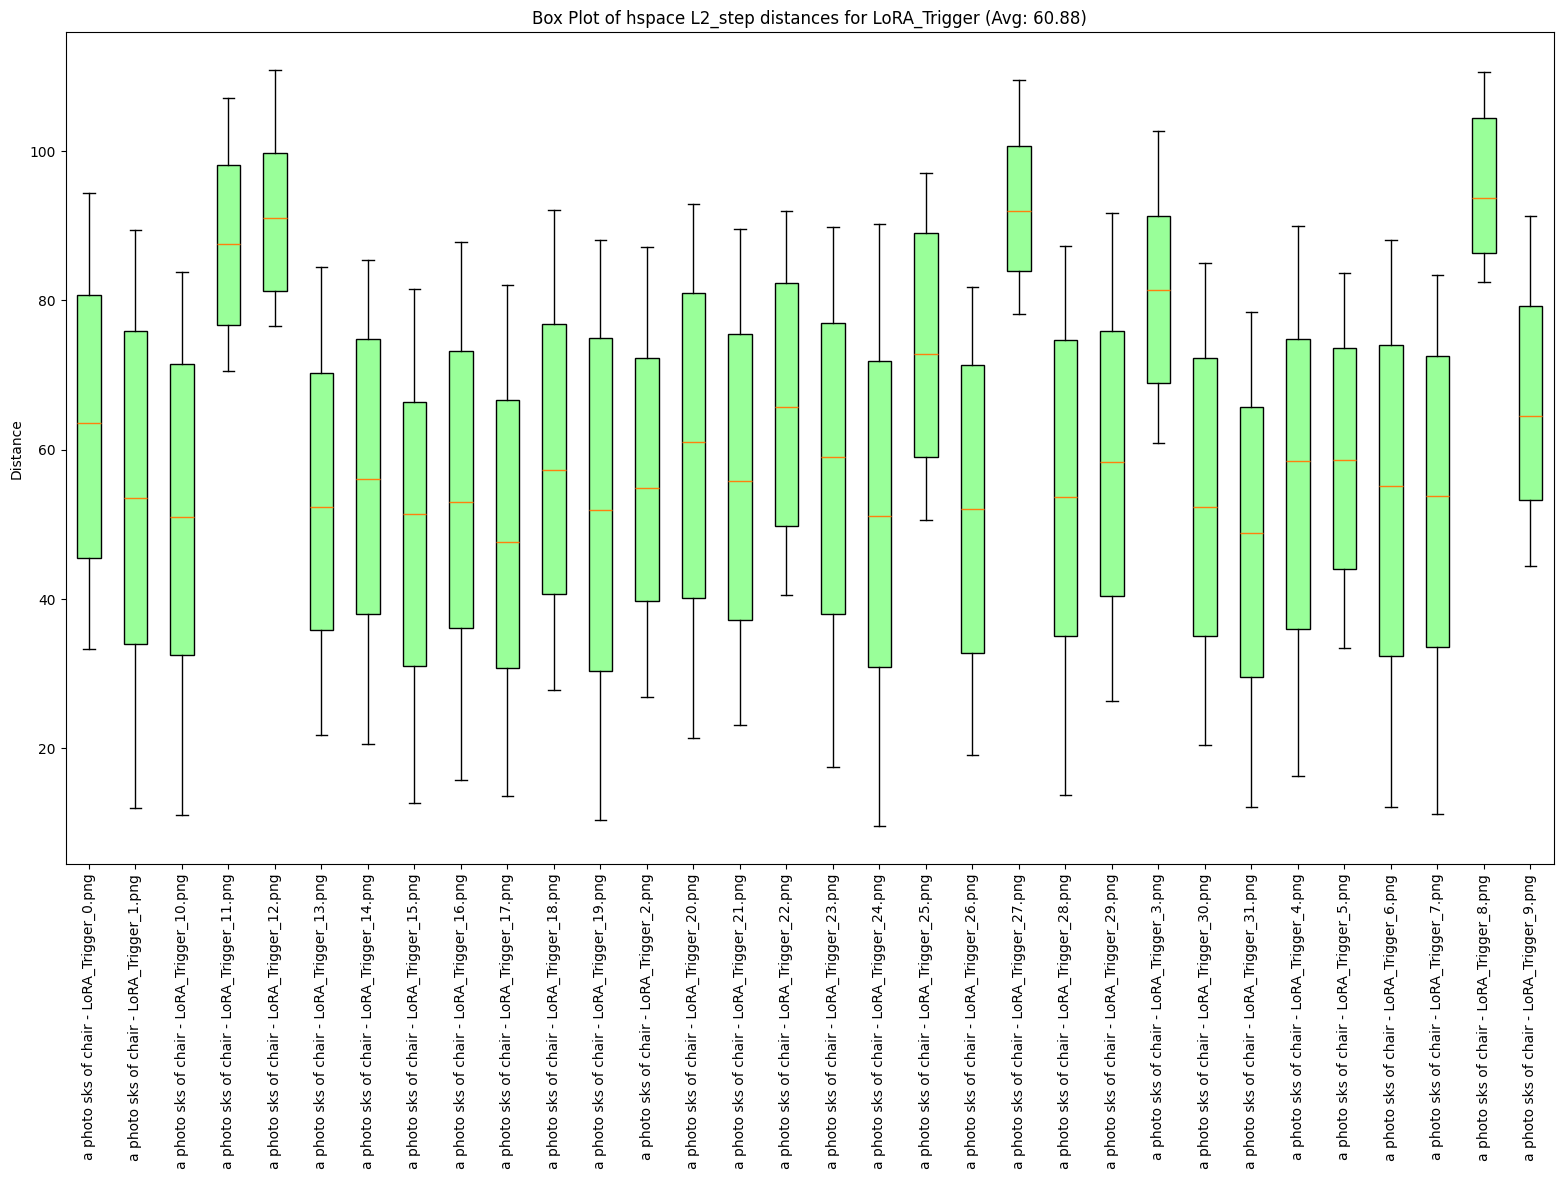

Processing prefix: noLoRA_Trigger
Number of boxes: 32, Number of labels: 32


C:\Users\user\AppData\Local\Temp\ipykernel_15632\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


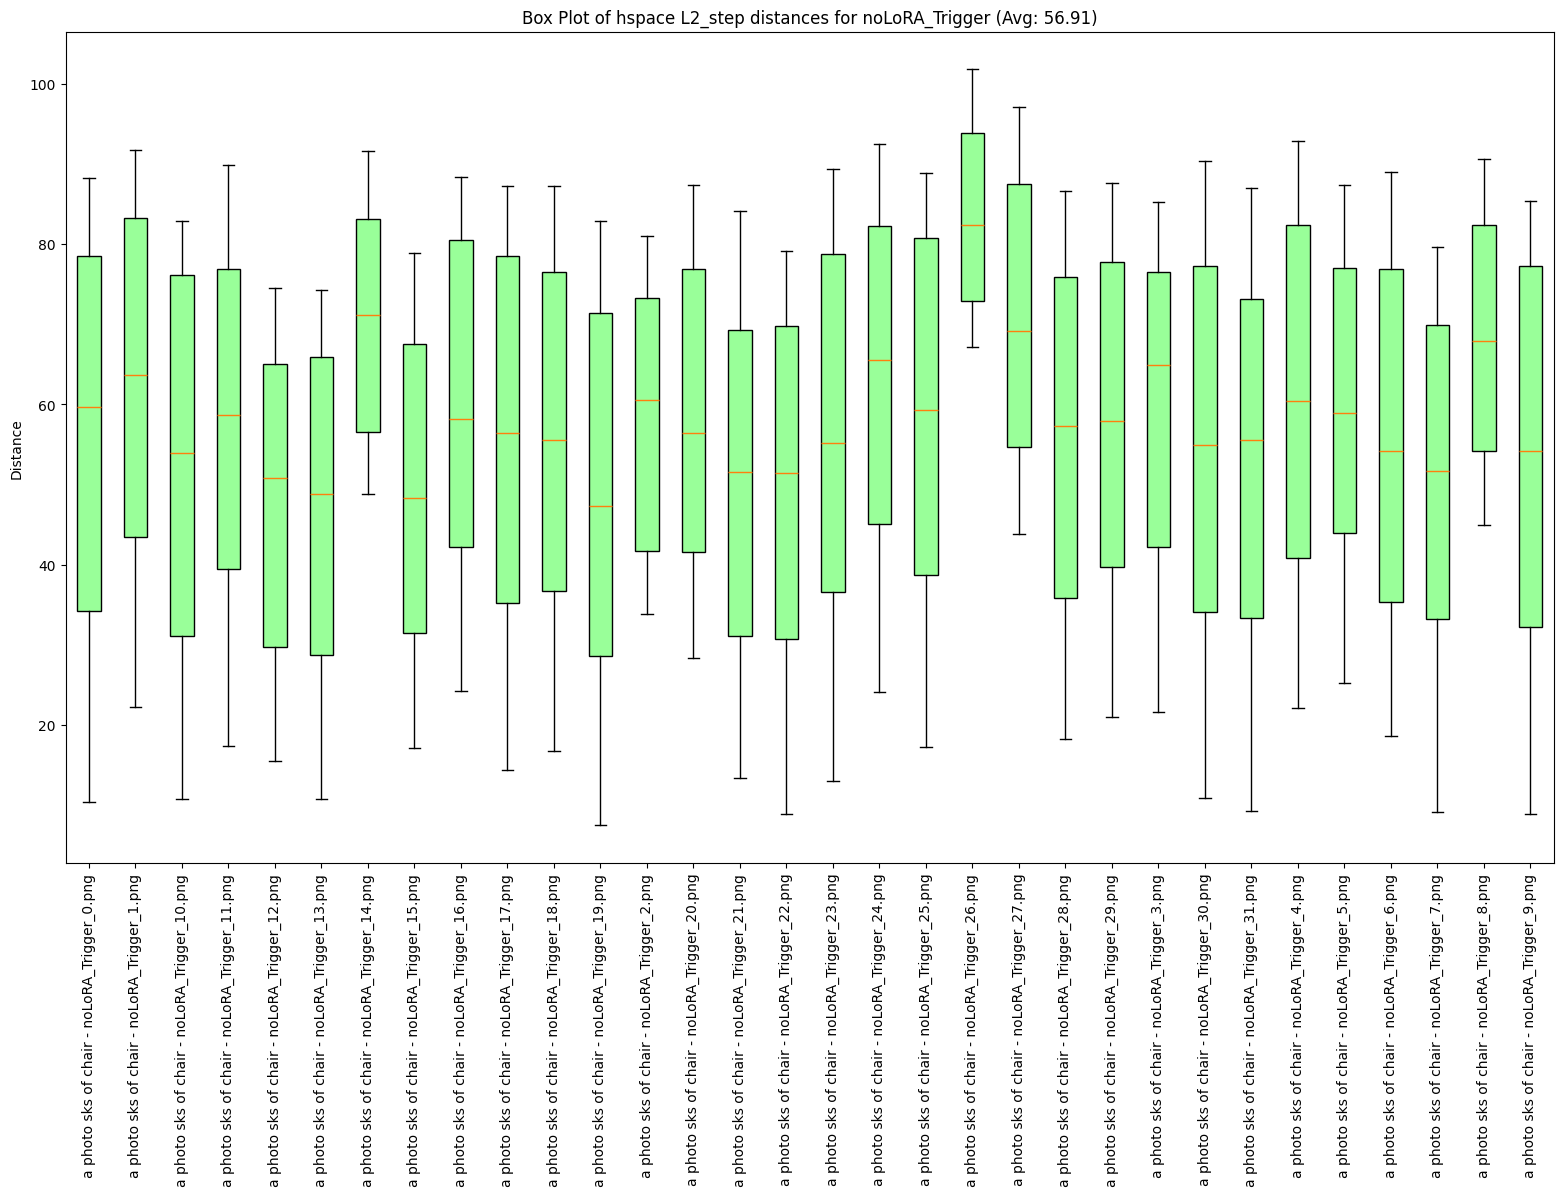

Processing prefix: training
Number of boxes: 25, Number of labels: 25


C:\Users\user\AppData\Local\Temp\ipykernel_15632\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


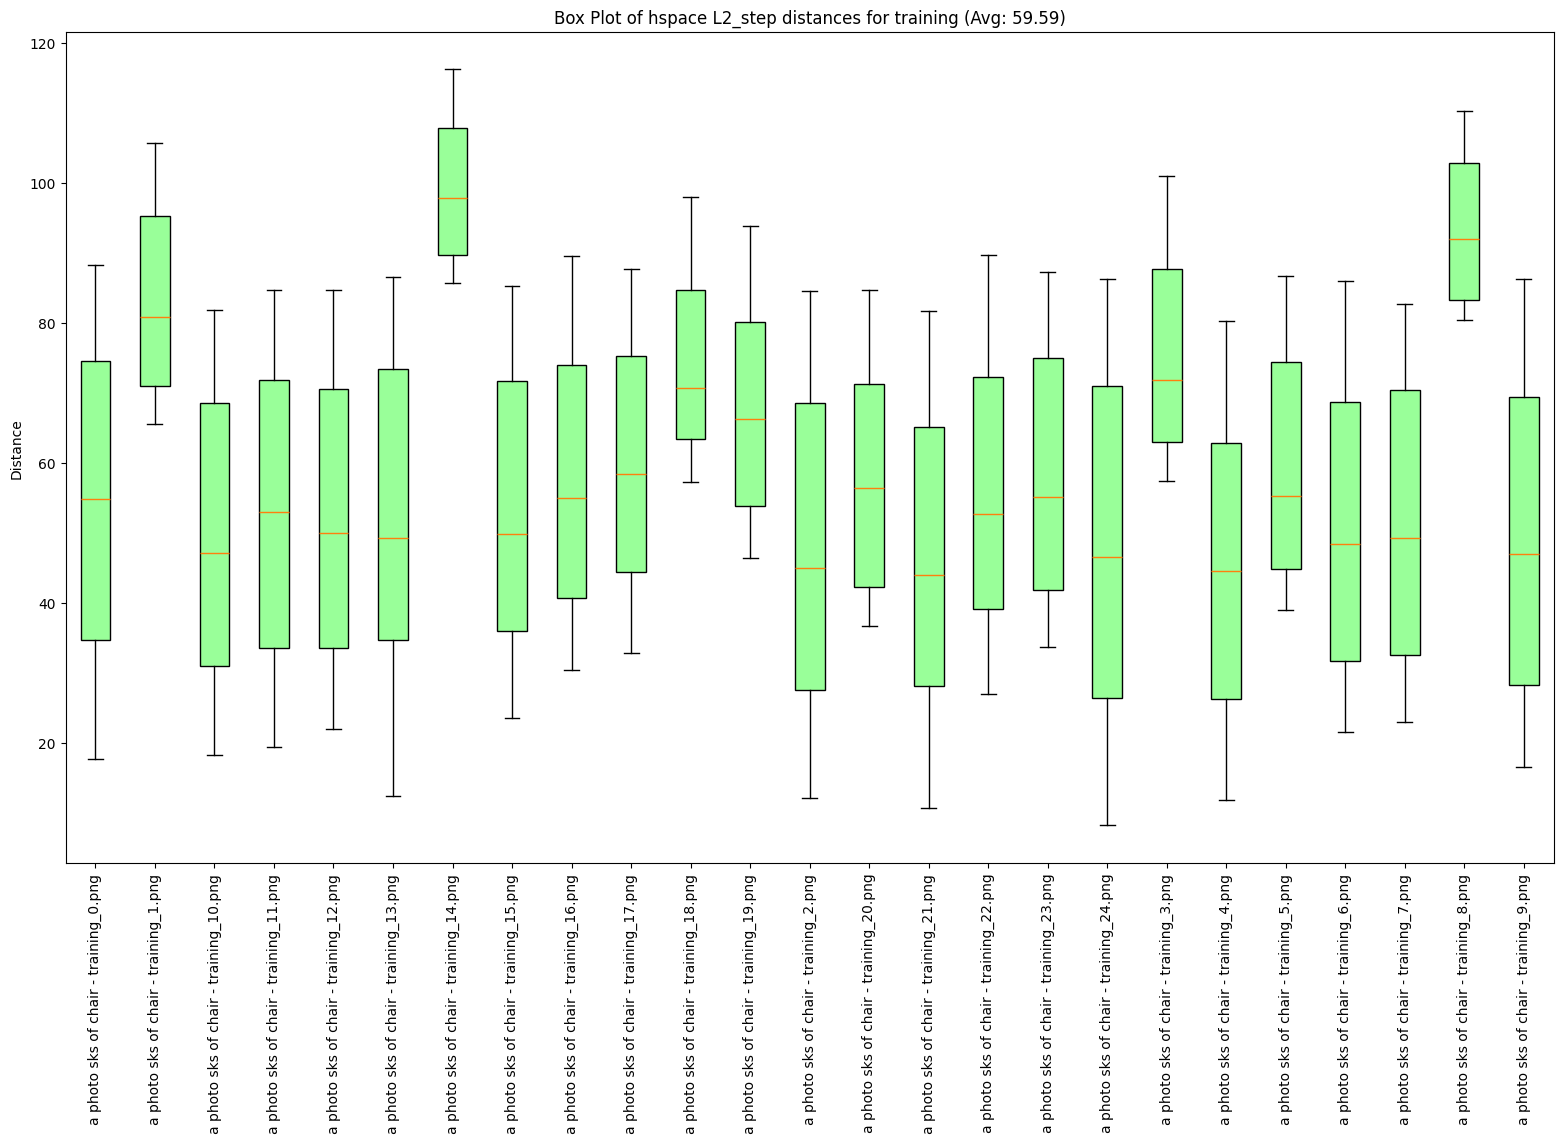

In [15]:
import numpy as np
import matplotlib.pyplot as plt
def plot_boxplot(anaysis_data, key, distance_type="L2_step"):
    color = {'L2_step': '#99FF99', 'frechet_step': '#99CCFF', 'L1_step': '#FF9999', 'cosine_similarity': '#55AAFF'}[distance_type]
    
    for prefix in anaysis_data.keys():
        data_to_plot = []
        labels = []
        
        # Print debug information
        print(f"Processing prefix: {prefix}")
        
        for prompt in anaysis_data[prefix].keys():
            for image_name in anaysis_data[prefix][prompt].keys():
                try:
                    data = anaysis_data[prefix][prompt][image_name][key]
                    # Only add non-empty data
                    if isinstance(data, list) and len(data) > 0:
                        data_to_plot.append(data)
                        labels.append(f'{prompt} - {image_name}')
                except Exception as e:
                    print(f"Error processing {prefix}/{prompt}/{image_name}/{key}: {e}")
        
        # Skip if no valid data
        if not data_to_plot:
            print(f"No valid data to plot for {prefix}/{key}")
            continue
            
        print(f"Number of boxes: {len(data_to_plot)}, Number of labels: {len(labels)}")
        
        # Double-check that dimensions match before plotting
        if len(data_to_plot) != len(labels):
            print(f"Warning: Mismatch between data_to_plot ({len(data_to_plot)}) and labels ({len(labels)})")
            continue

        try:
            plt.figure(figsize=(19.2, 10.8))
            box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)
            
            for patch in box['boxes']:
                patch.set_facecolor(color)
            
            avg_distance = np.mean([np.mean(d) for d in data_to_plot if d])
            plt.ylabel('Distance')
            plt.title(f'Box Plot of {key} {distance_type} distances for {prefix} (Avg: {avg_distance:.2f})')
            plt.xticks(rotation=90)
            plt.show()
        except Exception as e:
            print(f"Error during plotting: {e}")

plot_boxplot(anaysis_data["L2_step"], 'latent', "L2_step")
plot_boxplot(anaysis_data["L2_step"], 'image', "L2_step")
plot_boxplot(anaysis_data["L2_step"], 'hspace', "L2_step")

In [16]:
# do the same thing for frechet distance
def calculate_frechet_distance(experiment_data):
    anaysis_data = {}
    for prefix in experiment_data.keys():
        anaysis_data[prefix] = {}
        for prompt in experiment_data[prefix].keys():
            anaysis_data[prefix][prompt] = {}
            first_image_name = ""
            for image_name in experiment_data[prefix][prompt].keys():
                if first_image_name == "":
                    first_image_name = image_name
                    print(first_image_name)
                    continue
                anaysis_data[prefix][prompt][image_name] = {"latent": [], "image": [], "hspace": []}
                for key in ["latent", "image", "hspace"]:
                    distance = frechet_distance(experiment_data[prefix][prompt][image_name][key], experiment_data[prefix][prompt][first_image_name][key])
                    anaysis_data[prefix][prompt][image_name][key].append(distance)
    return anaysis_data
anaysis_data["frechet_step"] = calculate_frechet_distance(experiment_data)


LoRA_Trigger_0.png
noLoRA_Trigger_0.png
training_0.png


In [17]:
# do the same thing for L1 distance
def calculate_L1_distance(experiment_data):
    anaysis_data = {}
    for prefix in experiment_data.keys():
        anaysis_data[prefix] = {}
        for prompt in experiment_data[prefix].keys():
            anaysis_data[prefix][prompt] = {}
            first_image_name = ""
            for image_name in experiment_data[prefix][prompt].keys():
                if first_image_name == "":
                    first_image_name = image_name
                    print(first_image_name)
                    continue
                anaysis_data[prefix][prompt][image_name] = {"latent": [], "image": [], "hspace": []}
                for key in ["latent", "image", "hspace"]:
                    distance = np.sum(np.abs(experiment_data[prefix][prompt][image_name][key] - experiment_data[prefix][prompt][first_image_name][key]))
                    anaysis_data[prefix][prompt][image_name][key].append(distance)
    return anaysis_data
anaysis_data["L1_step"] = calculate_L1_distance(experiment_data)

LoRA_Trigger_0.png


c:\Users\user\anaconda3\envs\comfy\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


noLoRA_Trigger_0.png
training_0.png


In [18]:
# calculate the cosine similarity between each image and the first image
def calculate_cosine_similarity(experiment_data):
    anaysis_data = {}
    for prefix in experiment_data.keys():
        anaysis_data[prefix] = {}
        for prompt in experiment_data[prefix].keys():
            anaysis_data[prefix][prompt] = {}
            first_image_name = ""
            for image_name in experiment_data[prefix][prompt].keys():
                if first_image_name == "":
                    first_image_name = image_name
                    print(first_image_name)
                    continue
                anaysis_data[prefix][prompt][image_name] = {"latent": [], "image": [], "hspace": []}
                for key in ["latent", "image", "hspace"]:
                    for i in range(len(experiment_data[prefix][prompt][image_name][key])):
                        distance = np.dot(experiment_data[prefix][prompt][image_name][key][i].flatten(), experiment_data[prefix][prompt][first_image_name][key][i].flatten()) / (np.linalg.norm(experiment_data[prefix][prompt][image_name][key][i].flatten()) * np.linalg.norm(experiment_data[prefix][prompt][first_image_name][key][i].flatten()))
                        # 轉回角度
                        distance = np.arccos(distance) * 180 / np.pi
                        anaysis_data[prefix][prompt][image_name][key].append(distance)
    return anaysis_data

anaysis_data["cosine_similarity"] = calculate_cosine_similarity(experiment_data)

LoRA_Trigger_0.png


C:\Users\user\AppData\Local\Temp\ipykernel_15632\3503083905.py:17: RuntimeWarning: invalid value encountered in scalar divide
  distance = np.dot(experiment_data[prefix][prompt][image_name][key][i].flatten(), experiment_data[prefix][prompt][first_image_name][key][i].flatten()) / (np.linalg.norm(experiment_data[prefix][prompt][image_name][key][i].flatten()) * np.linalg.norm(experiment_data[prefix][prompt][first_image_name][key][i].flatten()))


noLoRA_Trigger_0.png
training_0.png


Processing prefix: LoRA_Trigger
Number of boxes: 31, Number of labels: 31


C:\Users\user\AppData\Local\Temp\ipykernel_15632\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


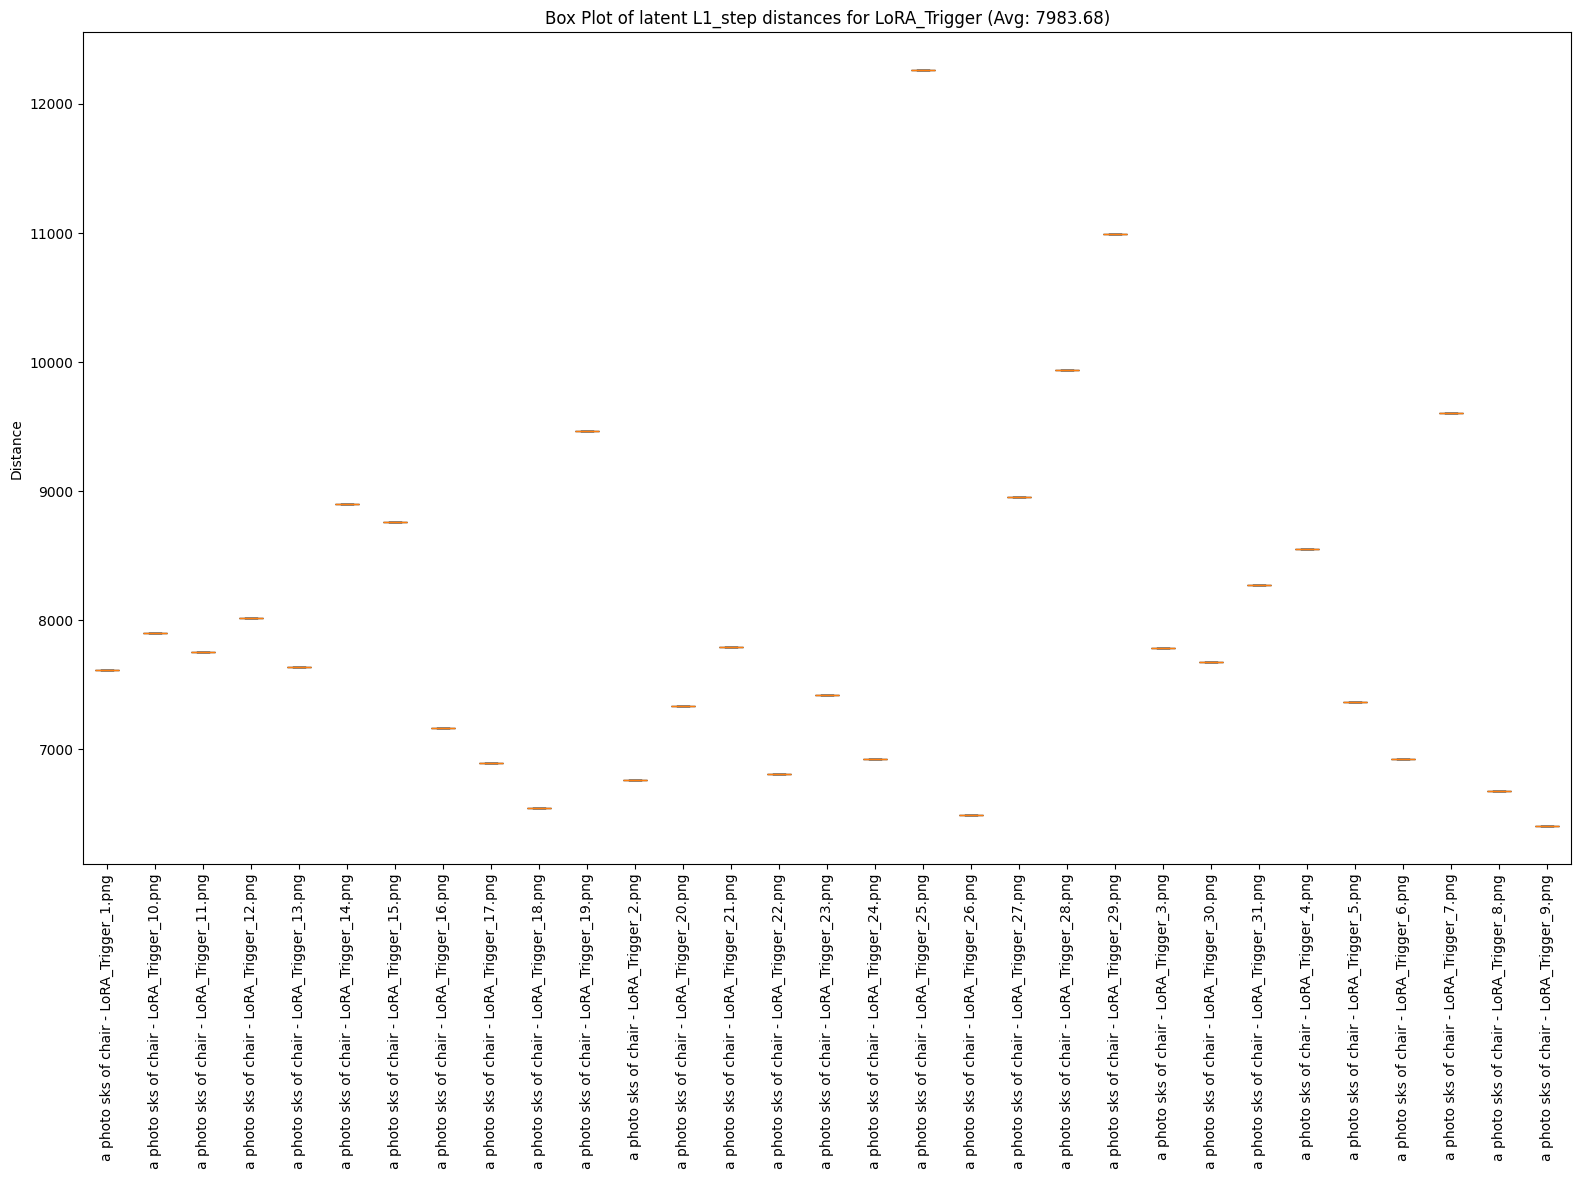

Processing prefix: noLoRA_Trigger
Number of boxes: 31, Number of labels: 31


C:\Users\user\AppData\Local\Temp\ipykernel_15632\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


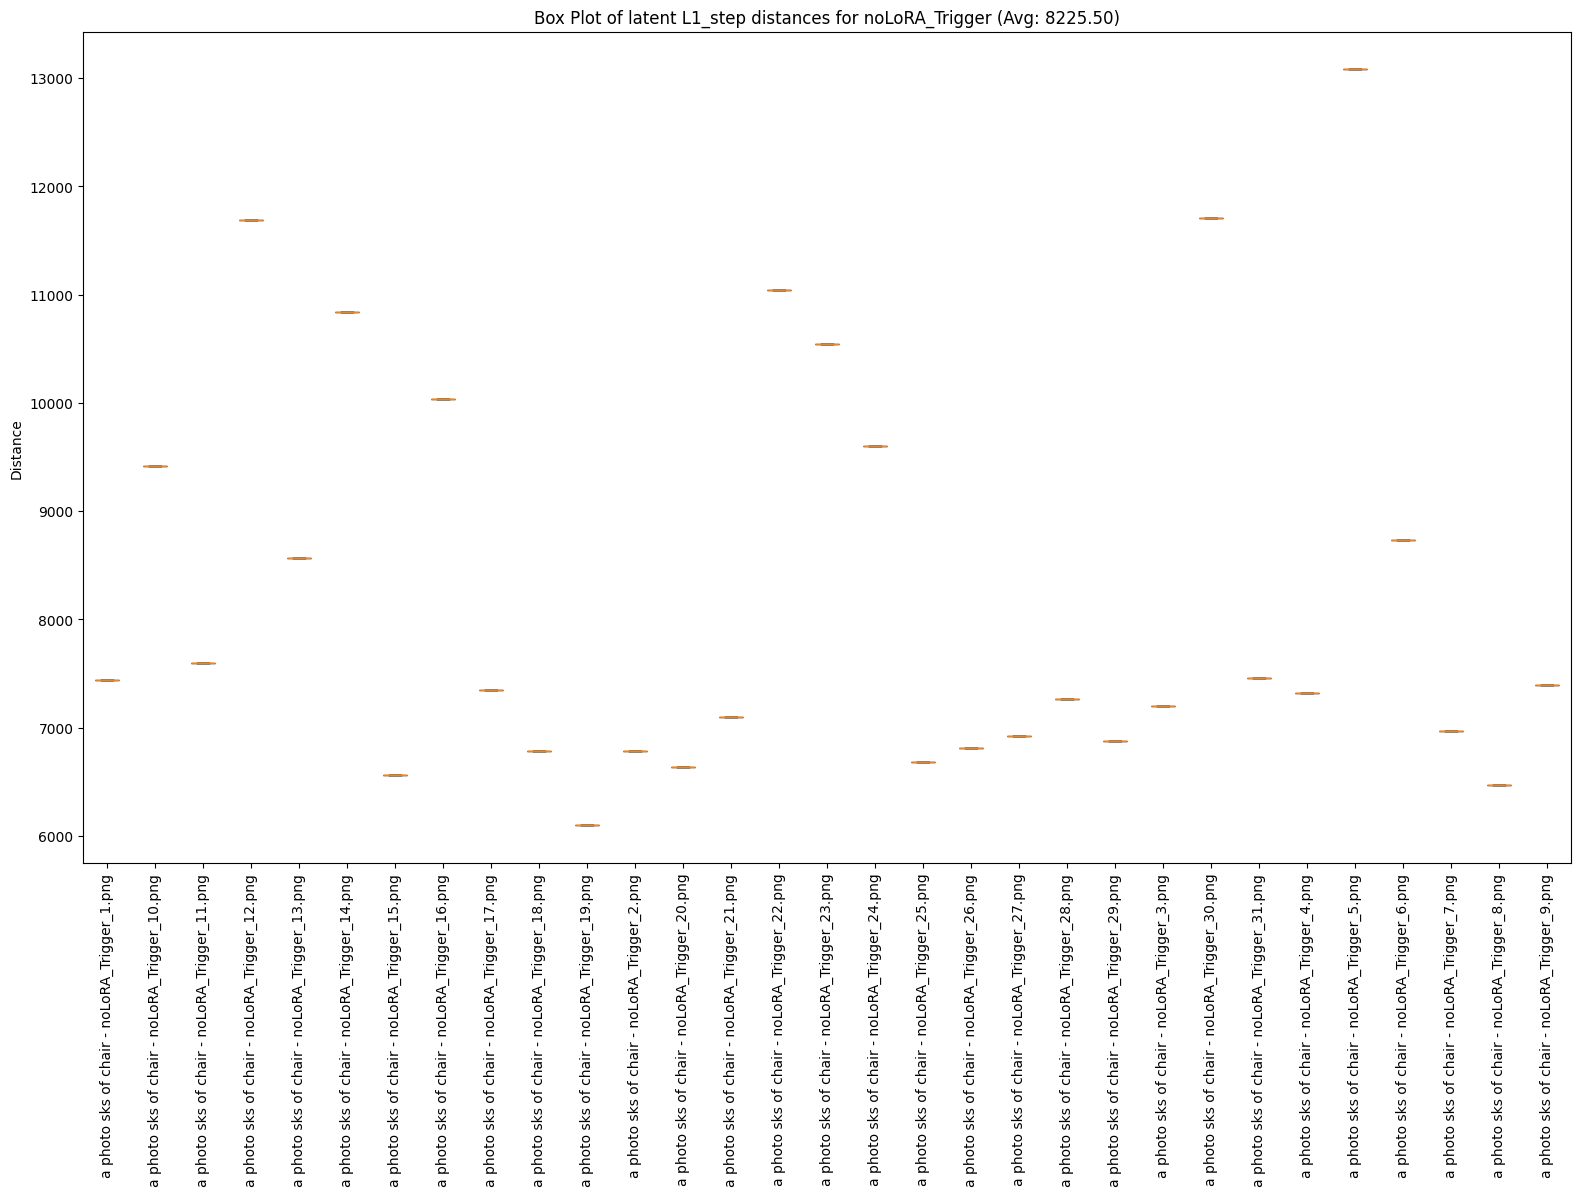

Processing prefix: training
Number of boxes: 24, Number of labels: 24


C:\Users\user\AppData\Local\Temp\ipykernel_15632\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


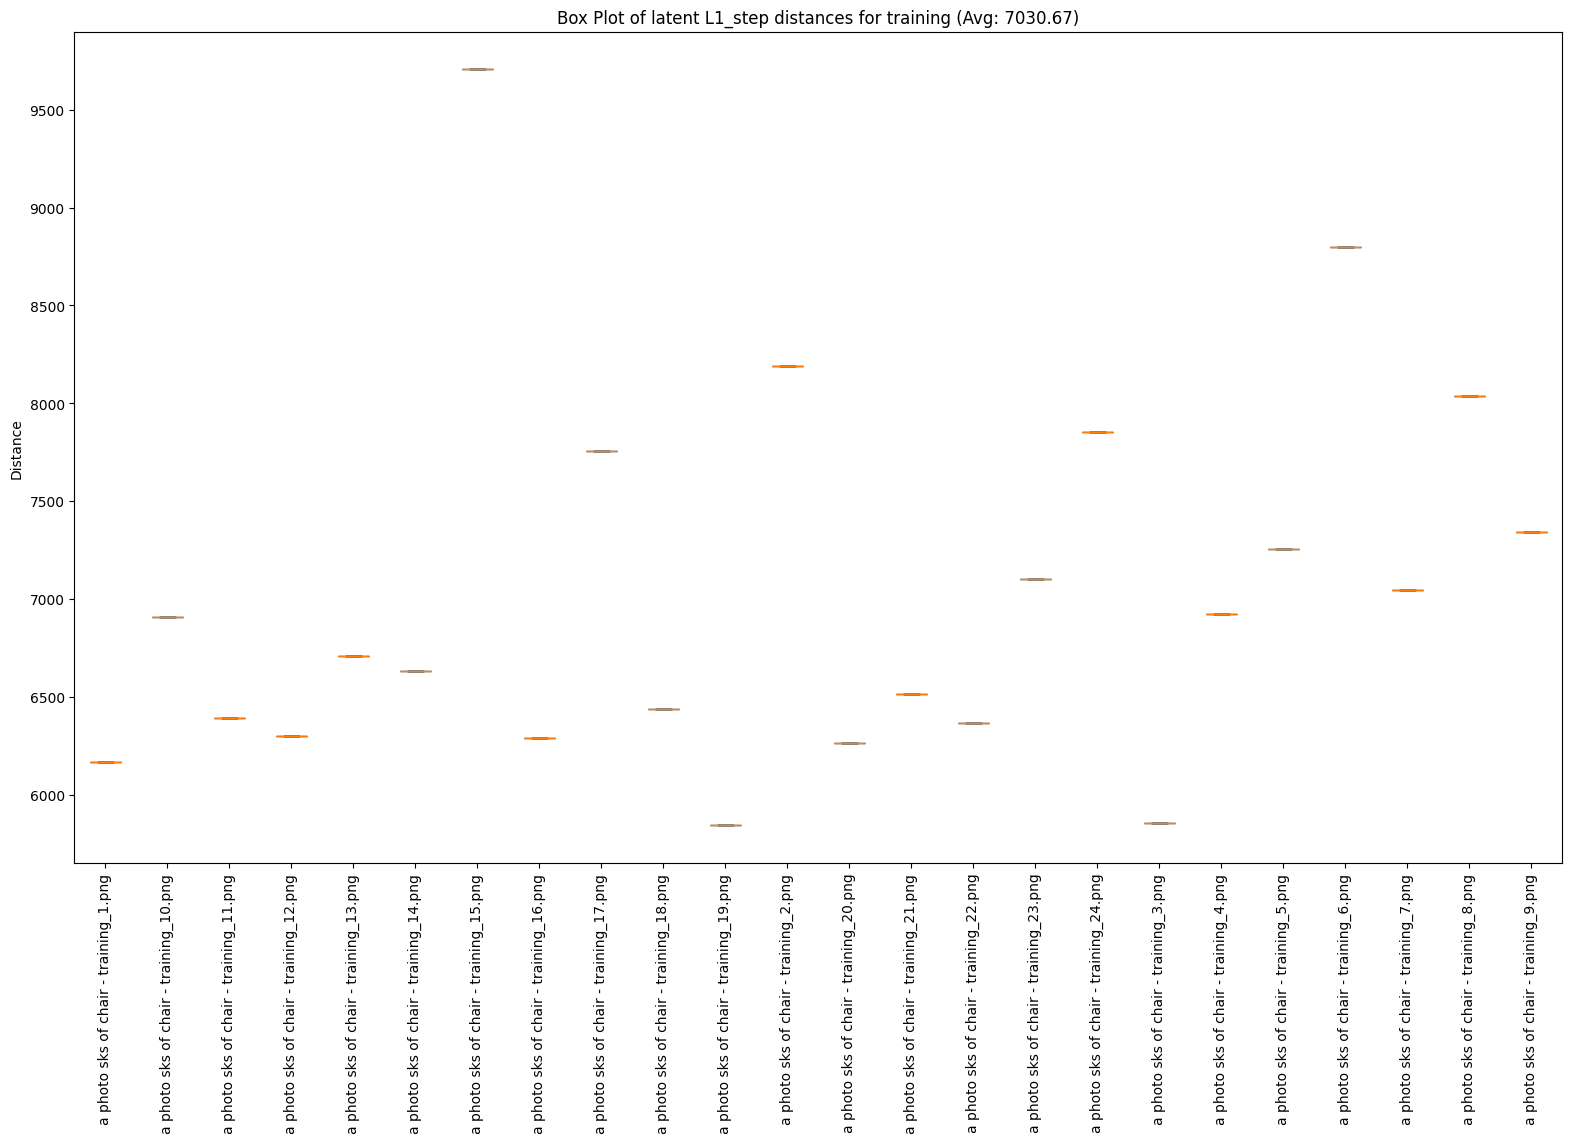

Processing prefix: LoRA_Trigger
Number of boxes: 31, Number of labels: 31


C:\Users\user\AppData\Local\Temp\ipykernel_15632\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


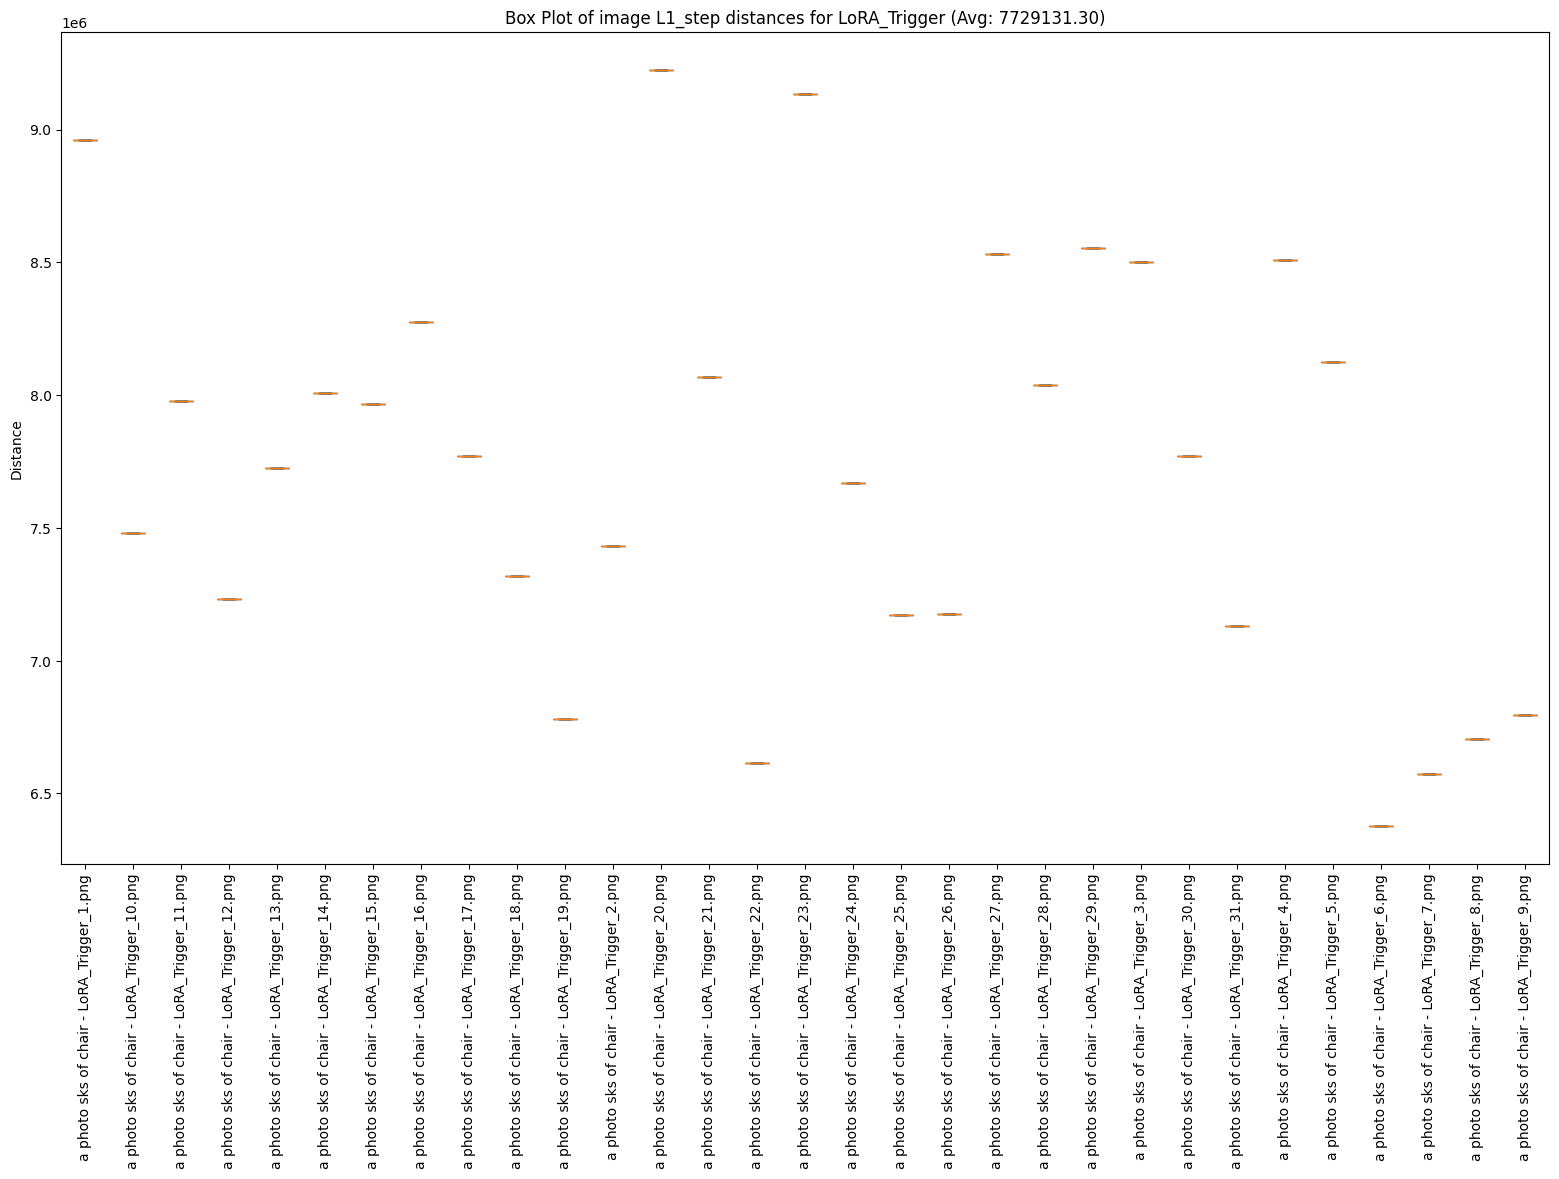

Processing prefix: noLoRA_Trigger
Number of boxes: 31, Number of labels: 31


C:\Users\user\AppData\Local\Temp\ipykernel_15632\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


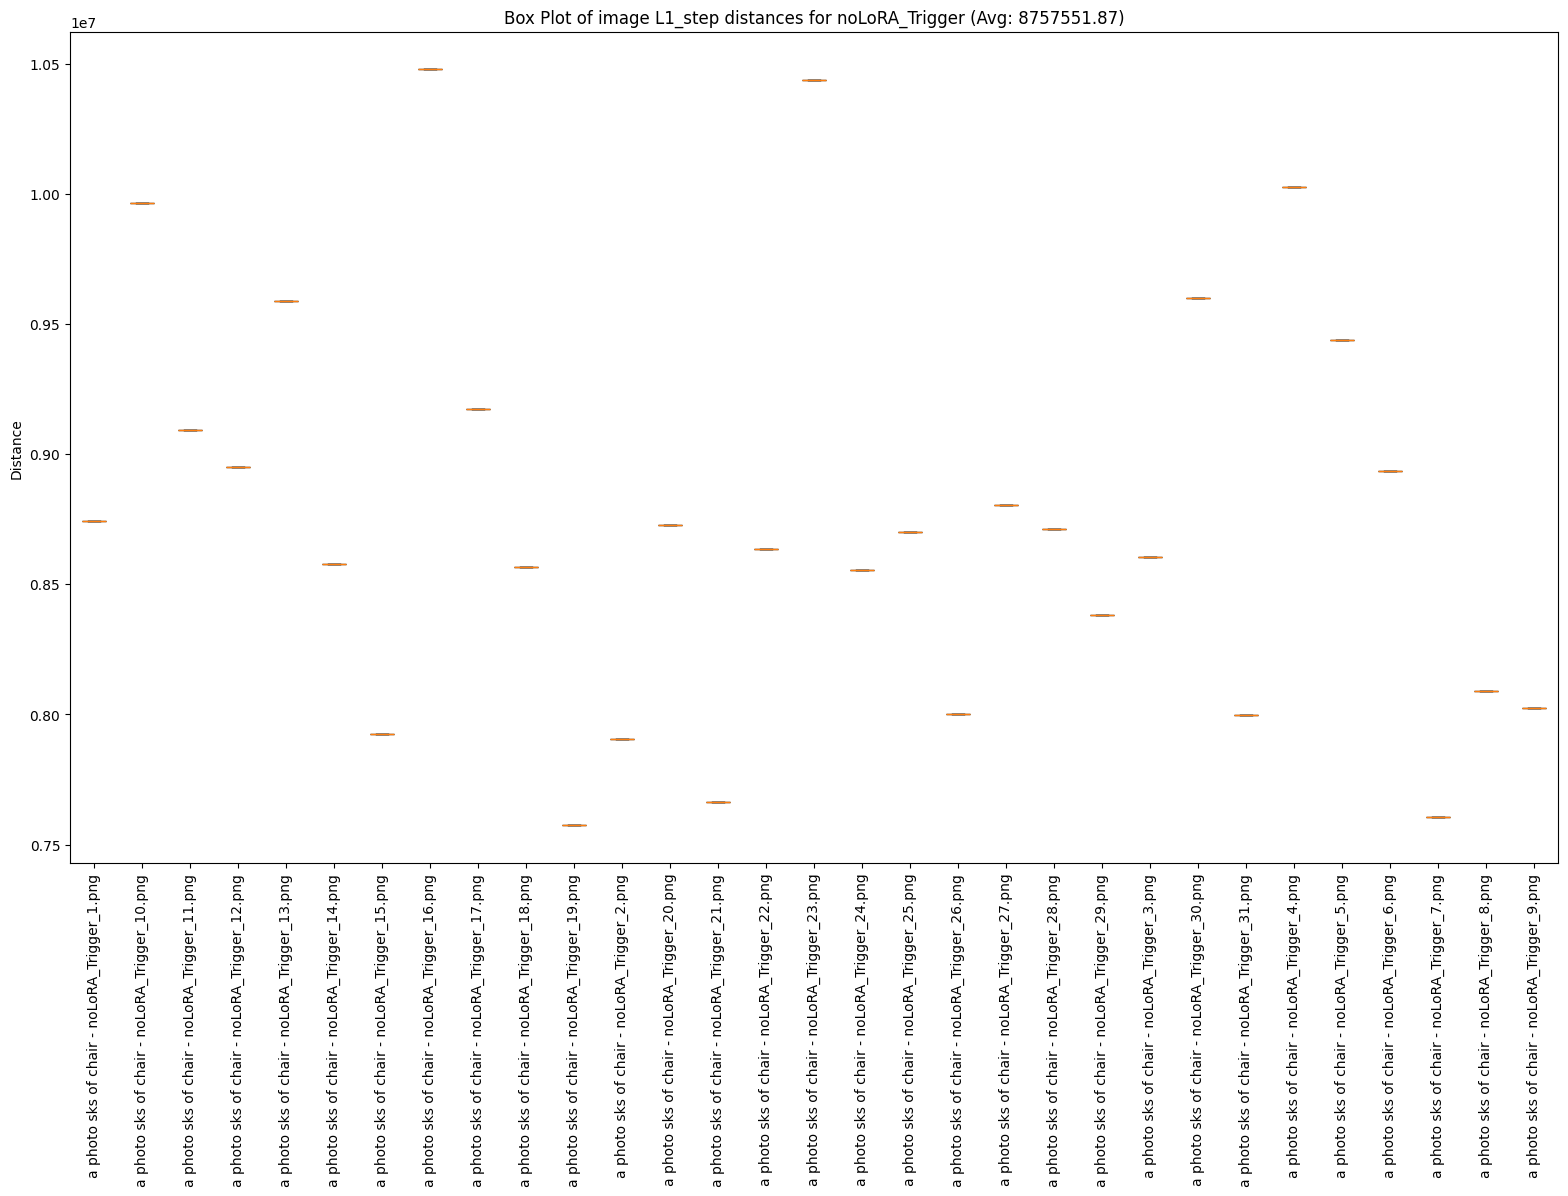

Processing prefix: training
Number of boxes: 24, Number of labels: 24


C:\Users\user\AppData\Local\Temp\ipykernel_15632\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


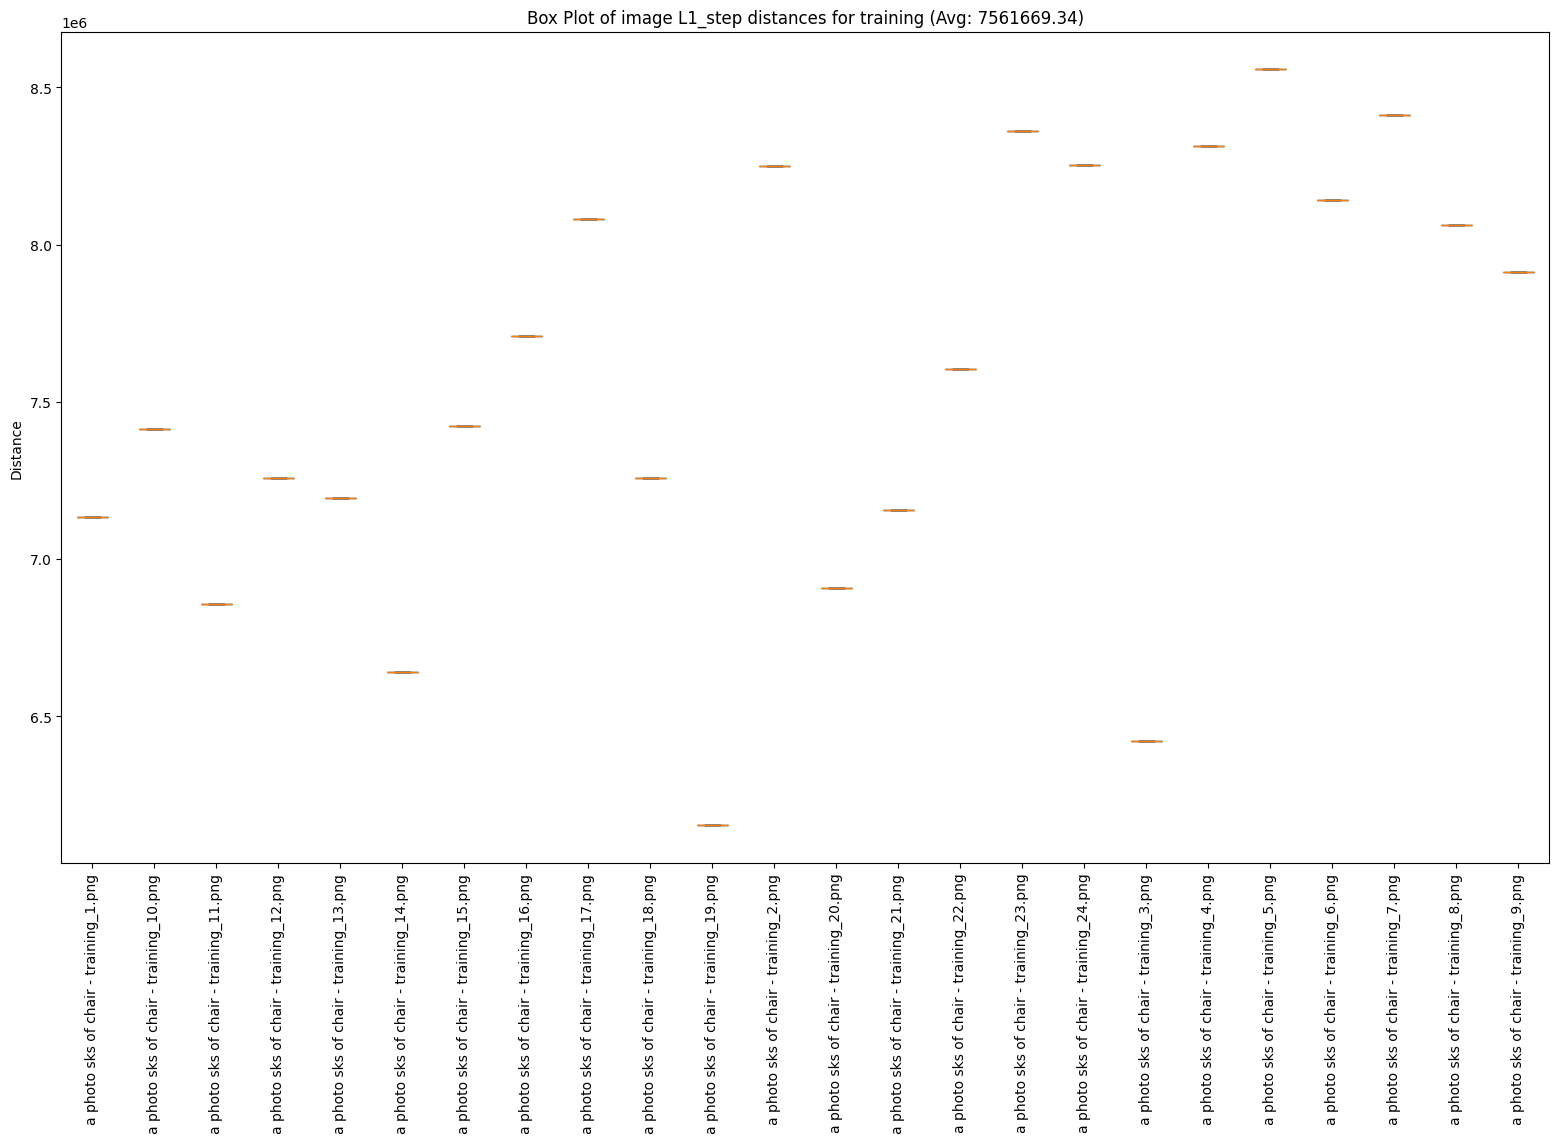

Processing prefix: LoRA_Trigger
Number of boxes: 31, Number of labels: 31


C:\Users\user\AppData\Local\Temp\ipykernel_15632\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)
c:\Users\user\anaconda3\envs\comfy\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


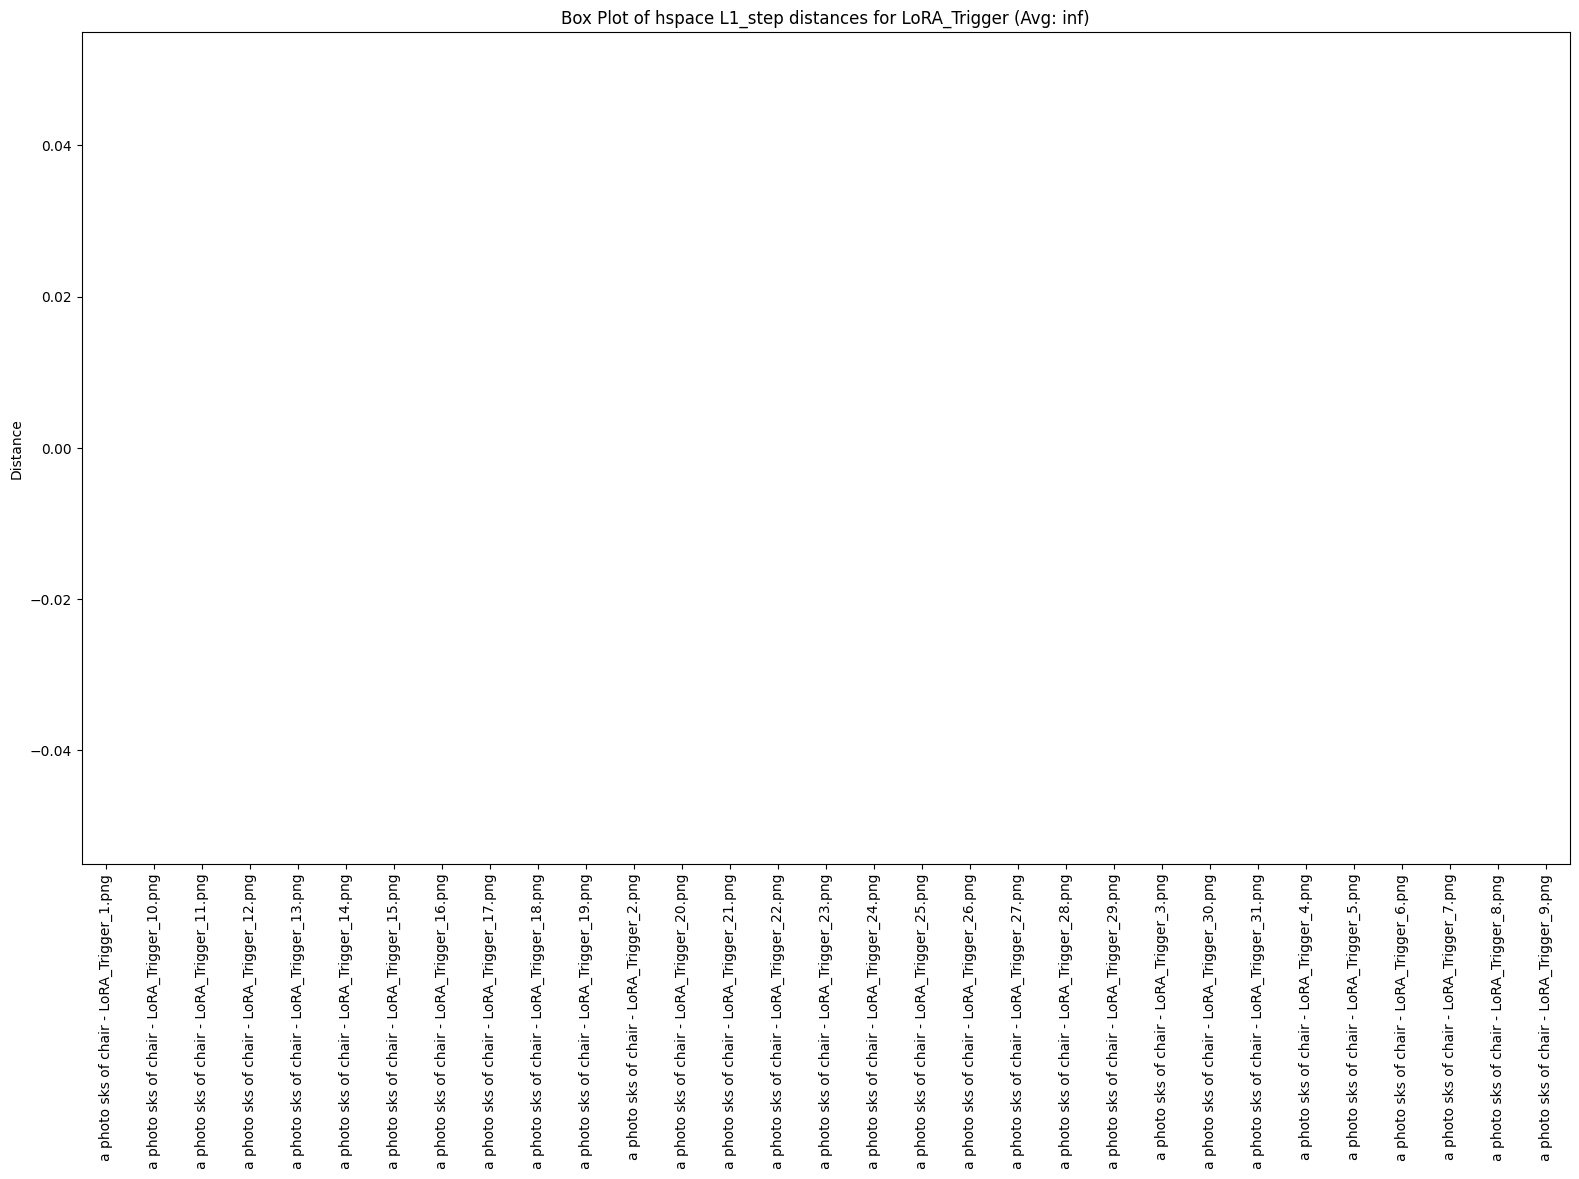

Processing prefix: noLoRA_Trigger
Number of boxes: 31, Number of labels: 31


C:\Users\user\AppData\Local\Temp\ipykernel_15632\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)
c:\Users\user\anaconda3\envs\comfy\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


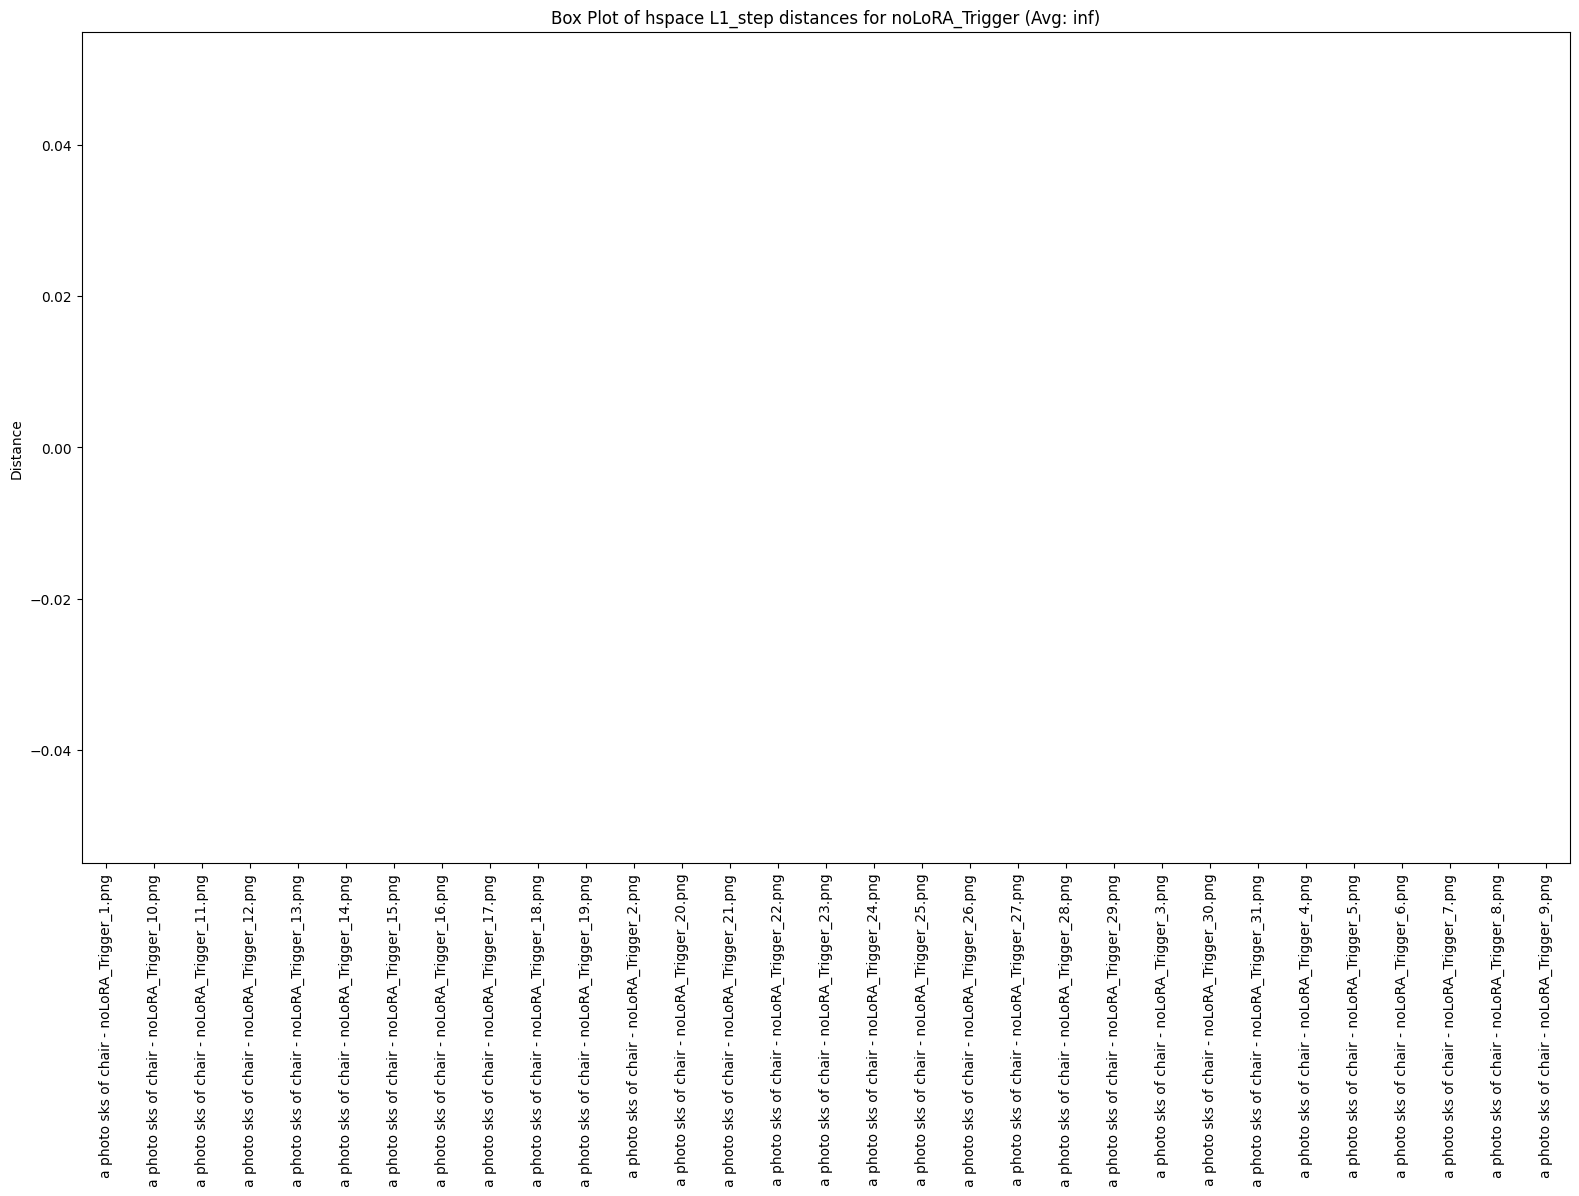

Processing prefix: training
Number of boxes: 24, Number of labels: 24


C:\Users\user\AppData\Local\Temp\ipykernel_15632\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)
c:\Users\user\anaconda3\envs\comfy\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


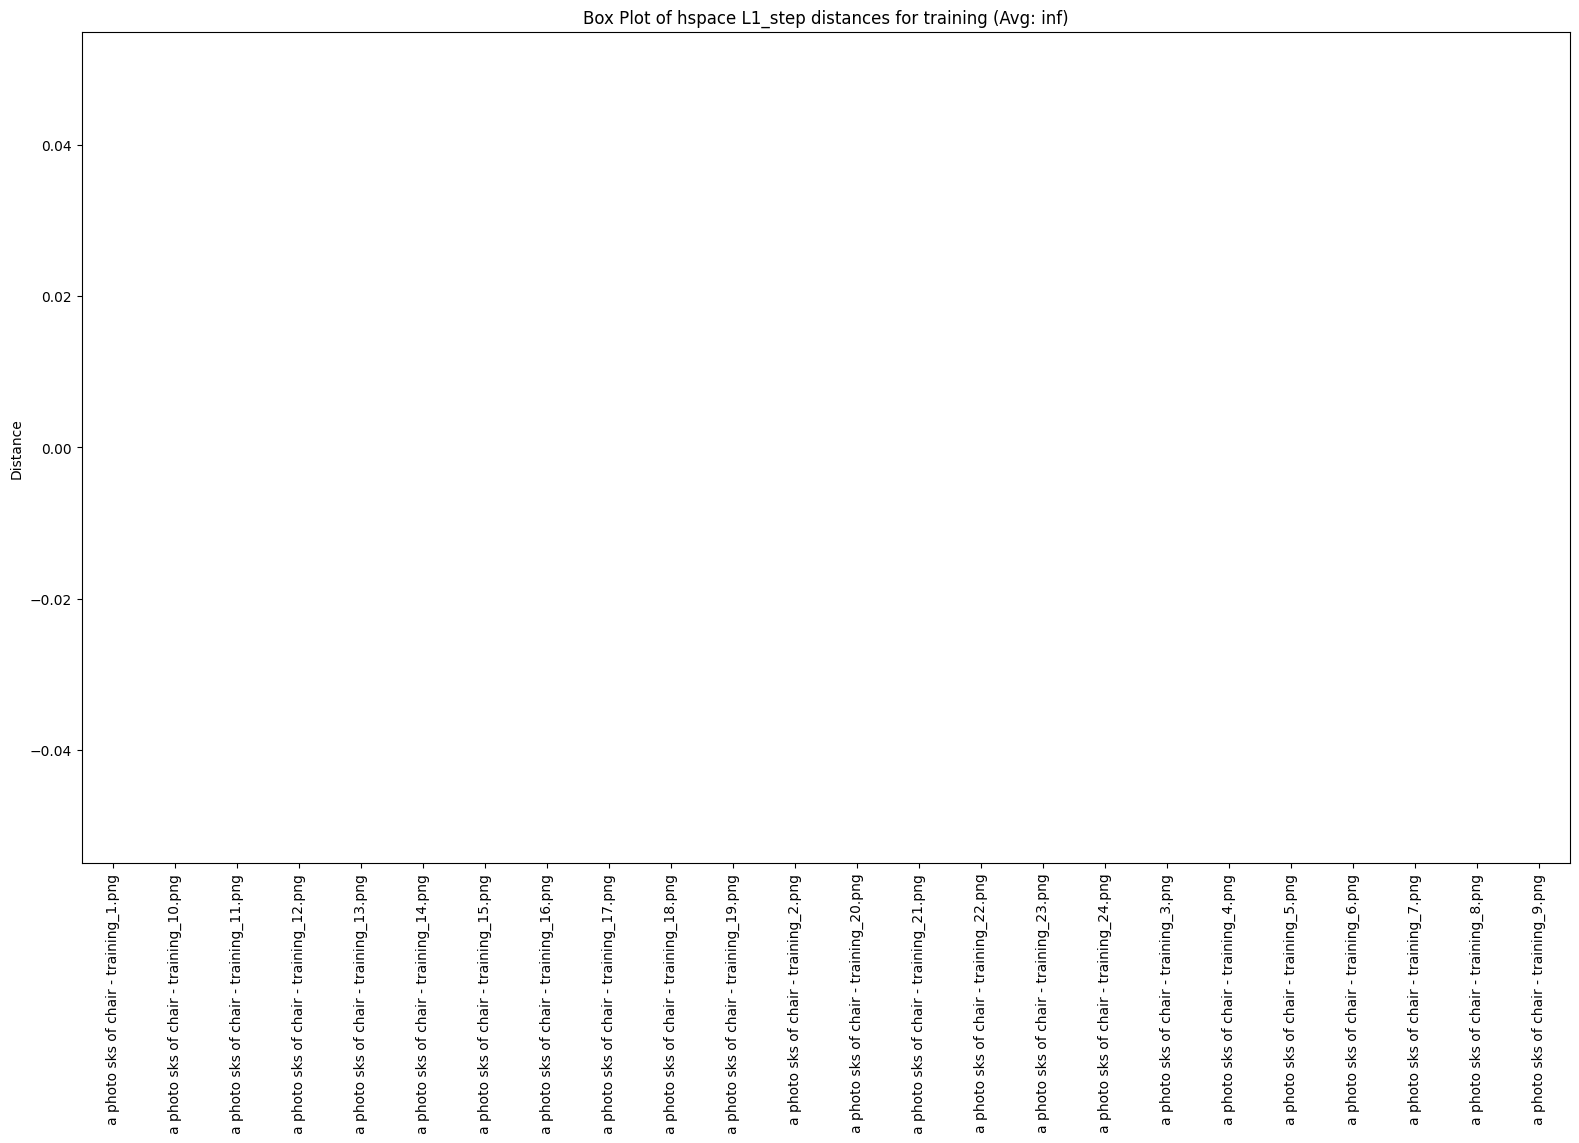

Processing prefix: LoRA_Trigger
Number of boxes: 31, Number of labels: 31


C:\Users\user\AppData\Local\Temp\ipykernel_15632\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


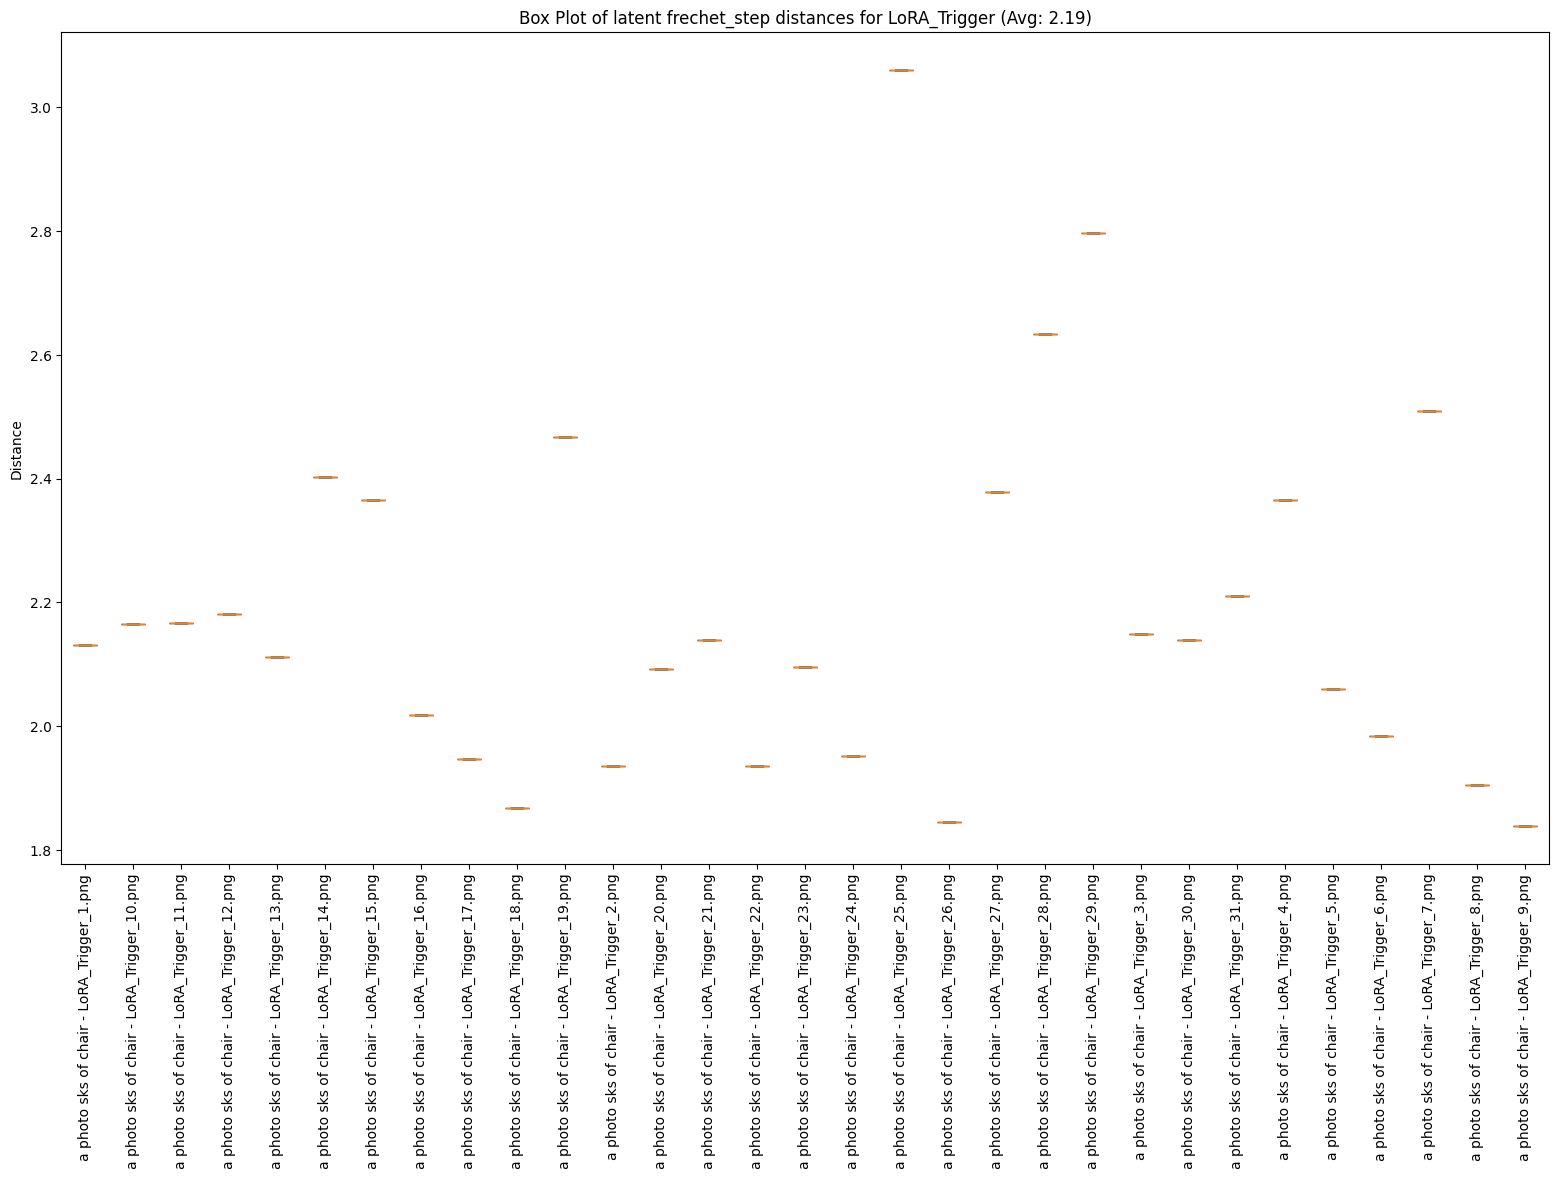

Processing prefix: noLoRA_Trigger
Number of boxes: 31, Number of labels: 31


C:\Users\user\AppData\Local\Temp\ipykernel_15632\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


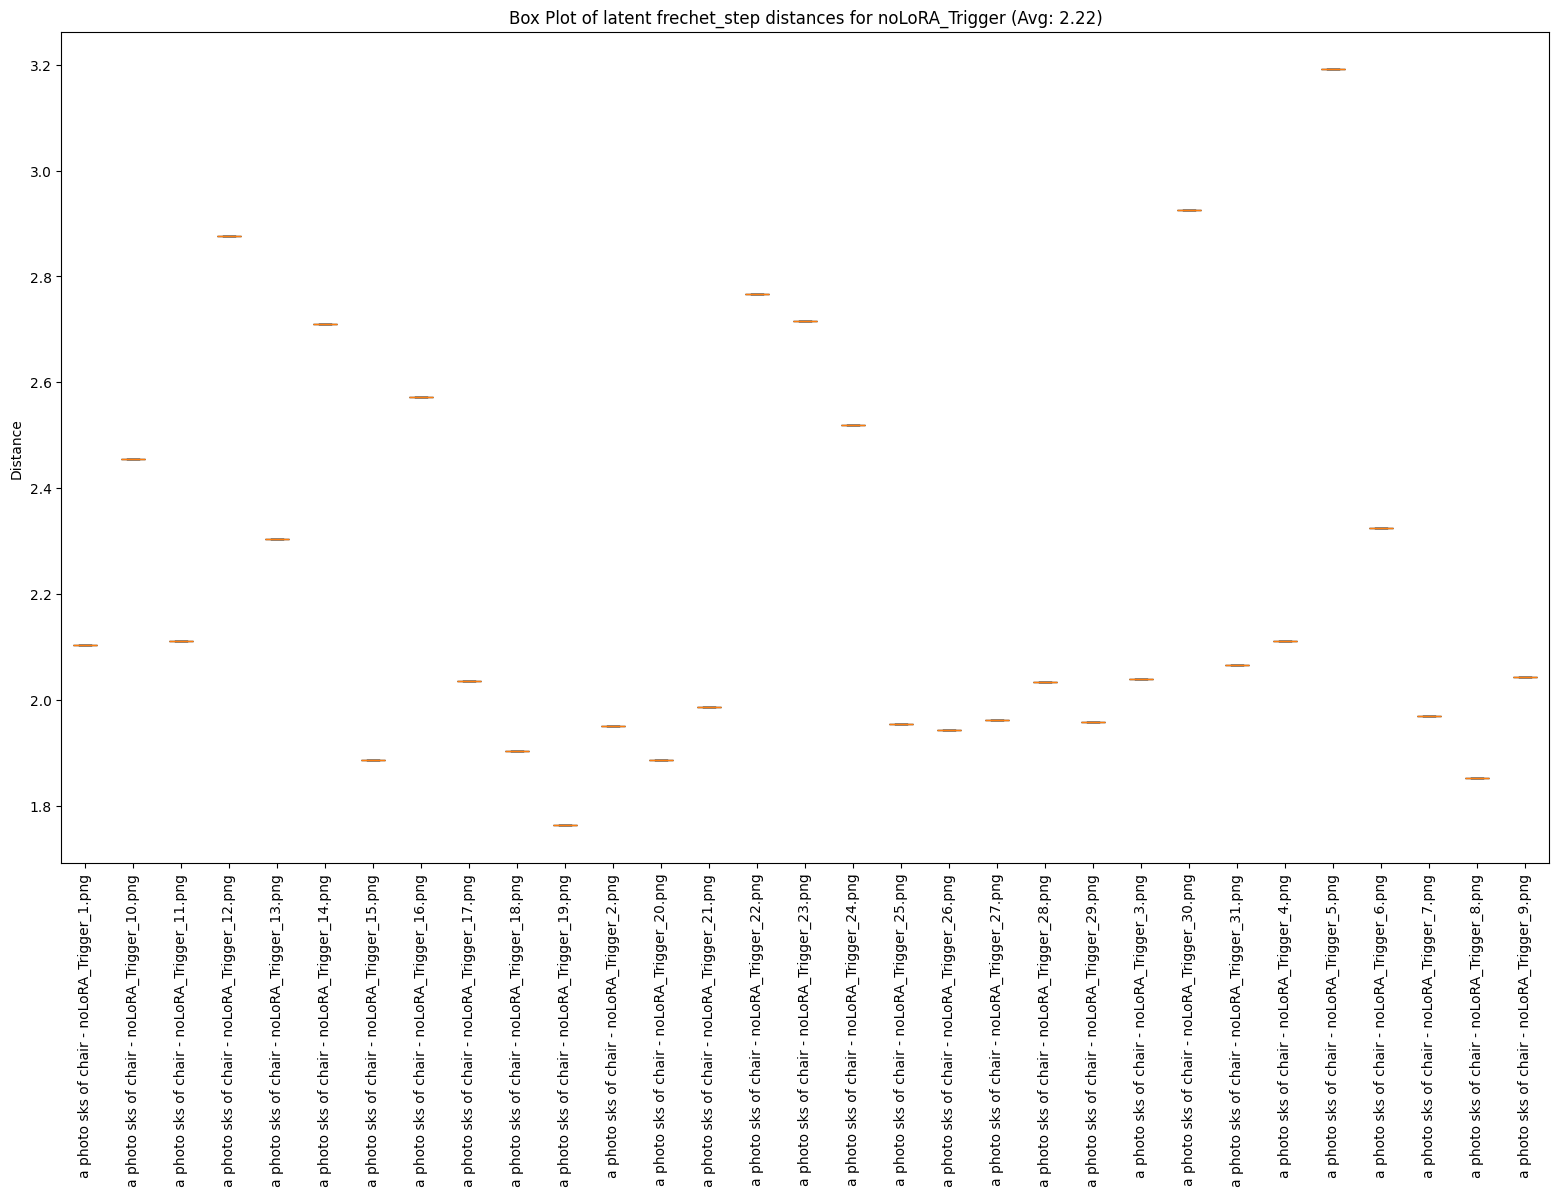

Processing prefix: training
Number of boxes: 24, Number of labels: 24


C:\Users\user\AppData\Local\Temp\ipykernel_15632\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


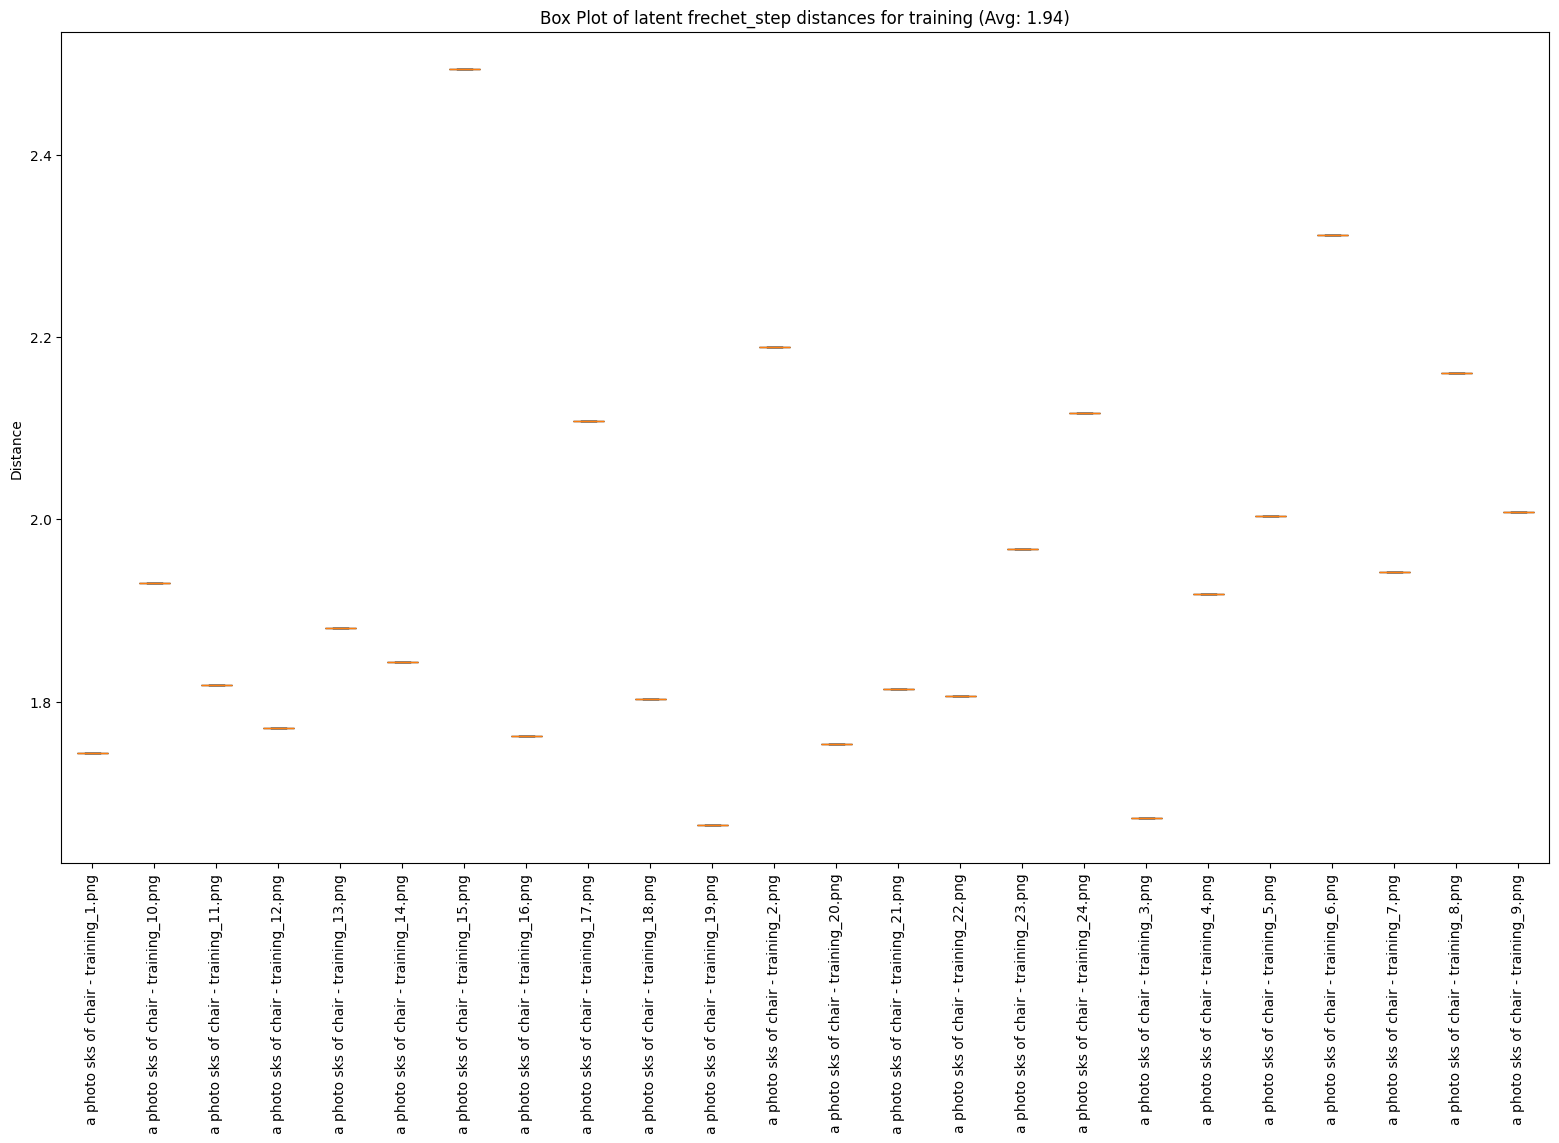

Processing prefix: LoRA_Trigger
Number of boxes: 31, Number of labels: 31


C:\Users\user\AppData\Local\Temp\ipykernel_15632\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


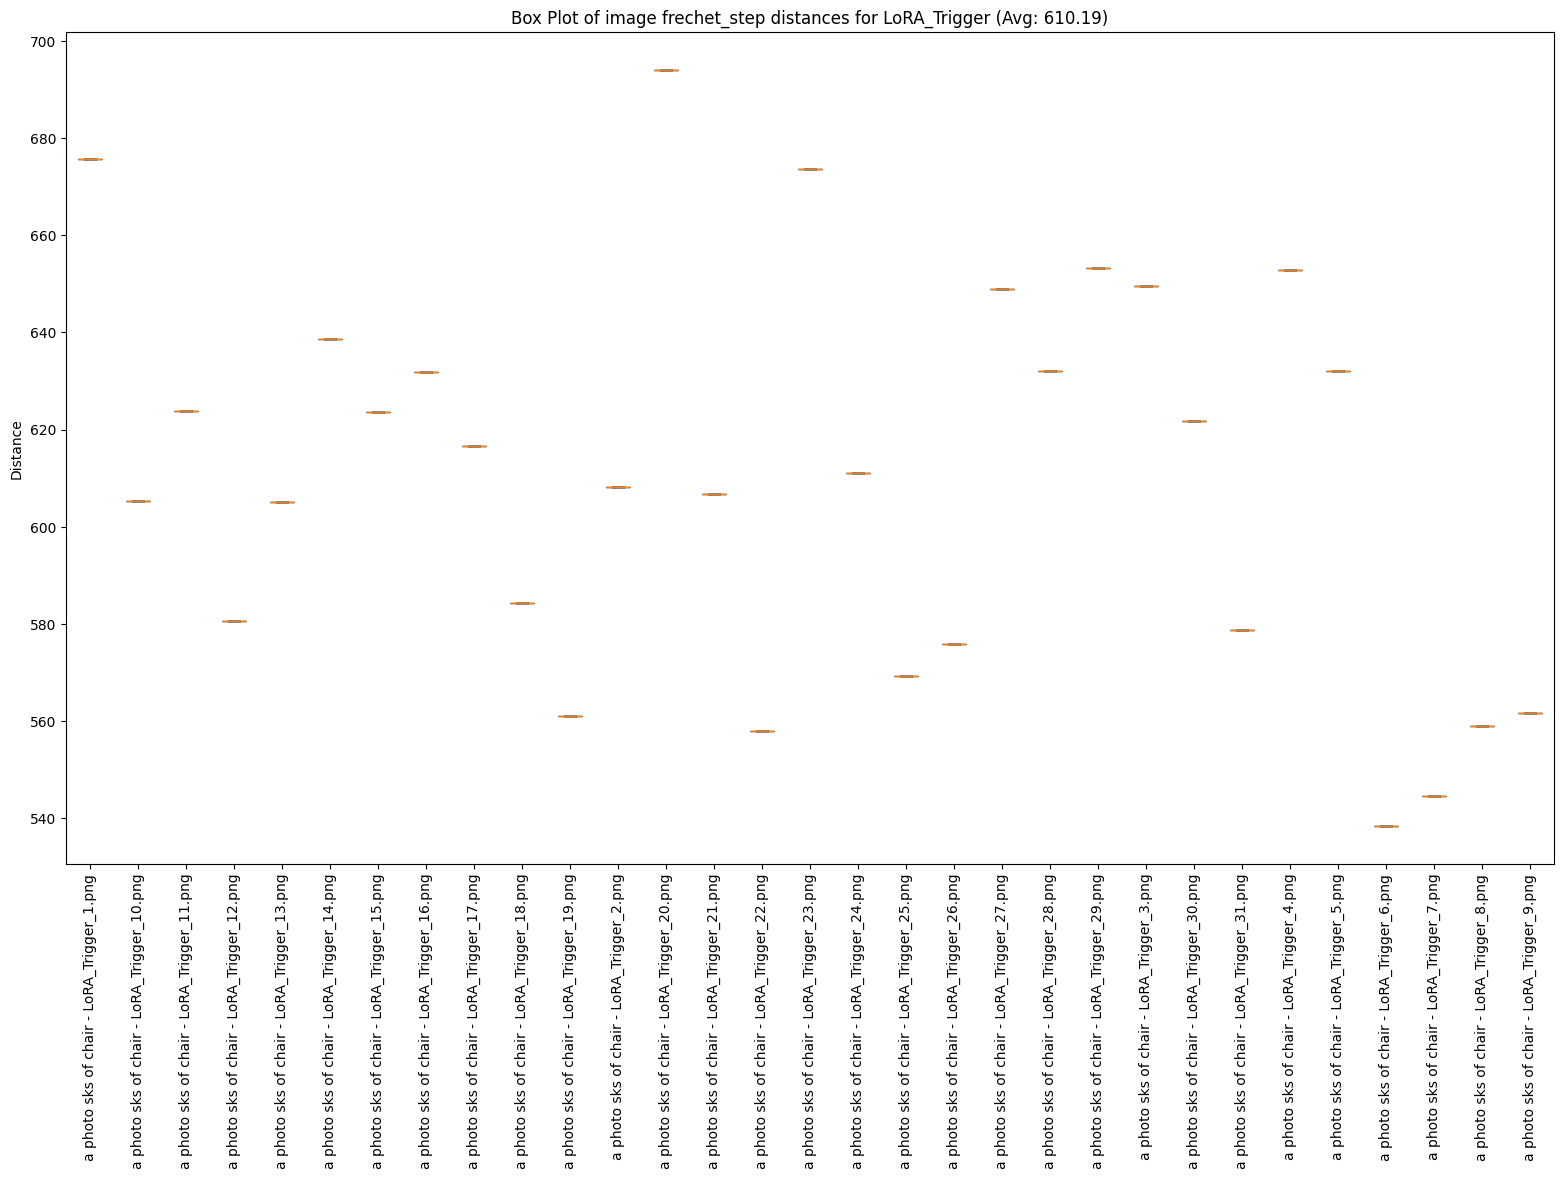

Processing prefix: noLoRA_Trigger
Number of boxes: 31, Number of labels: 31


C:\Users\user\AppData\Local\Temp\ipykernel_15632\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


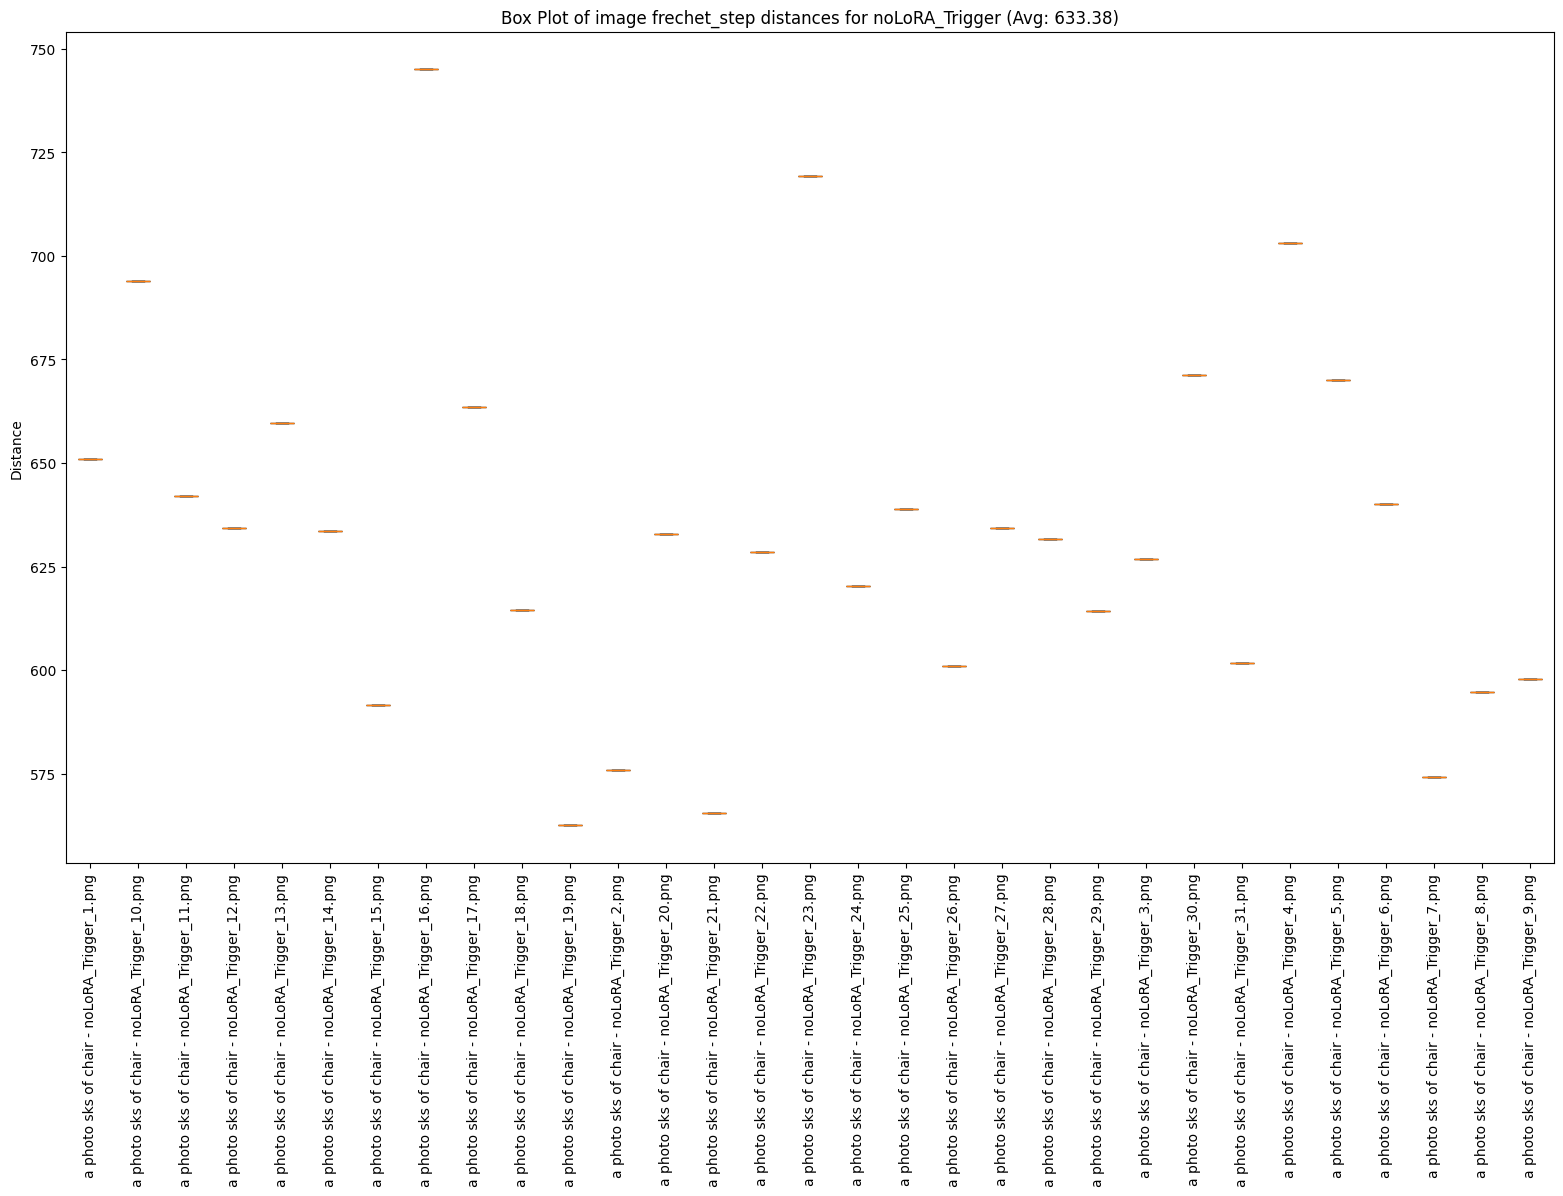

Processing prefix: training
Number of boxes: 24, Number of labels: 24


C:\Users\user\AppData\Local\Temp\ipykernel_15632\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


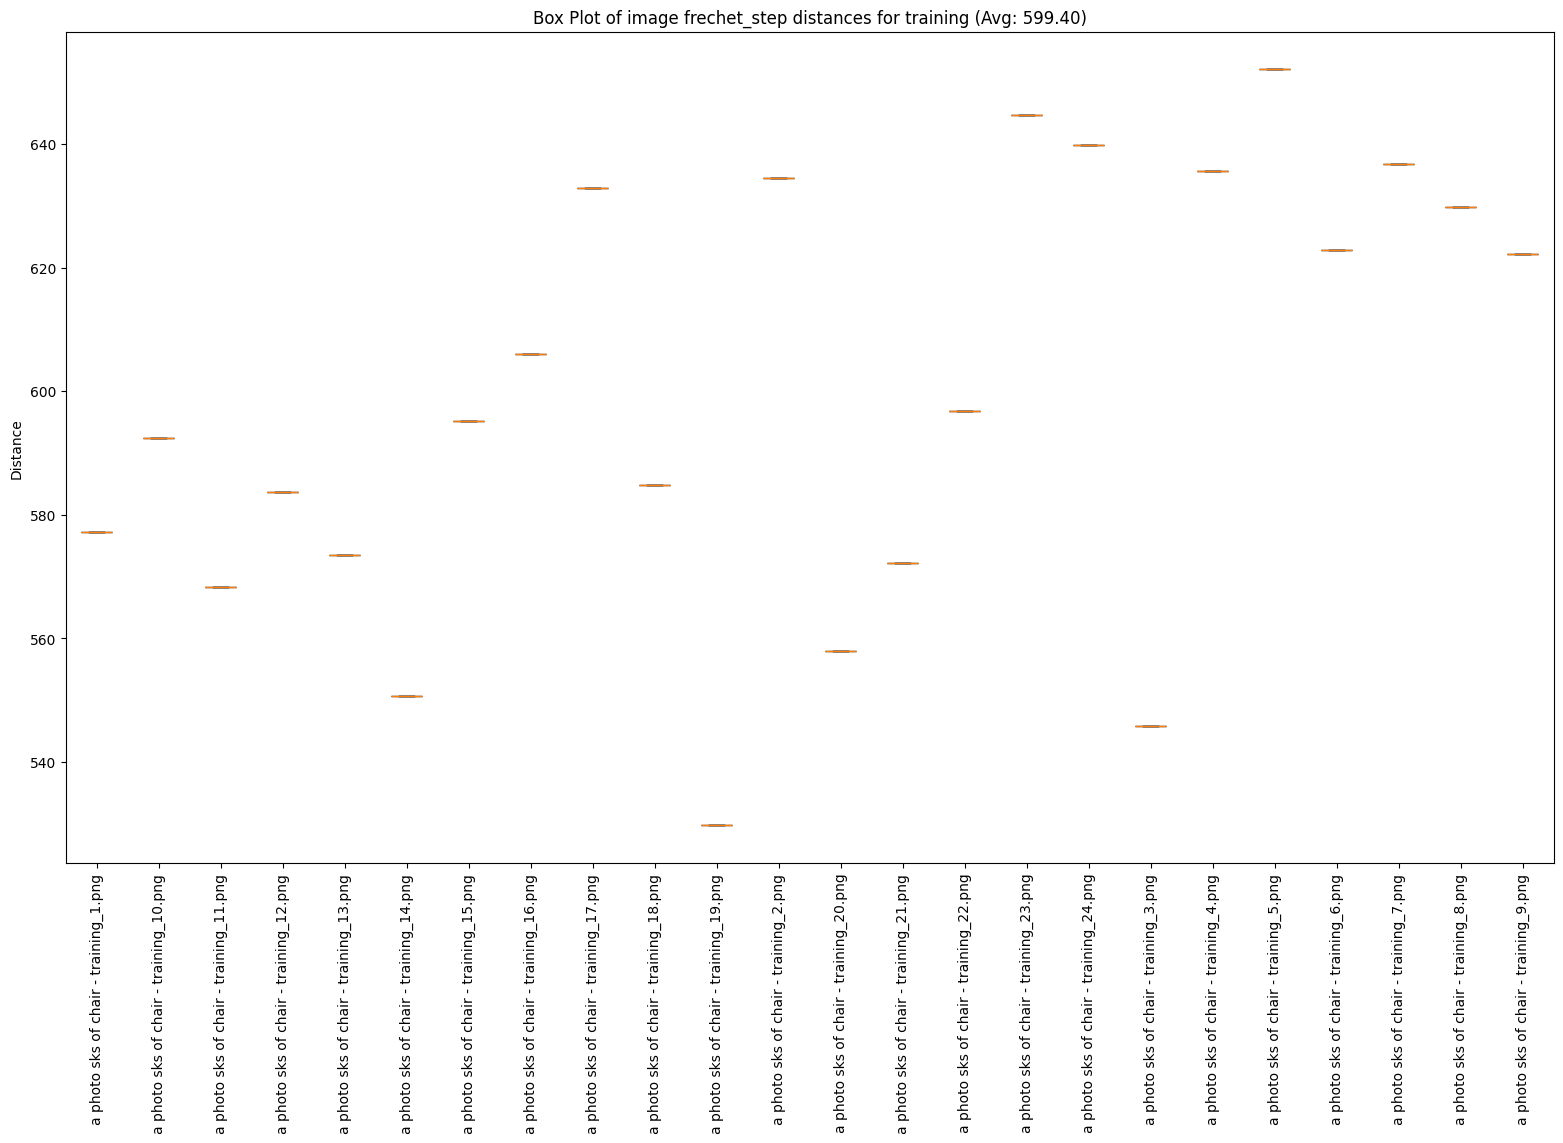

Processing prefix: LoRA_Trigger
Number of boxes: 31, Number of labels: 31


C:\Users\user\AppData\Local\Temp\ipykernel_15632\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


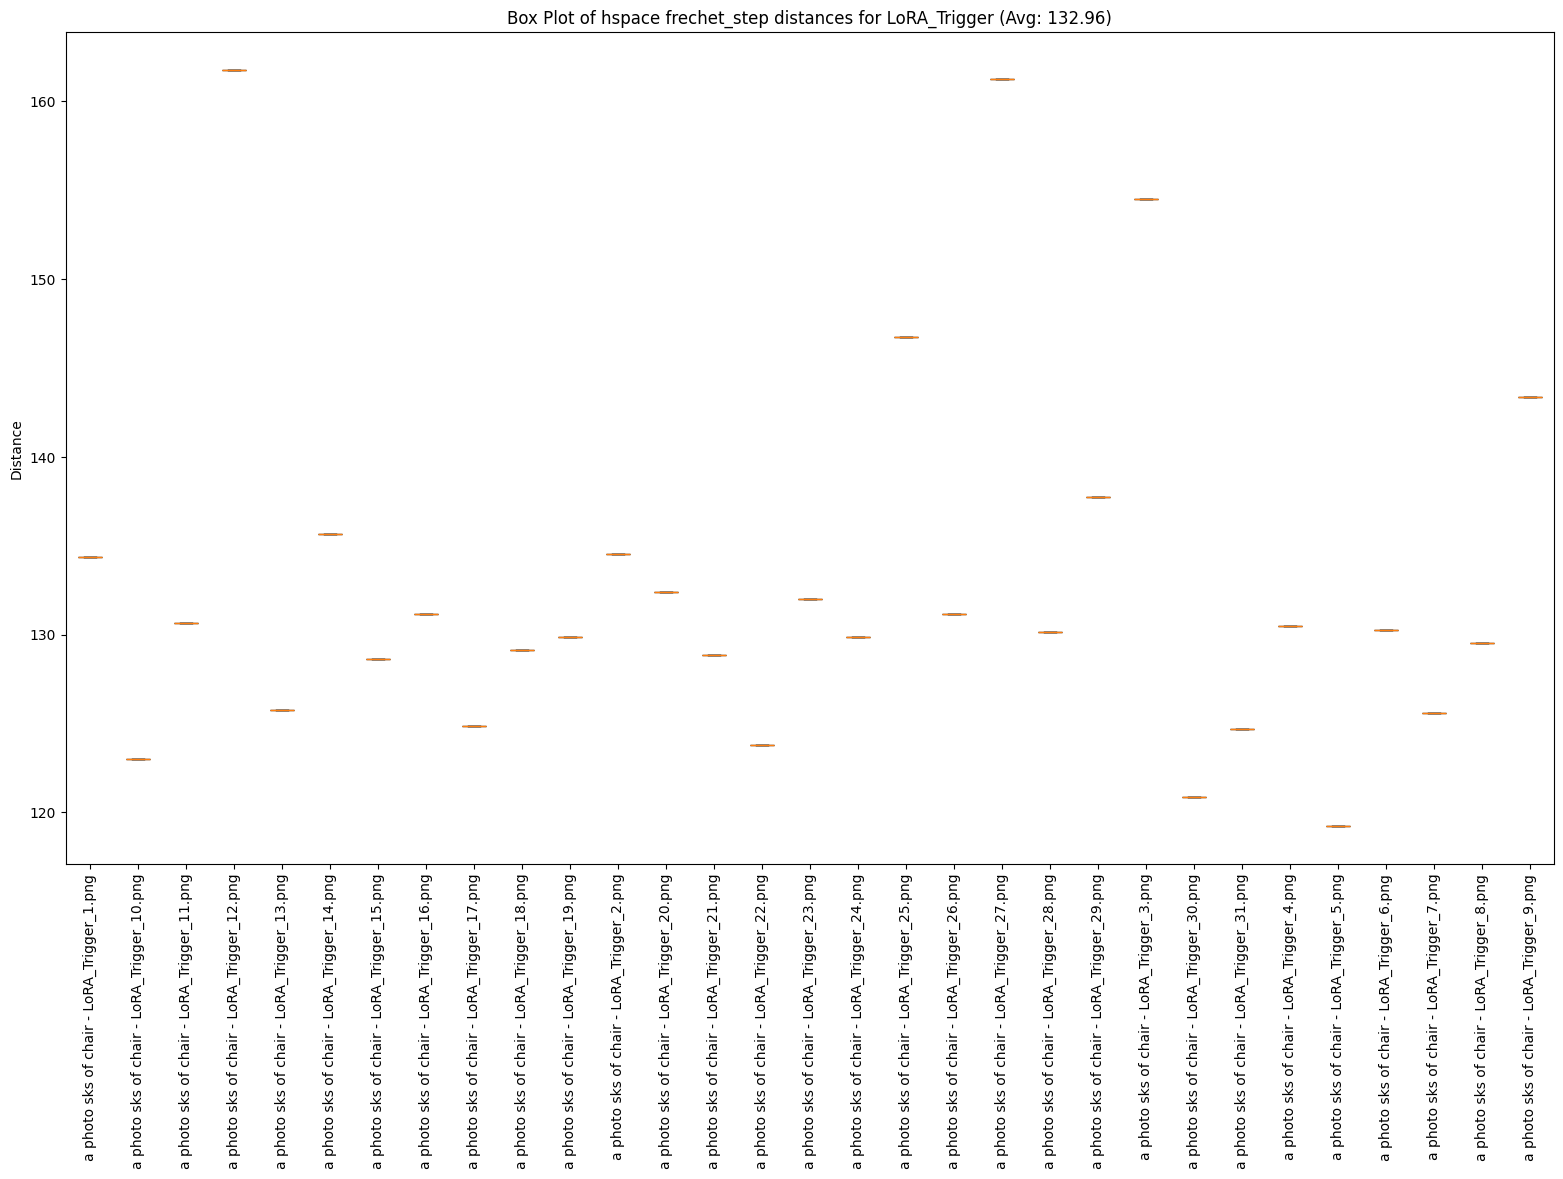

Processing prefix: noLoRA_Trigger
Number of boxes: 31, Number of labels: 31


C:\Users\user\AppData\Local\Temp\ipykernel_15632\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


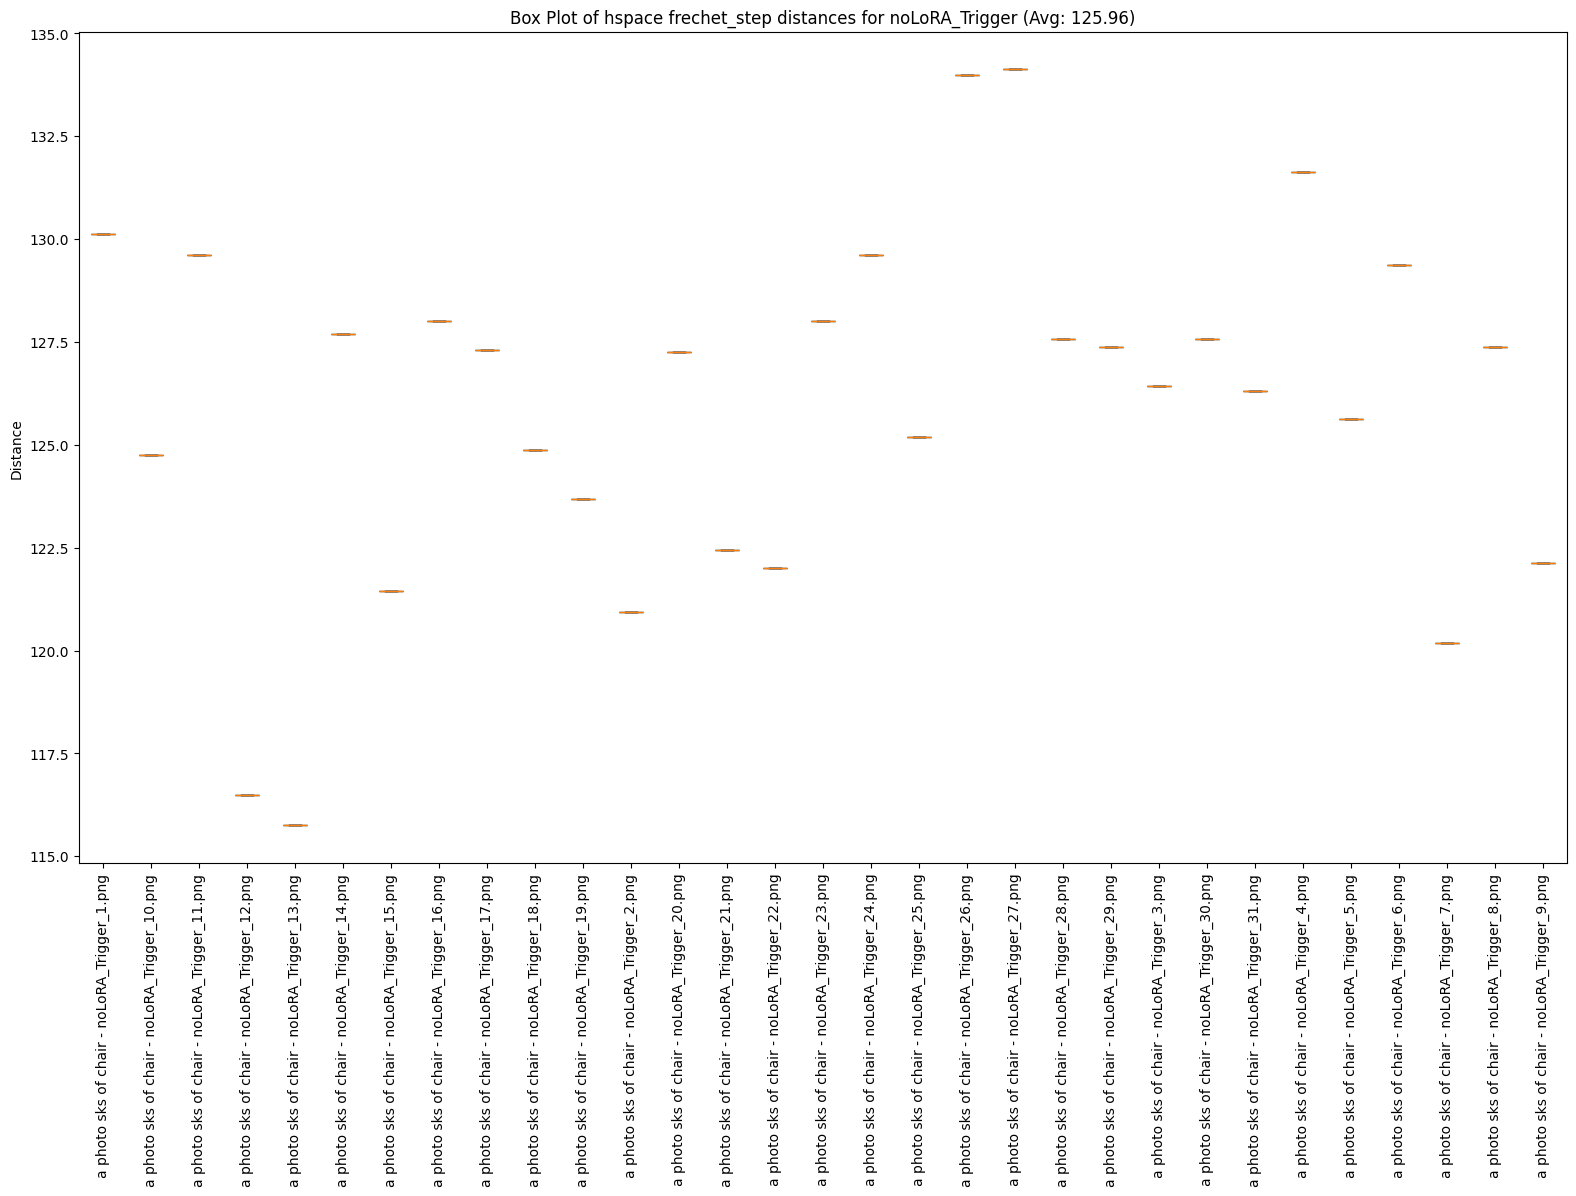

Processing prefix: training
Number of boxes: 24, Number of labels: 24


C:\Users\user\AppData\Local\Temp\ipykernel_15632\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


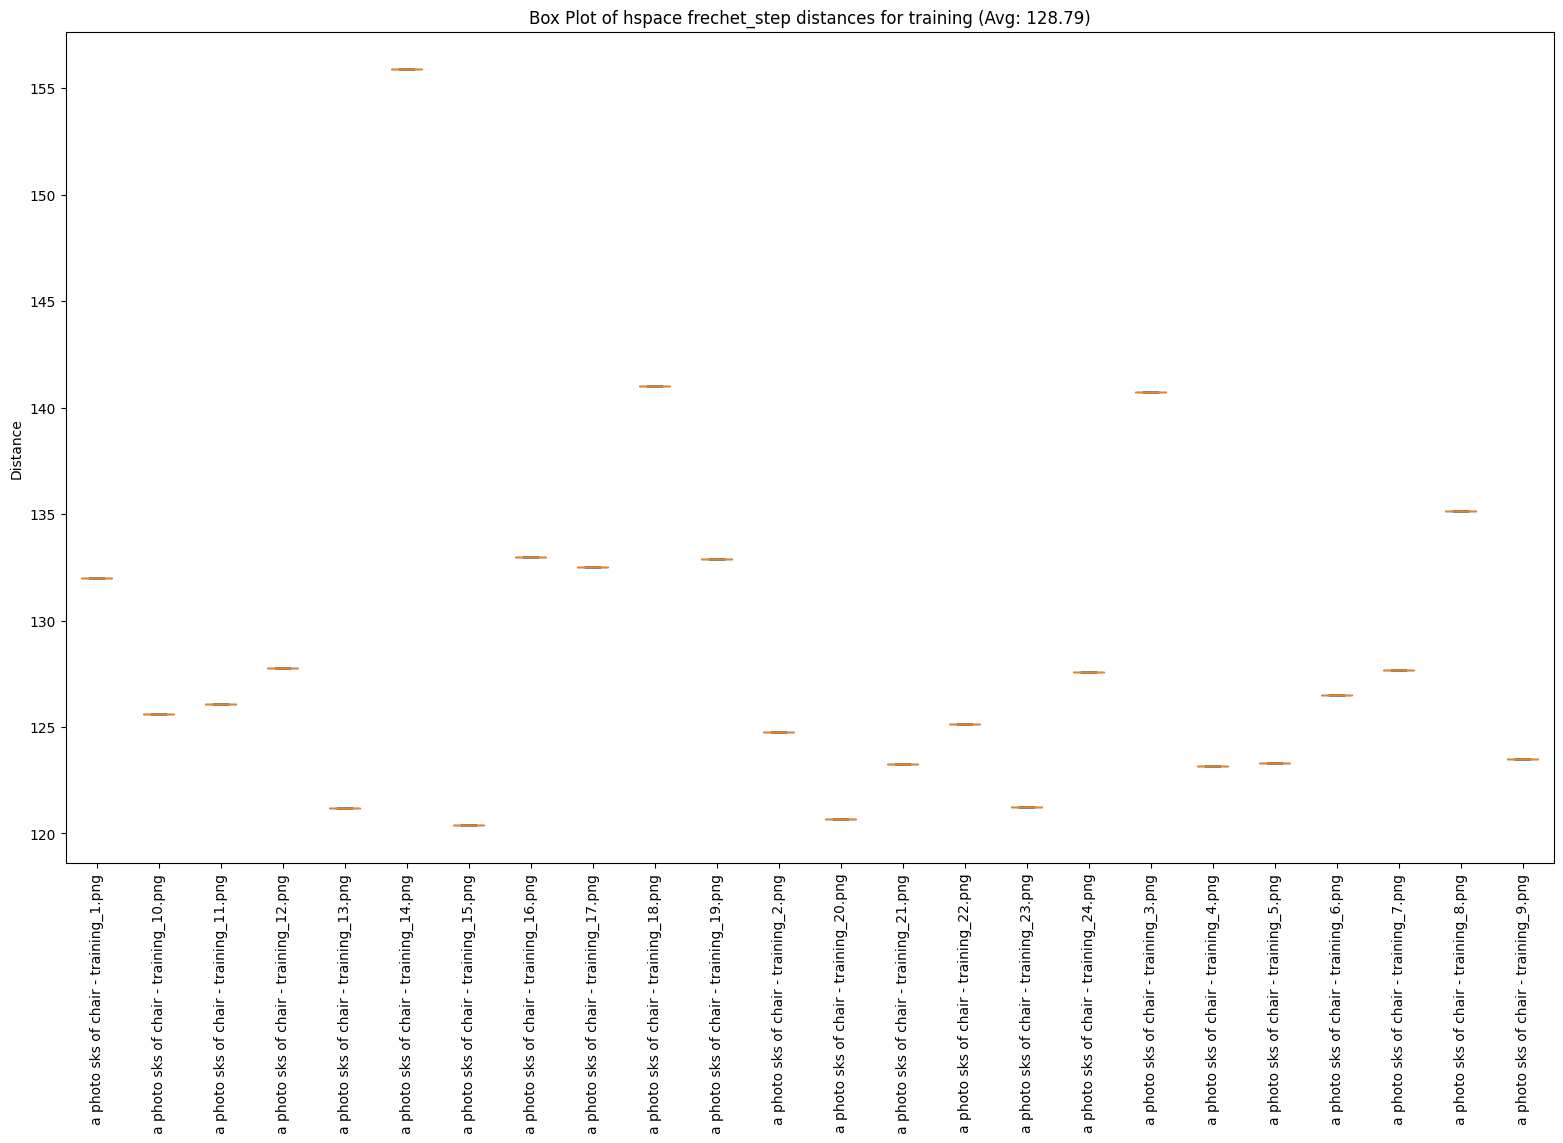

Processing prefix: LoRA_Trigger
Number of boxes: 31, Number of labels: 31


C:\Users\user\AppData\Local\Temp\ipykernel_15632\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


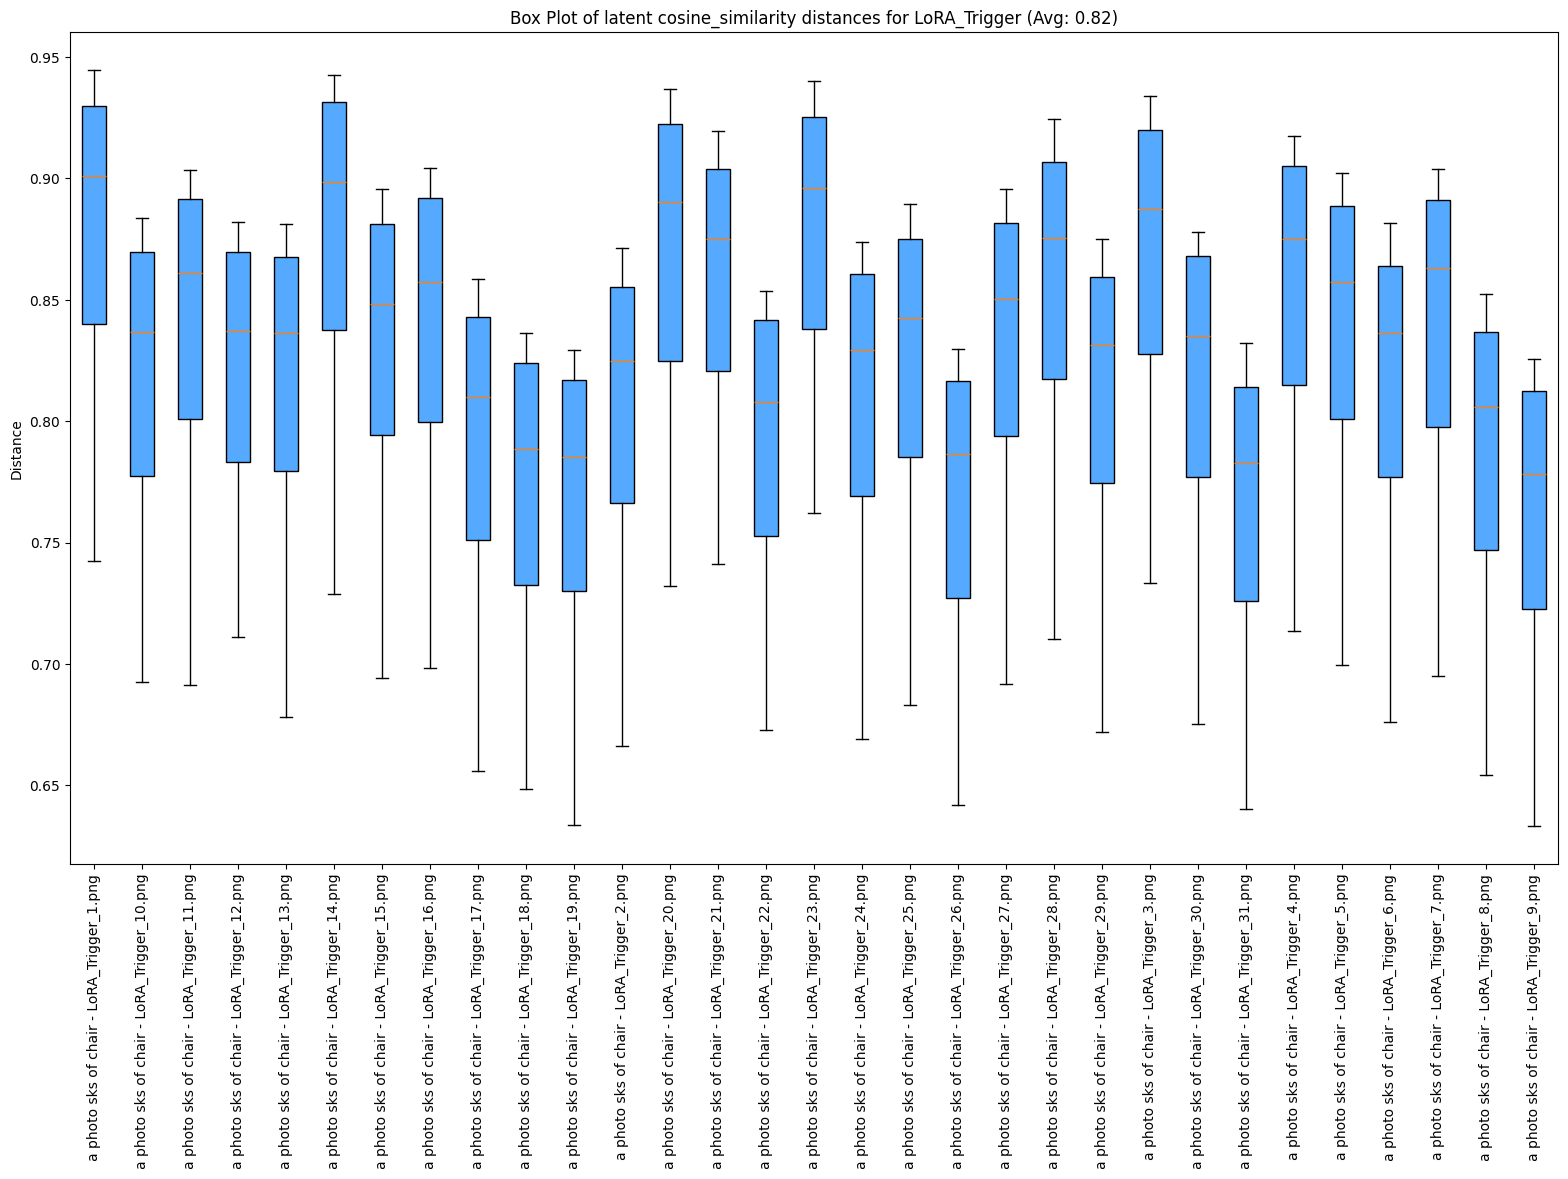

Processing prefix: noLoRA_Trigger
Number of boxes: 31, Number of labels: 31


C:\Users\user\AppData\Local\Temp\ipykernel_15632\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


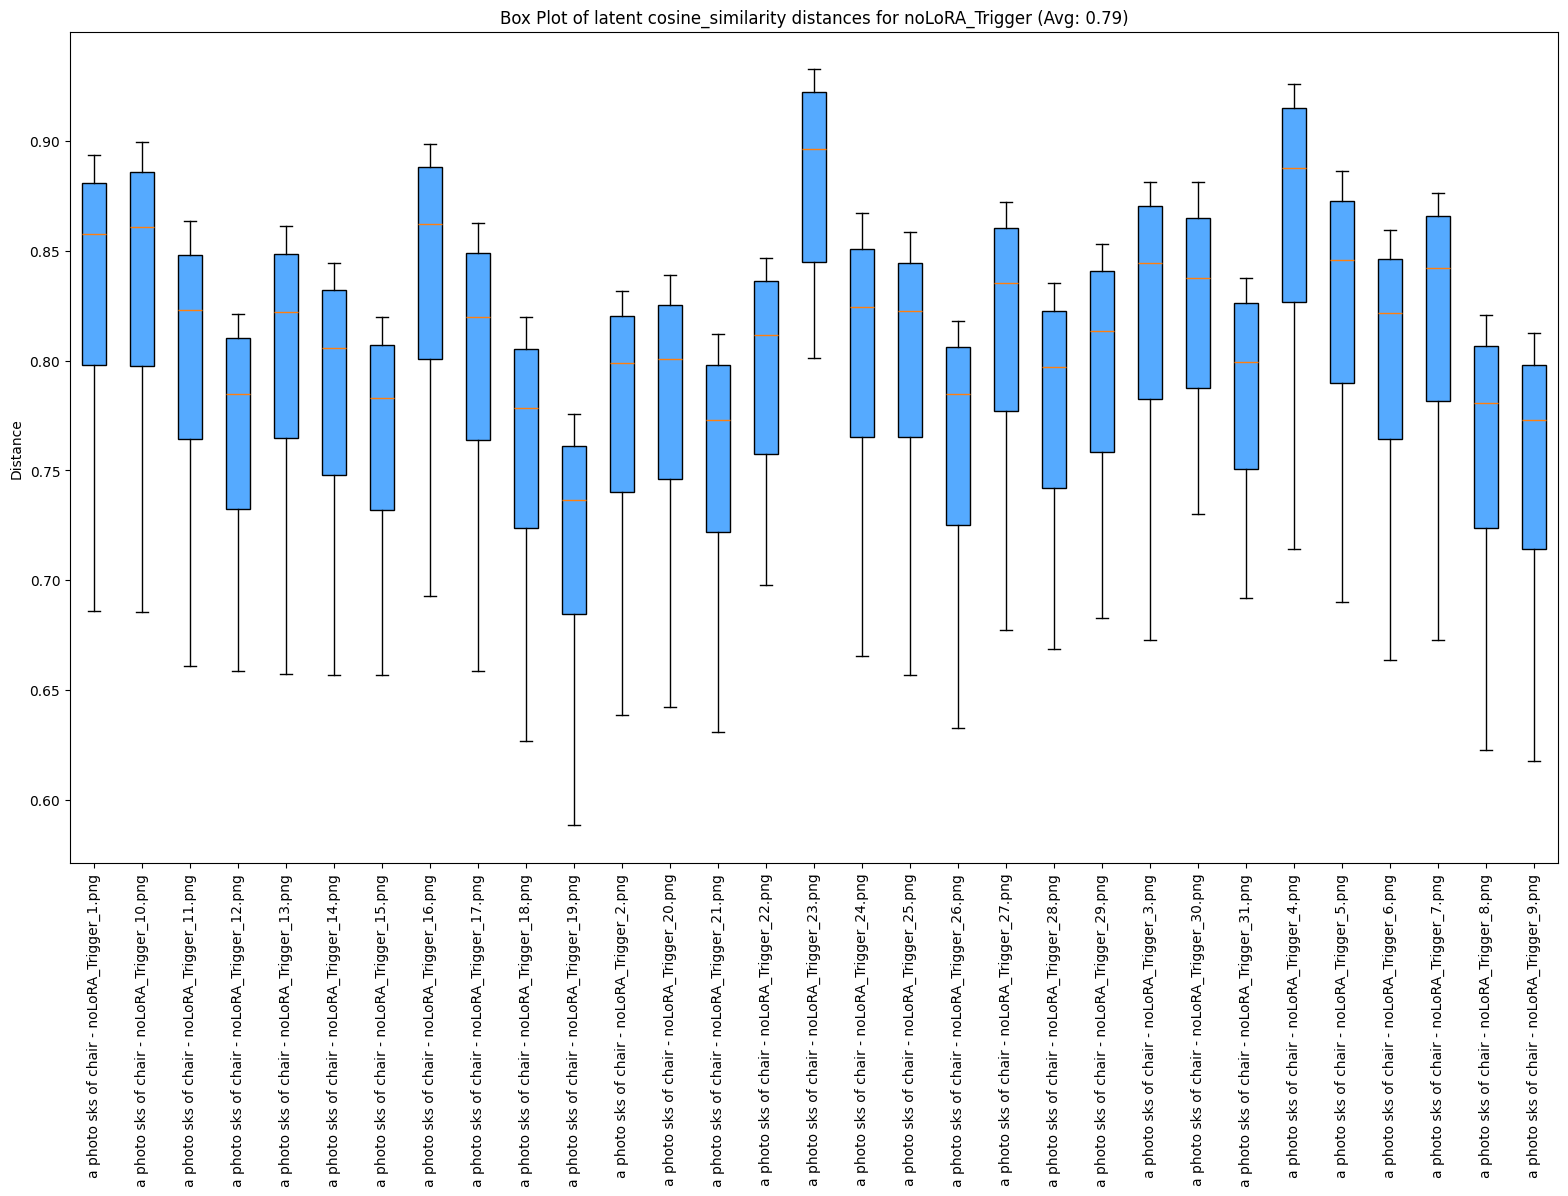

Processing prefix: training
Number of boxes: 24, Number of labels: 24


C:\Users\user\AppData\Local\Temp\ipykernel_15632\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


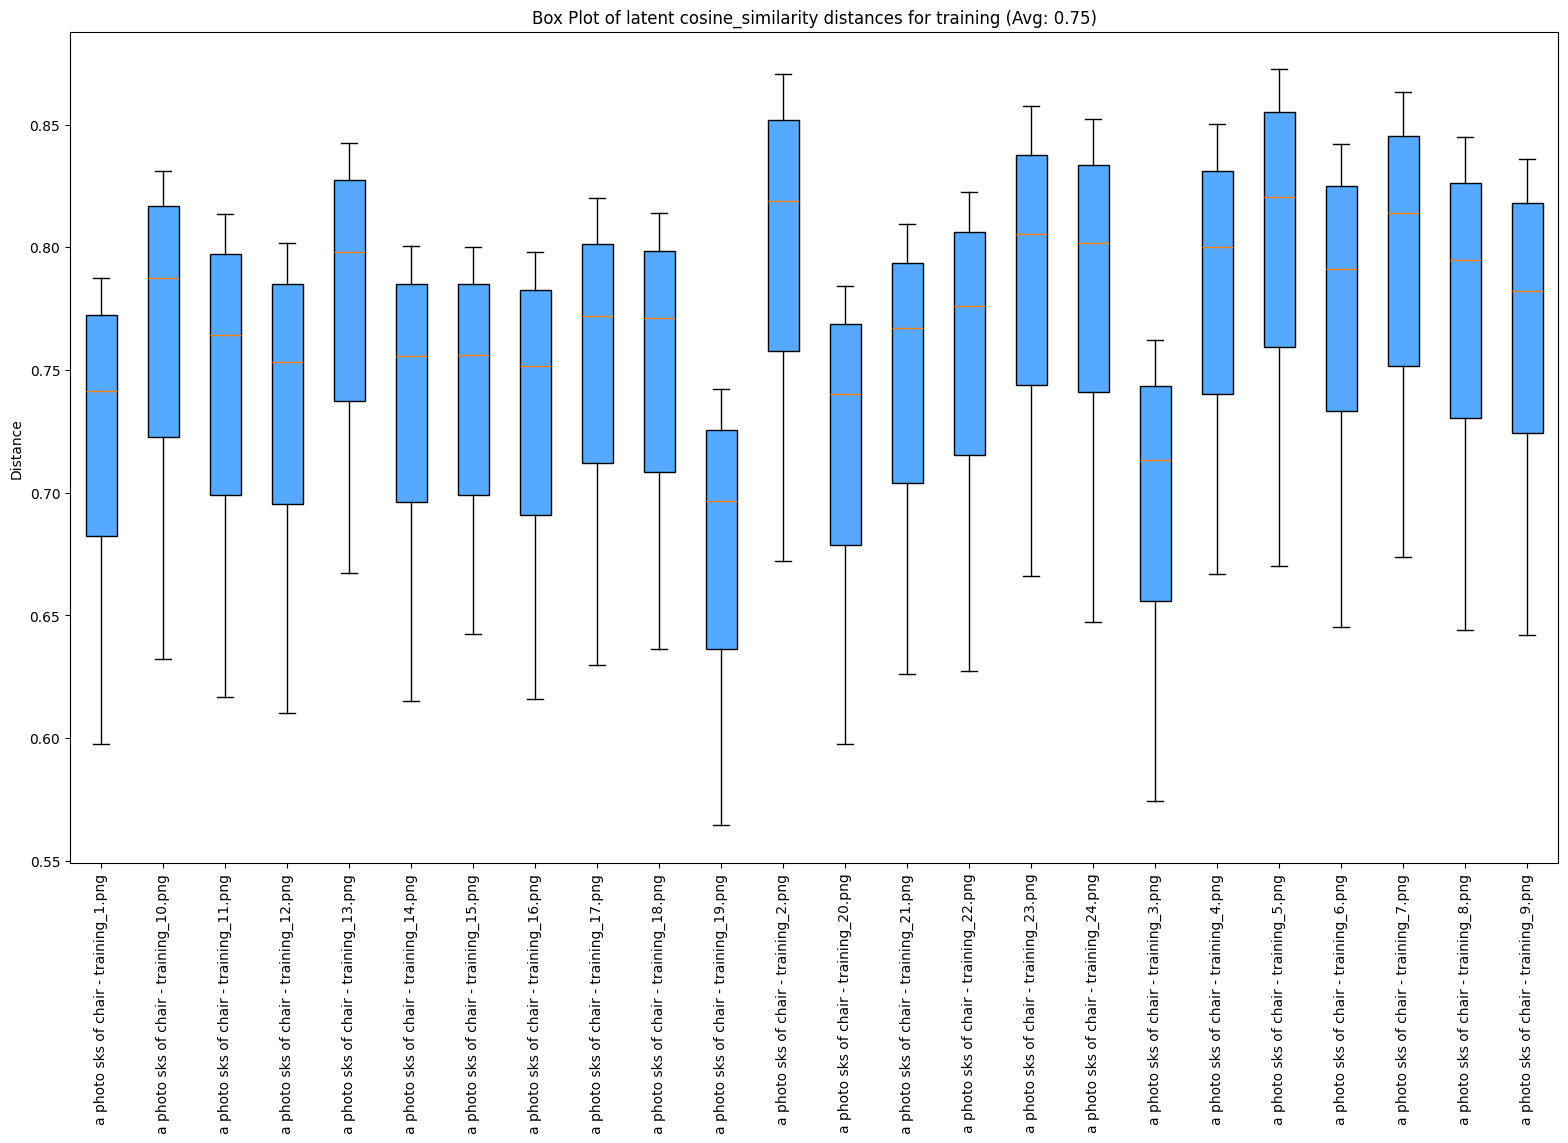

Processing prefix: LoRA_Trigger
Number of boxes: 31, Number of labels: 31


C:\Users\user\AppData\Local\Temp\ipykernel_15632\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


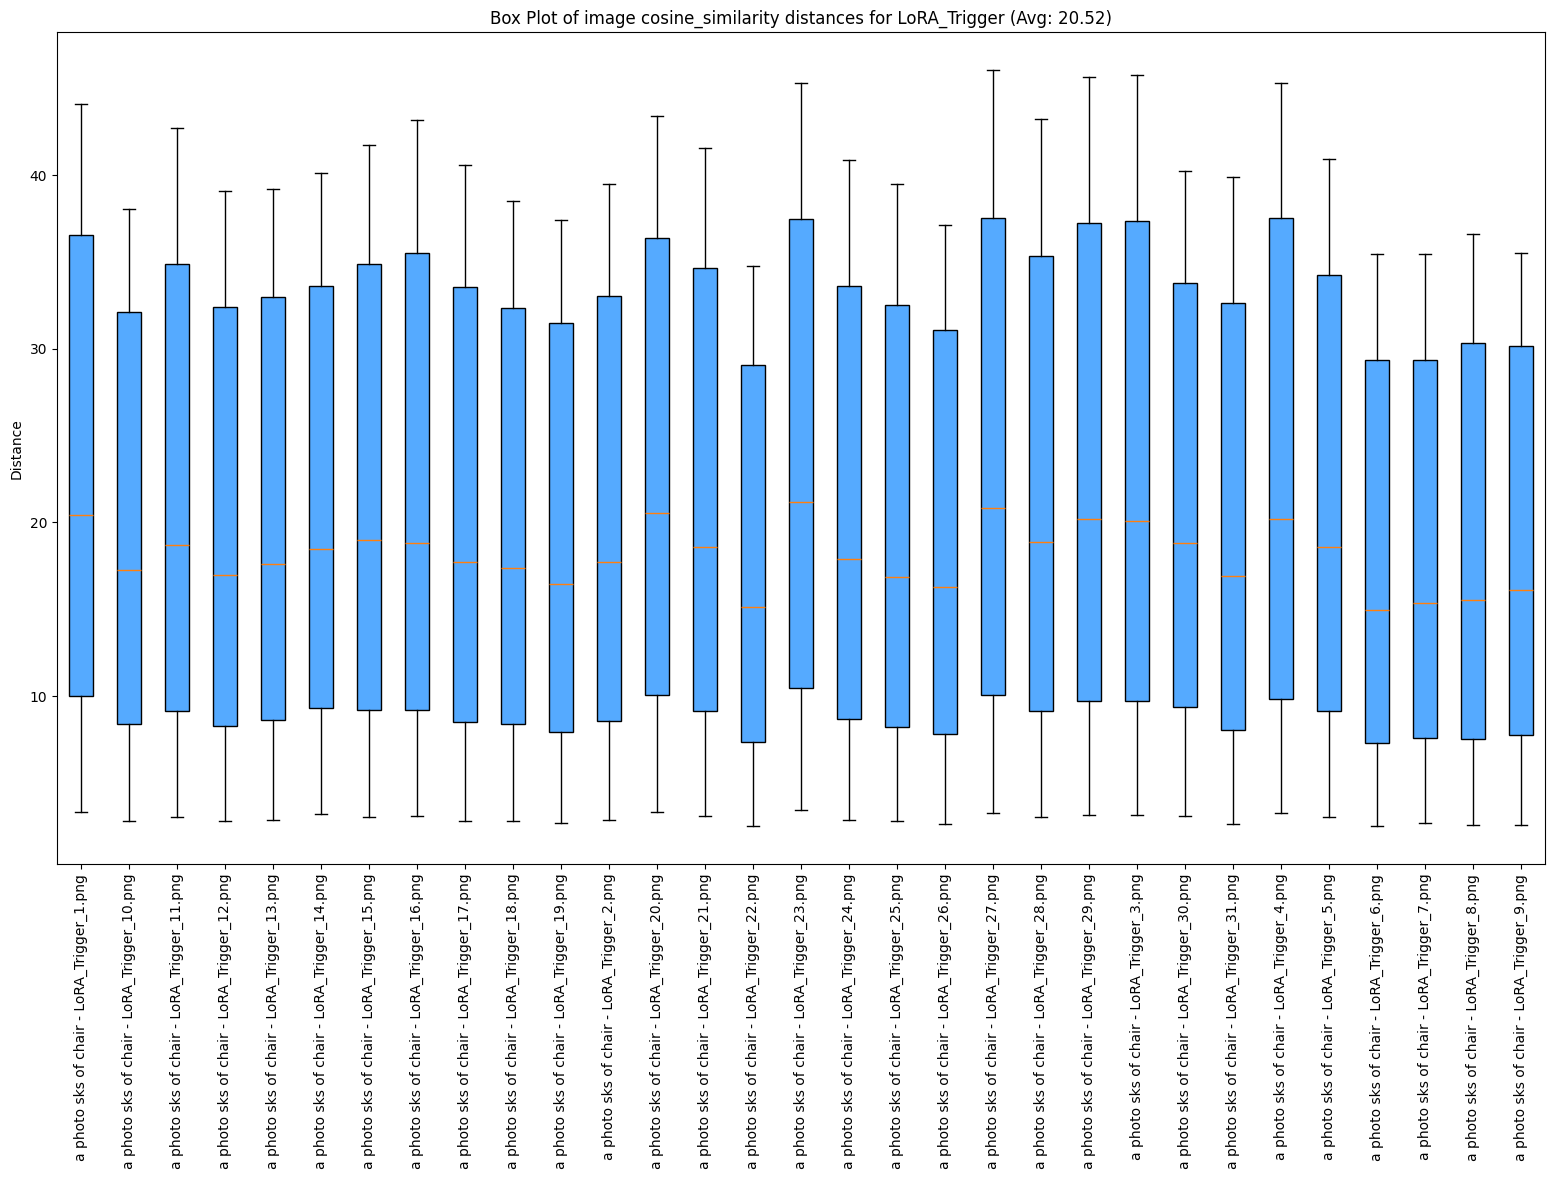

Processing prefix: noLoRA_Trigger
Number of boxes: 31, Number of labels: 31


C:\Users\user\AppData\Local\Temp\ipykernel_15632\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


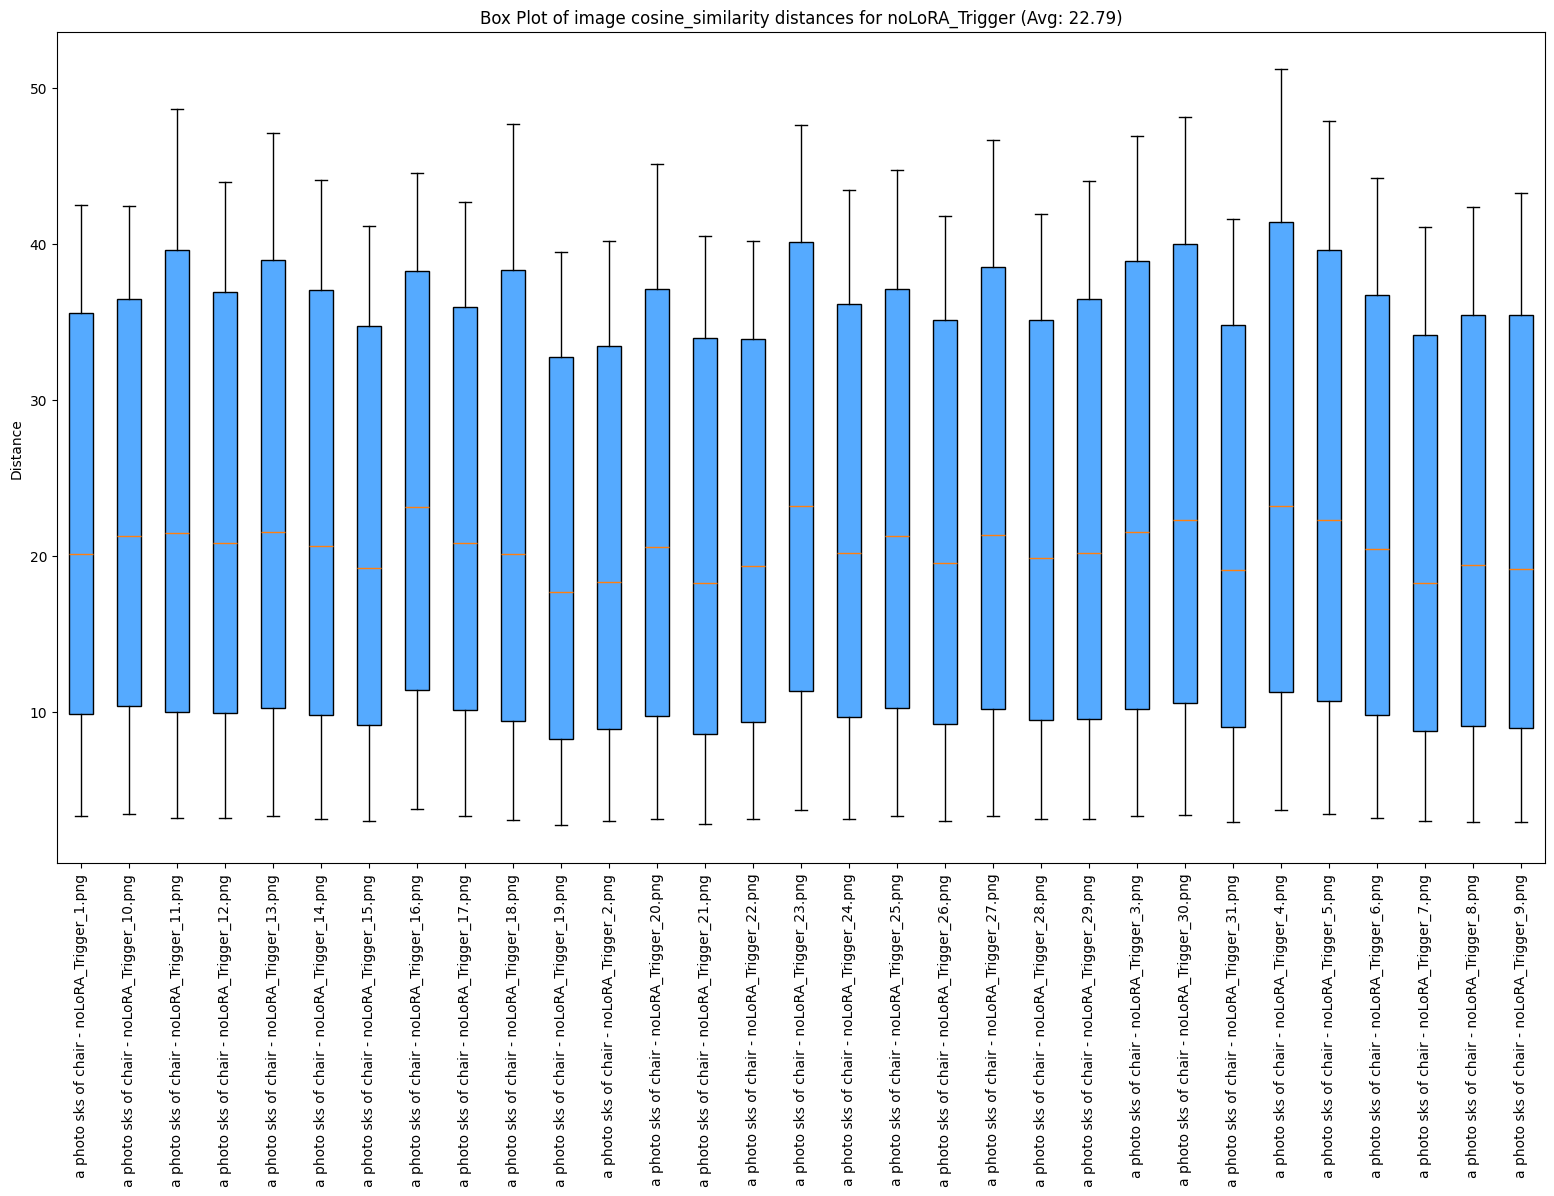

Processing prefix: training
Number of boxes: 24, Number of labels: 24


C:\Users\user\AppData\Local\Temp\ipykernel_15632\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


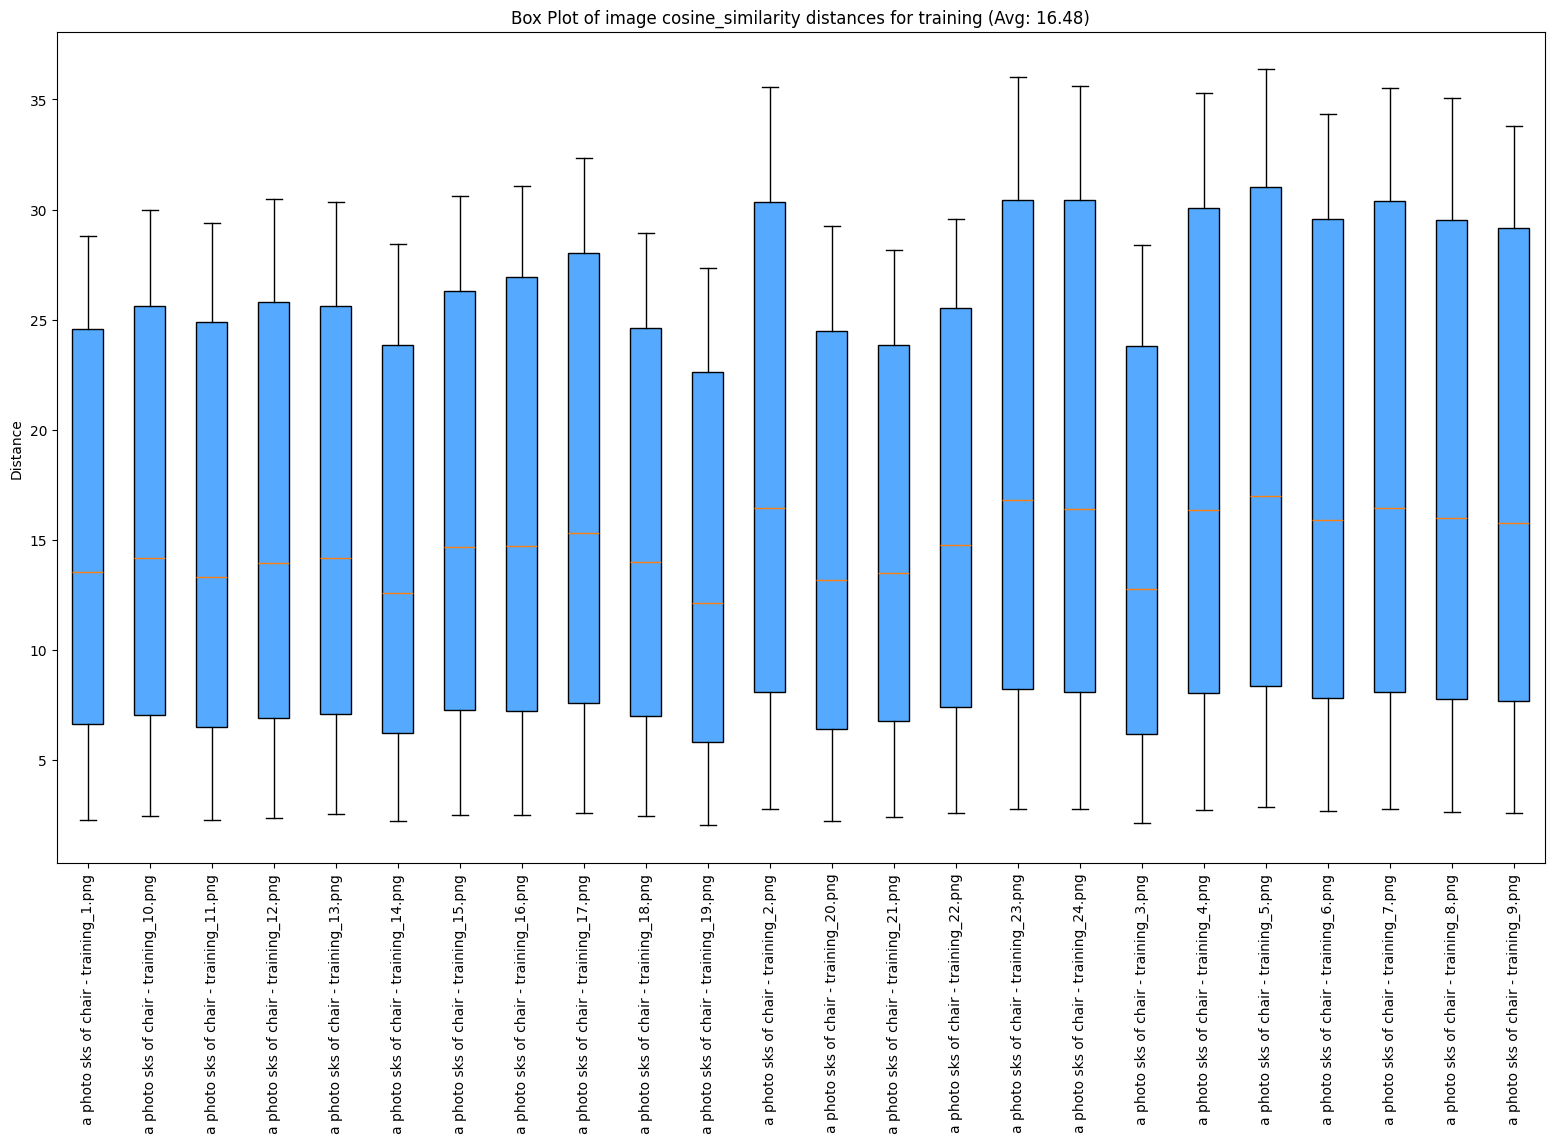

C:\Users\user\AppData\Local\Temp\ipykernel_15632\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


Processing prefix: LoRA_Trigger
Number of boxes: 31, Number of labels: 31


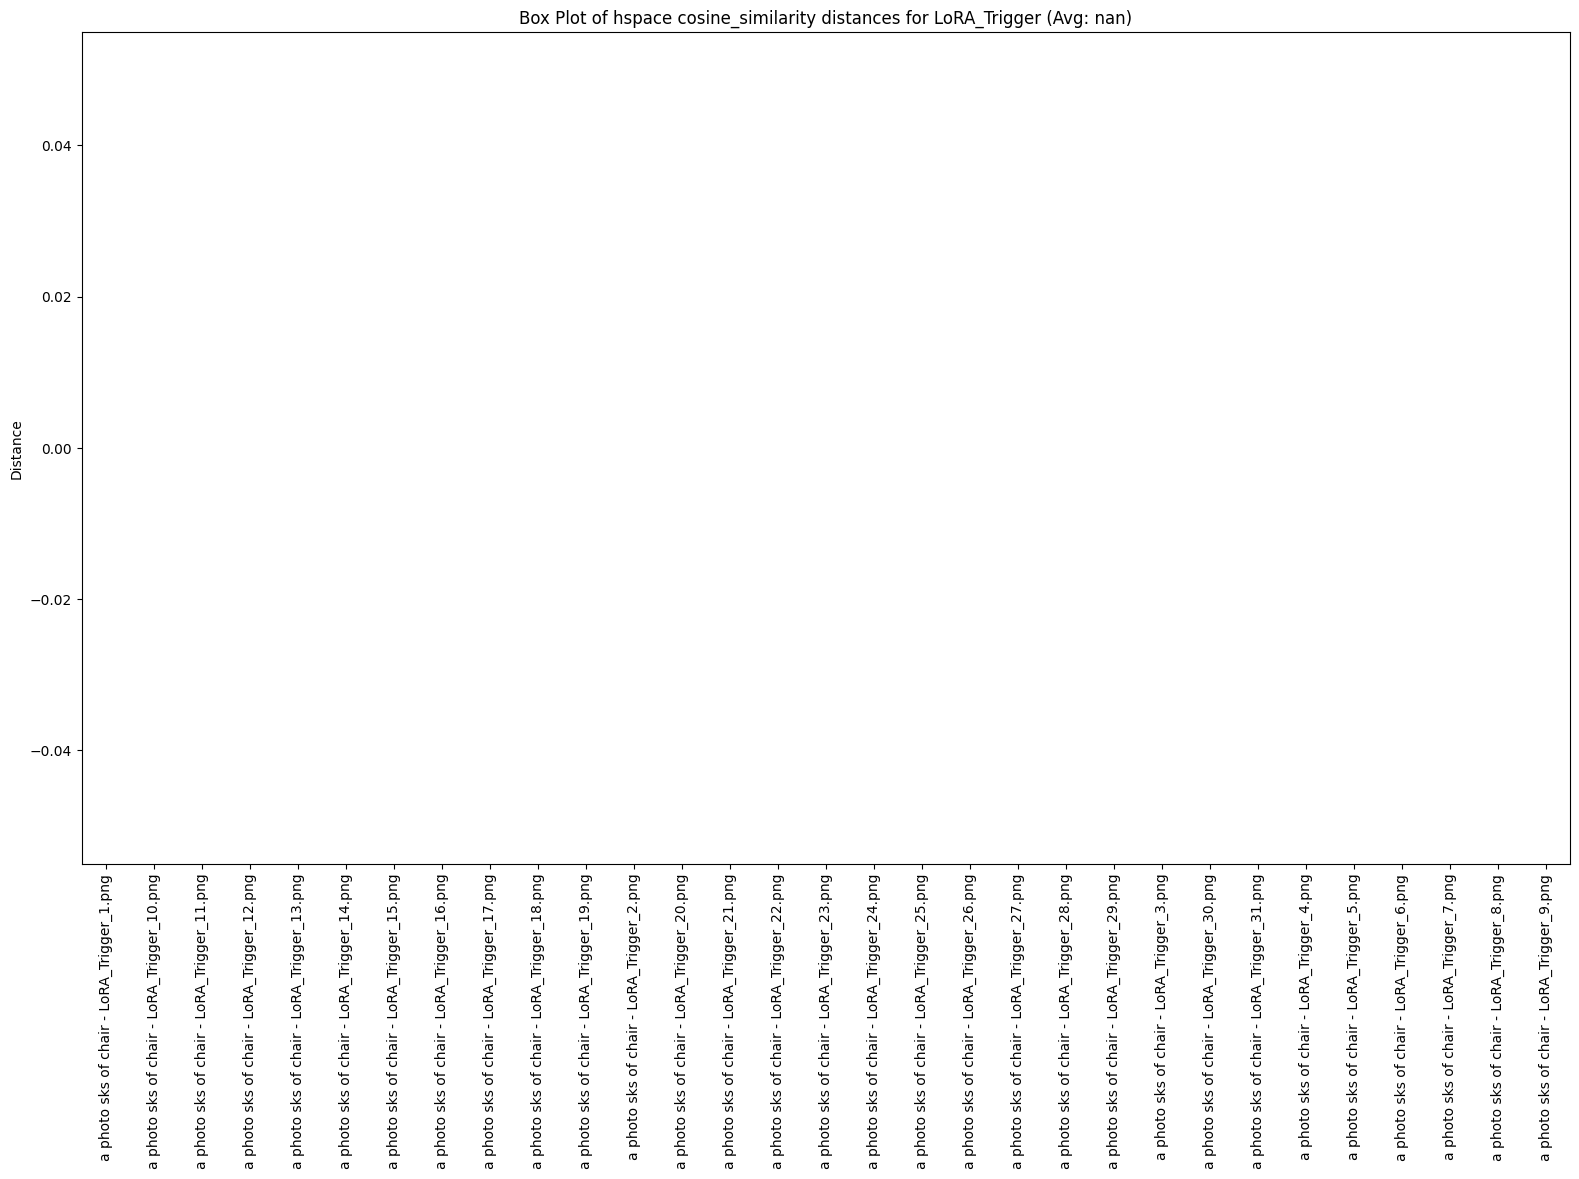

Processing prefix: noLoRA_Trigger
Number of boxes: 31, Number of labels: 31


C:\Users\user\AppData\Local\Temp\ipykernel_15632\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


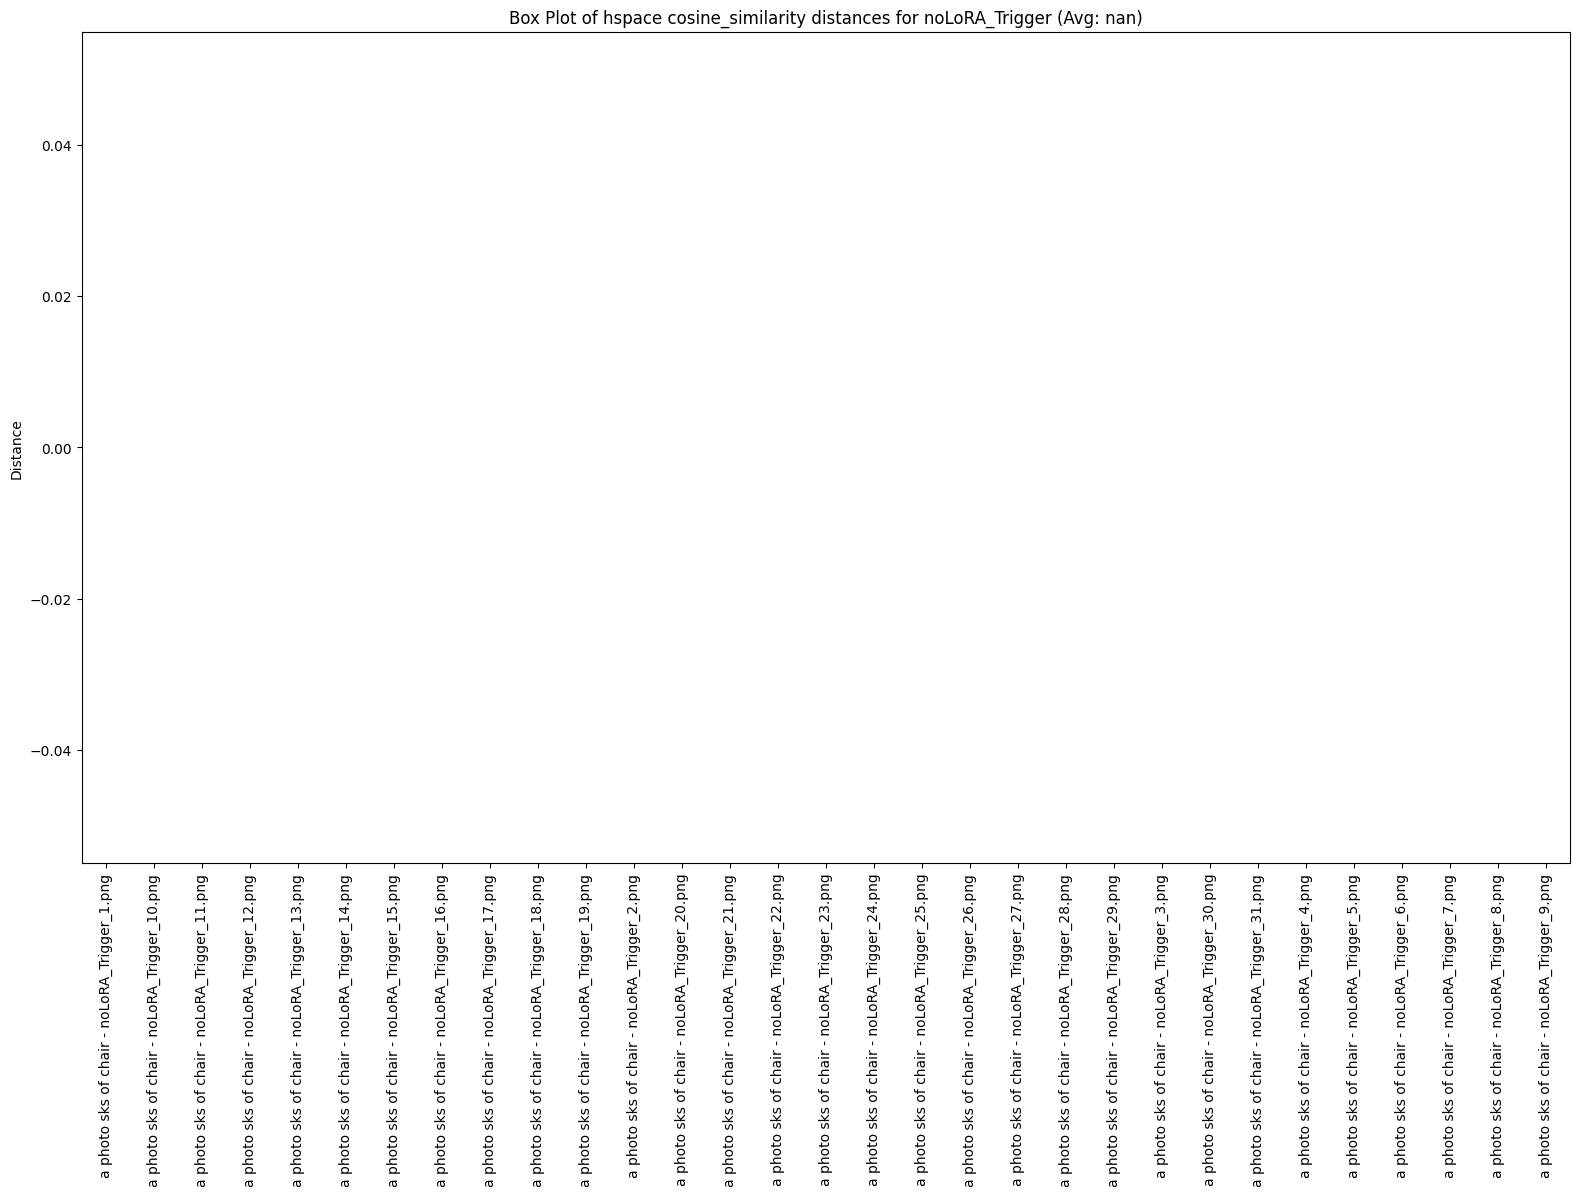

Processing prefix: training
Number of boxes: 24, Number of labels: 24


C:\Users\user\AppData\Local\Temp\ipykernel_15632\2715874074.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


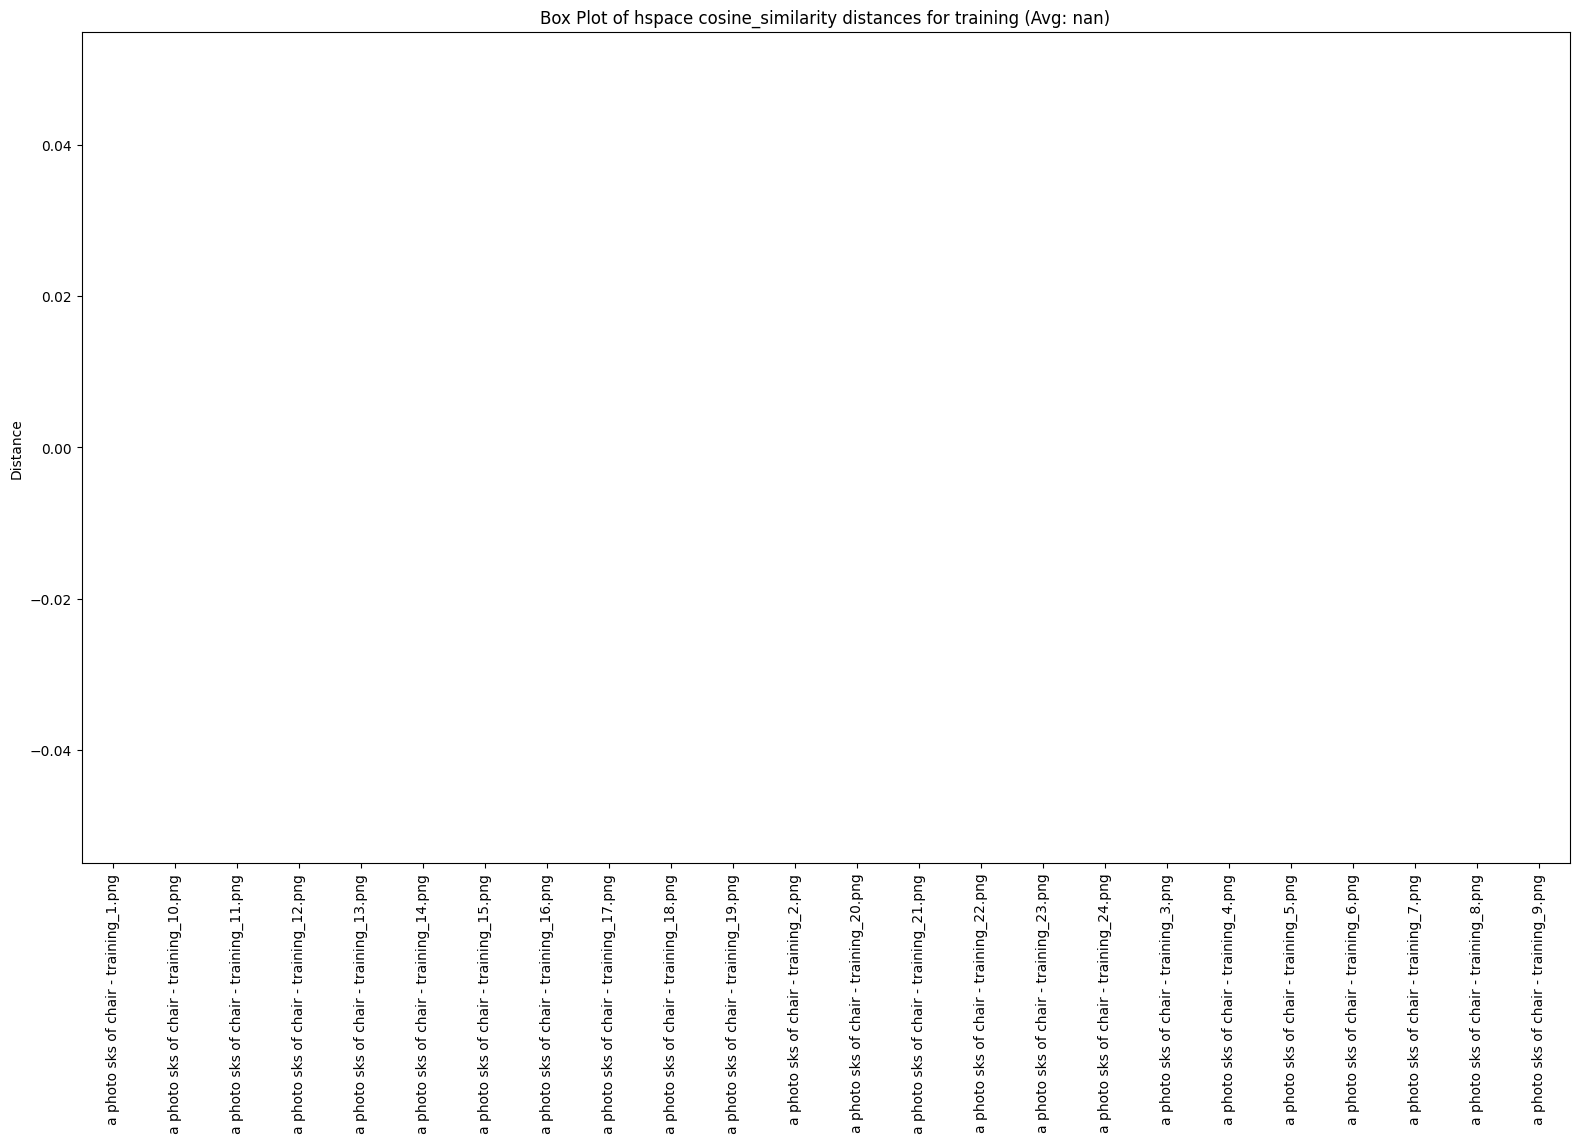

In [19]:

# plot L1 distance
plot_boxplot(anaysis_data["L1_step"], 'latent', "L1_step")
plot_boxplot(anaysis_data["L1_step"], 'image', "L1_step")
plot_boxplot(anaysis_data["L1_step"], 'hspace', "L1_step")

# plot frechet distance
plot_boxplot(anaysis_data["frechet_step"], 'latent', "frechet_step")
plot_boxplot(anaysis_data["frechet_step"], 'image', "frechet_step")
plot_boxplot(anaysis_data["frechet_step"], 'hspace', "frechet_step")

# plot cosine similarity
plot_boxplot(anaysis_data["cosine_similarity"], 'latent', "cosine_similarity")
plot_boxplot(anaysis_data["cosine_similarity"], 'image', "cosine_similarity")
plot_boxplot(anaysis_data["cosine_similarity"], 'hspace', "cosine_similarity")

In [20]:
# see all step as a whole array

# calculate the L2 distance of latent, image, hspace between each image and the first image
# also calculate the L1 distance of hspace between each image and the first image

def calculate_euclidean_distance_whole_together(experiment_data):
    anaysis_data = {}
    for prefix in experiment_data.keys():
        anaysis_data[prefix] = {}
        for prompt in experiment_data[prefix].keys():
            anaysis_data[prefix][prompt] = {}
            first_image_name = ""
            for image_name in experiment_data[prefix][prompt].keys():
                if first_image_name == "":
                    first_image_name = image_name
                    print(first_image_name)
                    continue
                anaysis_data[prefix][prompt][image_name] = {"latent": [], "image": [], "hspace": []}
                for key in ["latent", "image", "hspace"]:
                    distance = euclidean(experiment_data[prefix][prompt][image_name][key].flatten(), experiment_data[prefix][prompt][first_image_name][key].flatten())
                    anaysis_data[prefix][prompt][image_name][key].append(distance)
    return anaysis_data

In [21]:
# calculate the frechet distance of latent, image, hspace between each image and the first image
def calculate_frechet_distance_whole_together(experiment_data):
    anaysis_data = {}
    for prefix in experiment_data.keys():
        anaysis_data[prefix] = {}
        for prompt in experiment_data[prefix].keys():
            anaysis_data[prefix][prompt] = {}
            first_image_name = ""
            for image_name in experiment_data[prefix][prompt].keys():
                if first_image_name == "":
                    first_image_name = image_name
                    print(first_image_name)
                    continue
                anaysis_data[prefix][prompt][image_name] = {"latent": [], "image": [], "hspace": []}
                for key in ["latent", "image", "hspace"]:
                    distance = frechet_distance(experiment_data[prefix][prompt][image_name][key], experiment_data[prefix][prompt][first_image_name][key])
                    anaysis_data[prefix][prompt][image_name][key].append(distance)
    return anaysis_data

In [22]:
# calculate the L1 distance of latent, image, hspace between each image and the first image
def calculate_L1_distance_whole_together(experiment_data):
    anaysis_data = {}
    for prefix in experiment_data.keys():
        anaysis_data[prefix] = {}
        for prompt in experiment_data[prefix].keys():
            anaysis_data[prefix][prompt] = {}
            first_image_name = ""
            for image_name in experiment_data[prefix][prompt].keys():
                if first_image_name == "":
                    first_image_name = image_name
                    print(first_image_name)
                    continue
                anaysis_data[prefix][prompt][image_name] = {"latent": [], "image": [], "hspace": []}
                for key in ["latent", "image", "hspace"]:
                    distance = np.sum(np.abs(experiment_data[prefix][prompt][image_name][key].flatten() - experiment_data[prefix][prompt][first_image_name][key].flatten()))
                    anaysis_data[prefix][prompt][image_name][key].append(distance)
    return anaysis_data


In [23]:
anaysis_data["L2_whole"] = calculate_euclidean_distance_whole_together(experiment_data)
anaysis_data["frechet_whole"] = calculate_frechet_distance_whole_together(experiment_data)
anaysis_data["L1_whole"] = calculate_L1_distance_whole_together(experiment_data)

LoRA_Trigger_0.png
noLoRA_Trigger_0.png
training_0.png
LoRA_Trigger_0.png
noLoRA_Trigger_0.png
training_0.png
LoRA_Trigger_0.png


c:\Users\user\anaconda3\envs\comfy\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


noLoRA_Trigger_0.png
training_0.png


In [24]:
print(anaysis_data["L2_whole"])

{'LoRA_Trigger': {'a photo sks of chair': {'LoRA_Trigger_1.png': {'latent': [8.720452], 'image': [1912.340538462416], 'hspace': [inf]}, 'LoRA_Trigger_10.png': {'latent': [8.89144], 'image': [1662.9528658418062], 'hspace': [inf]}, 'LoRA_Trigger_11.png': {'latent': [8.880234], 'image': [1735.3942439998182], 'hspace': [inf]}, 'LoRA_Trigger_12.png': {'latent': [8.963175], 'image': [1594.255589795138], 'hspace': [inf]}, 'LoRA_Trigger_13.png': {'latent': [8.665252], 'image': [1686.6067156471674], 'hspace': [inf]}, 'LoRA_Trigger_14.png': {'latent': [9.976638], 'image': [1780.3921044502968], 'hspace': [inf]}, 'LoRA_Trigger_15.png': {'latent': [9.883635], 'image': [1741.7500893736749], 'hspace': [inf]}, 'LoRA_Trigger_16.png': {'latent': [8.210847], 'image': [1753.3253373655775], 'hspace': [inf]}, 'LoRA_Trigger_17.png': {'latent': [7.876452], 'image': [1695.0429805804326], 'hspace': [inf]}, 'LoRA_Trigger_18.png': {'latent': [7.5597053], 'image': [1615.6715705481888], 'hspace': [inf]}, 'LoRA_Trig

In [25]:
# calculate the average distance of different distance type、different prefix、different prompt、different distance type
def calculate_average_distance(anaysis_data):
    average_data = {}
    for distance_type in anaysis_data.keys():
        average_data[distance_type] = {}
        for prefix in anaysis_data[distance_type].keys():
            average_data[distance_type][prefix] = {}
            for prompt in anaysis_data[distance_type][prefix].keys():
                average_data[distance_type][prefix][prompt] = {}
                for key in ["latent", "image", "hspace"]:
                    average_data[distance_type][prefix][prompt][key] = np.mean([np.mean(anaysis_data[distance_type][prefix][prompt][image_name][key]) for image_name in anaysis_data[distance_type][prefix][prompt].keys()])
    return average_data

average_data = calculate_average_distance(anaysis_data)

for distance_type in average_data.keys():
    print(f"Distance Type: {distance_type}")
    for prefix in average_data[distance_type].keys():
        print(f"Prefix: {prefix}")
        for prompt in average_data[distance_type][prefix].keys():
            print(f"Prompt: {prompt}")
            for key in average_data[distance_type][prefix][prompt].keys():
                print(f"Key: {key} Avg: {average_data[distance_type][prefix][prompt][key]:.2f}")
            print()
        print() 




Distance Type: L2_step
Prefix: LoRA_Trigger
Prompt: a photo sks of chair
Key: latent Avg: 1.56
Key: image Avg: 243.07
Key: hspace Avg: 60.88


Prefix: noLoRA_Trigger
Prompt: a photo sks of chair
Key: latent Avg: 1.35
Key: image Avg: 251.45
Key: hspace Avg: 56.91


Prefix: training
Prompt: a photo sks of chair
Key: latent Avg: 1.31
Key: image Avg: 227.06
Key: hspace Avg: 59.59


Distance Type: frechet_step
Prefix: LoRA_Trigger
Prompt: a photo sks of chair
Key: latent Avg: 2.19
Key: image Avg: 610.19
Key: hspace Avg: 132.96


Prefix: noLoRA_Trigger
Prompt: a photo sks of chair
Key: latent Avg: 2.22
Key: image Avg: 633.38
Key: hspace Avg: 125.96


Prefix: training
Prompt: a photo sks of chair
Key: latent Avg: 1.94
Key: image Avg: 599.40
Key: hspace Avg: 128.79


Distance Type: L1_step
Prefix: LoRA_Trigger
Prompt: a photo sks of chair
Key: latent Avg: 7983.68
Key: image Avg: 7729131.30
Key: hspace Avg: inf


Prefix: noLoRA_Trigger
Prompt: a photo sks of chair
Key: latent Avg: 8225.50
Key: 

In [26]:
import matplotlib.pyplot as plt

def calculate_distance_over_time(experiment_data, distance_func):
    analysis_data = {}
    for prefix in experiment_data.keys():
        analysis_data[prefix] = {}
        for prompt in experiment_data[prefix].keys():
            analysis_data[prefix][prompt] = {}
            first_image_name = ""
            for image_name in experiment_data[prefix][prompt].keys():
                if first_image_name == "":
                    first_image_name = image_name
                    continue
                analysis_data[prefix][prompt][image_name] = {"latent": [], "image": [], "hspace": []}
                for key in ["latent", "image", "hspace"]:
                    for i in range(len(experiment_data[prefix][prompt][image_name][key])):
                        distance = distance_func(experiment_data[prefix][prompt][image_name][key][i], experiment_data[prefix][prompt][first_image_name][key][i])
                        analysis_data[prefix][prompt][image_name][key].append(distance)
    return analysis_data


In [27]:

def plot_distance_over_time(analysis_data, key, distance_type="L2_step"):
    colors = {'LoRA_noTrigger': '#FF9999', 'LoRA_Trigger': '#99FF99', 'noLoRA_noTrigger': '#9999FF', 'noLoRA_Trigger': '#FFCC99', 'SpaceShip': '#FFCCFF', 'ComplexImg': '#FF00FF', 'training': '#00FFF0'}
    for prefix in analysis_data.keys():
        for prompt in analysis_data[prefix].keys():
            plt.figure(figsize=(19.2, 10.8))
            for image_name in analysis_data[prefix][prompt].keys():
                distances = analysis_data[prefix][prompt][image_name][key]
                plt.plot(range(len(distances)), distances, label=image_name, color=colors[prefix])
            plt.xlabel('Time Step')
            plt.ylabel('Distance')
            plt.title(f'{distance_type} Distance Over Time for {prefix} - {prompt} ({key})')
            plt.legend()
            plt.show()


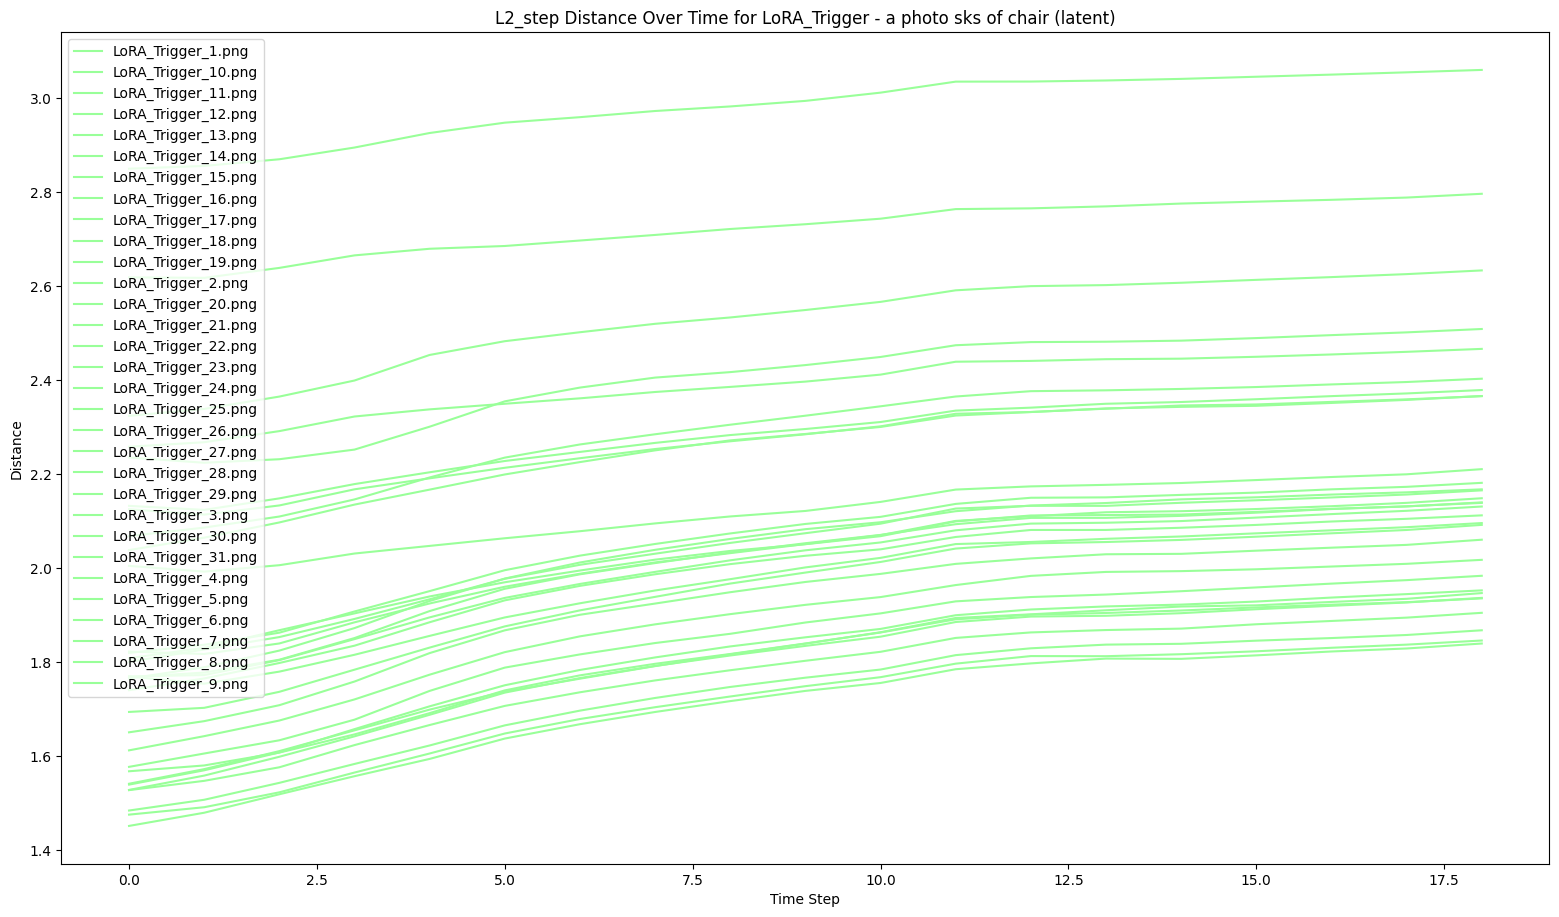

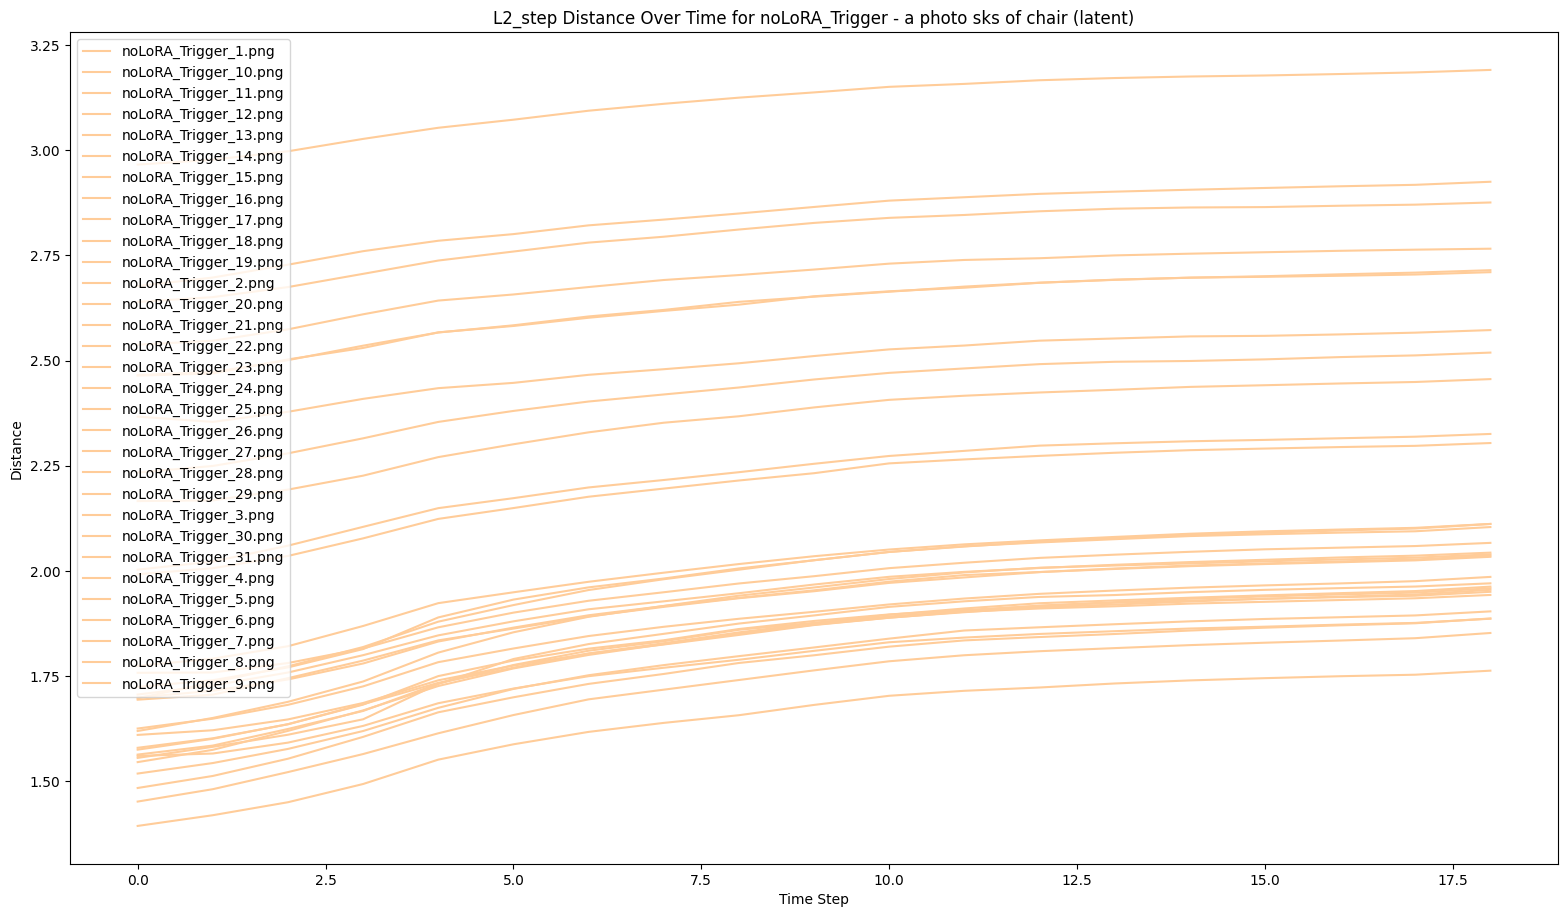

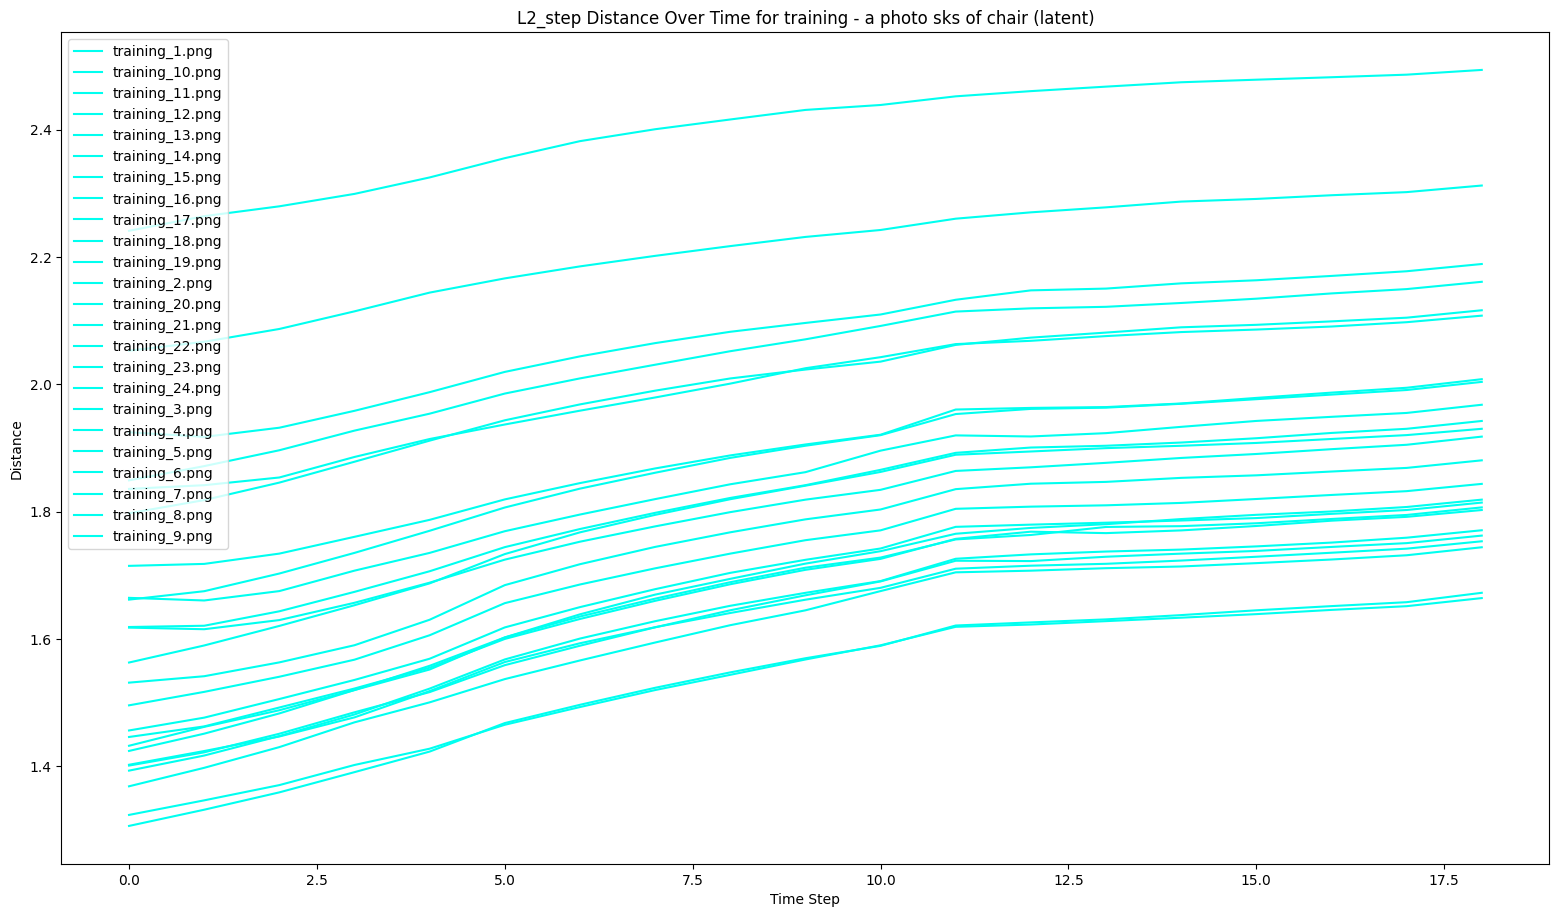

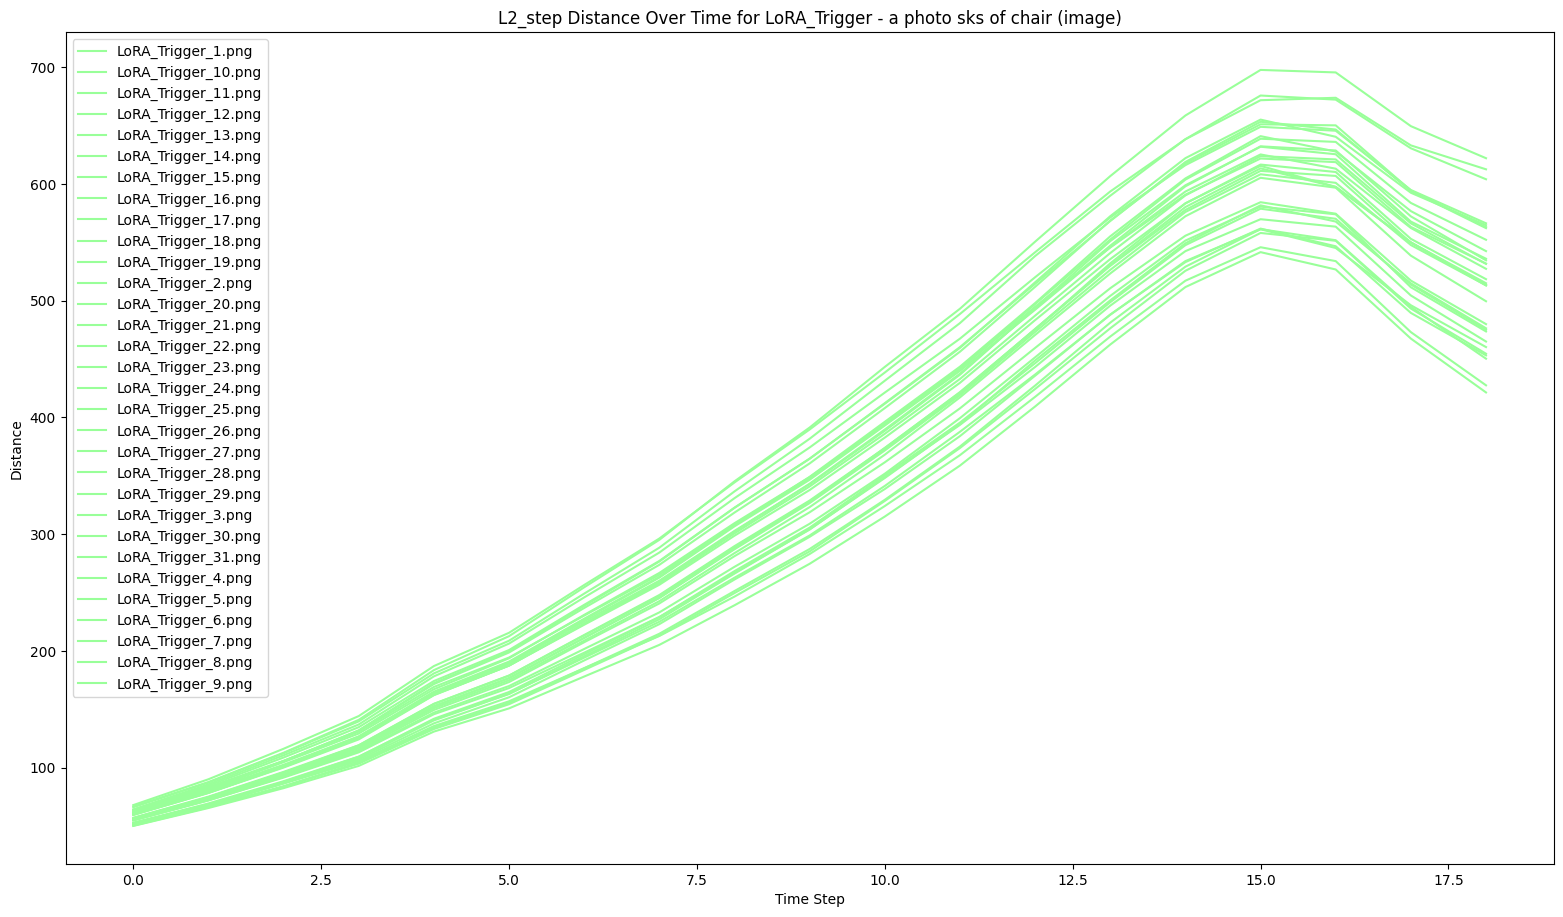

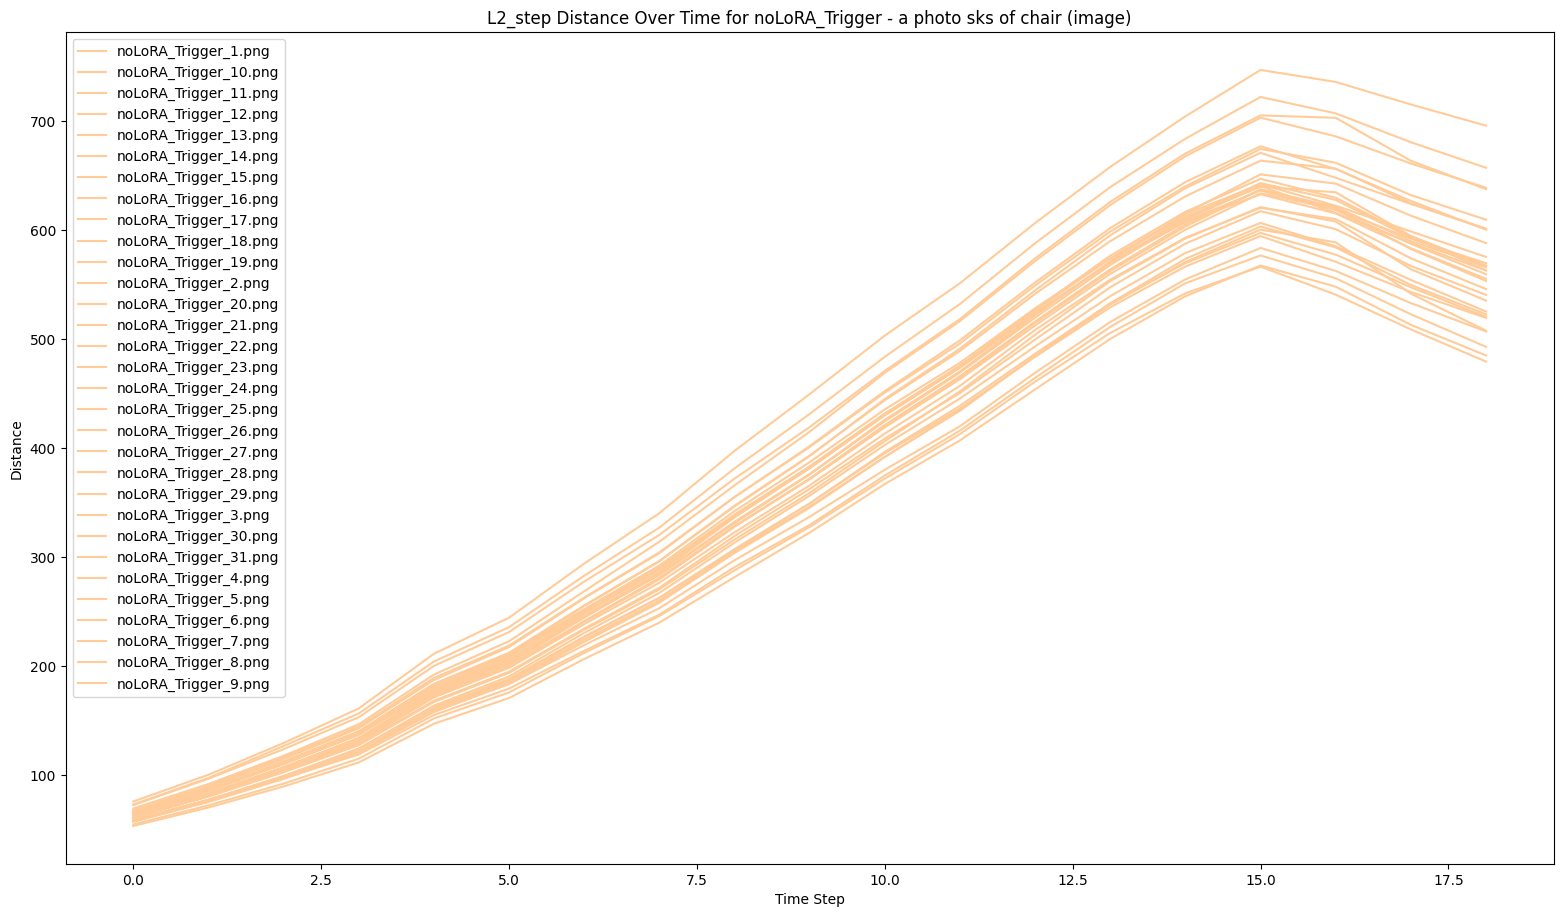

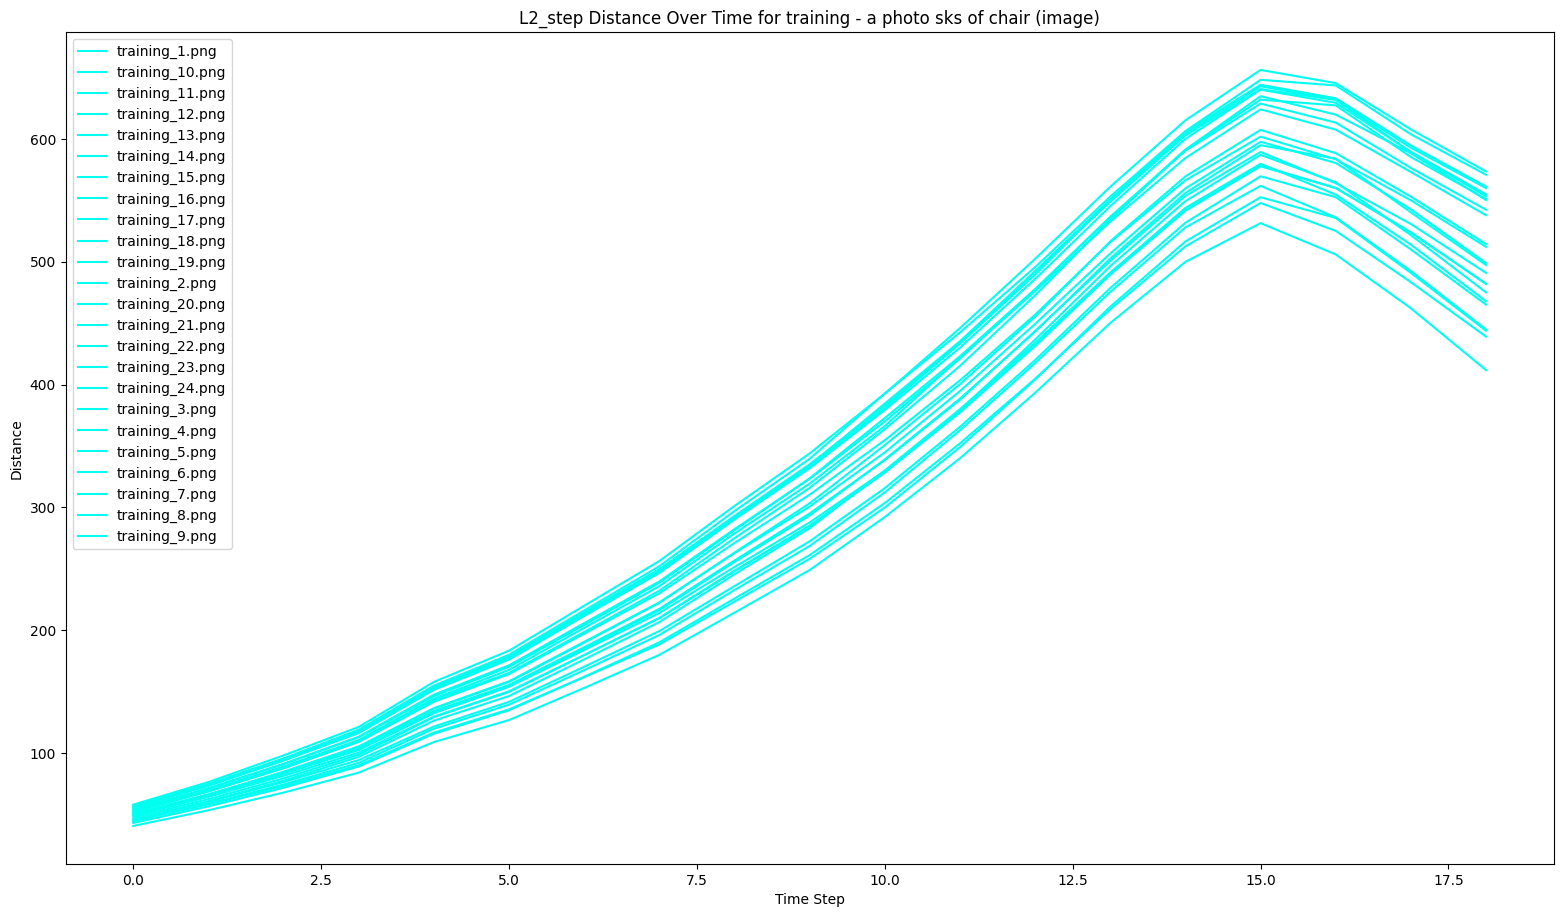

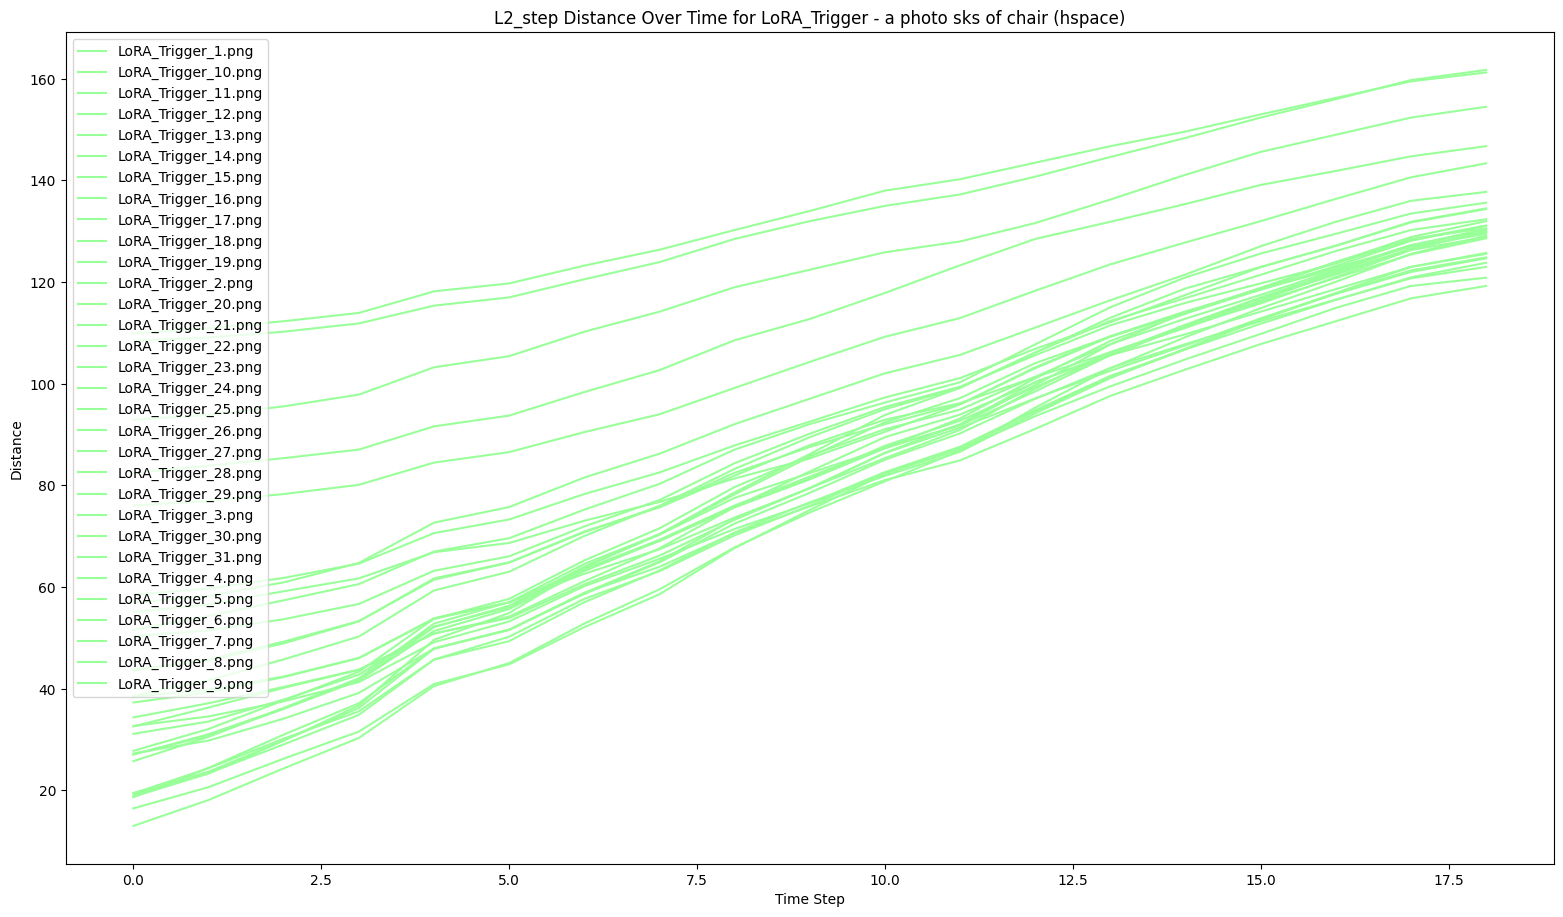

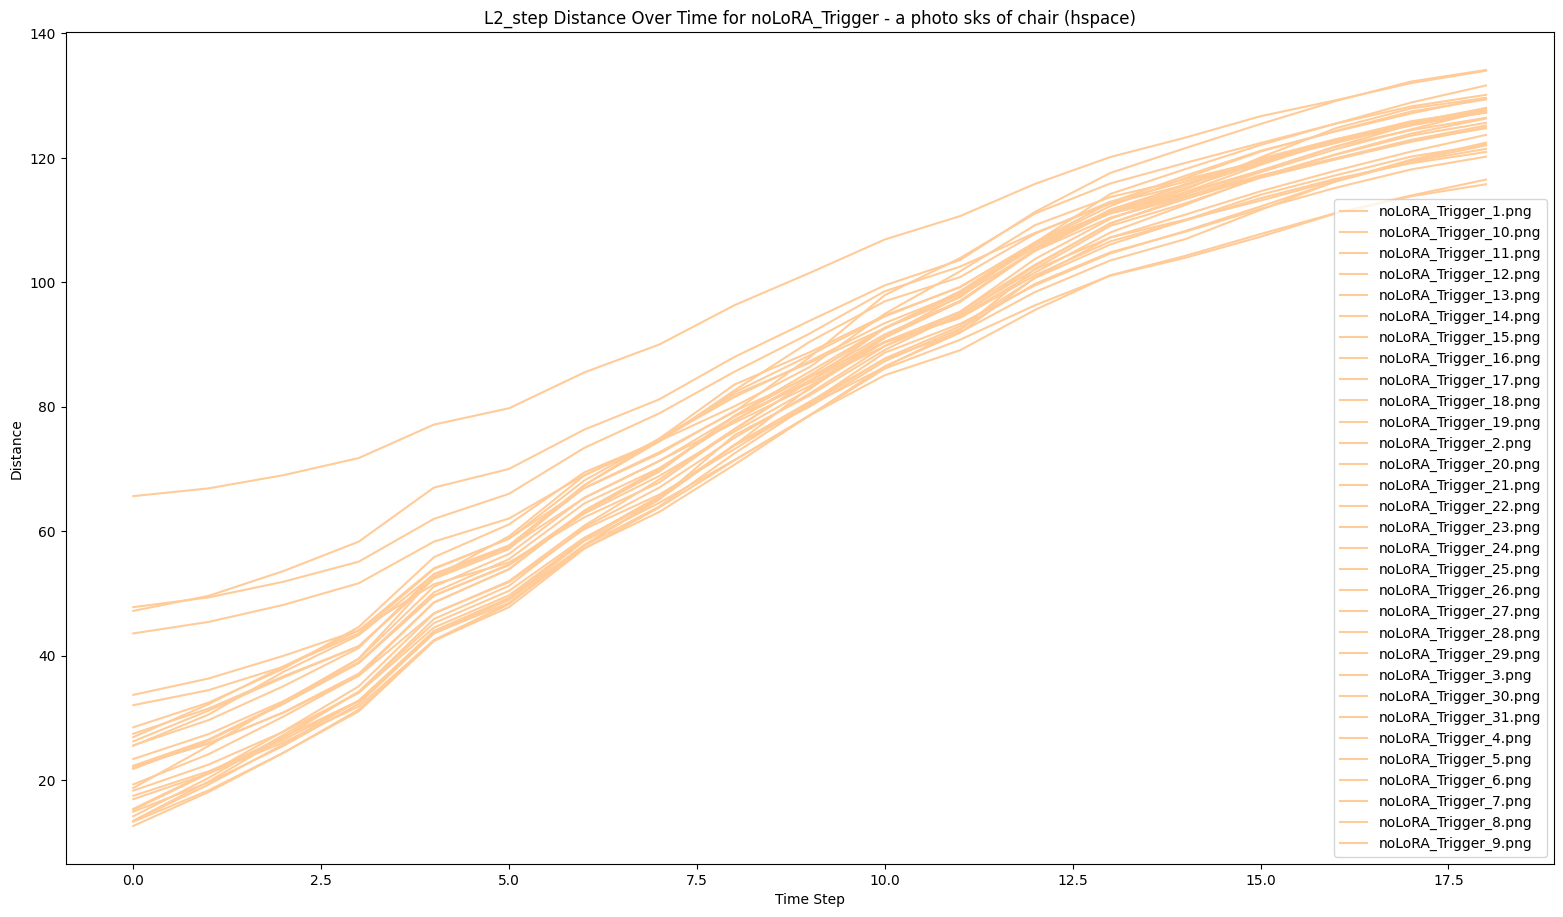

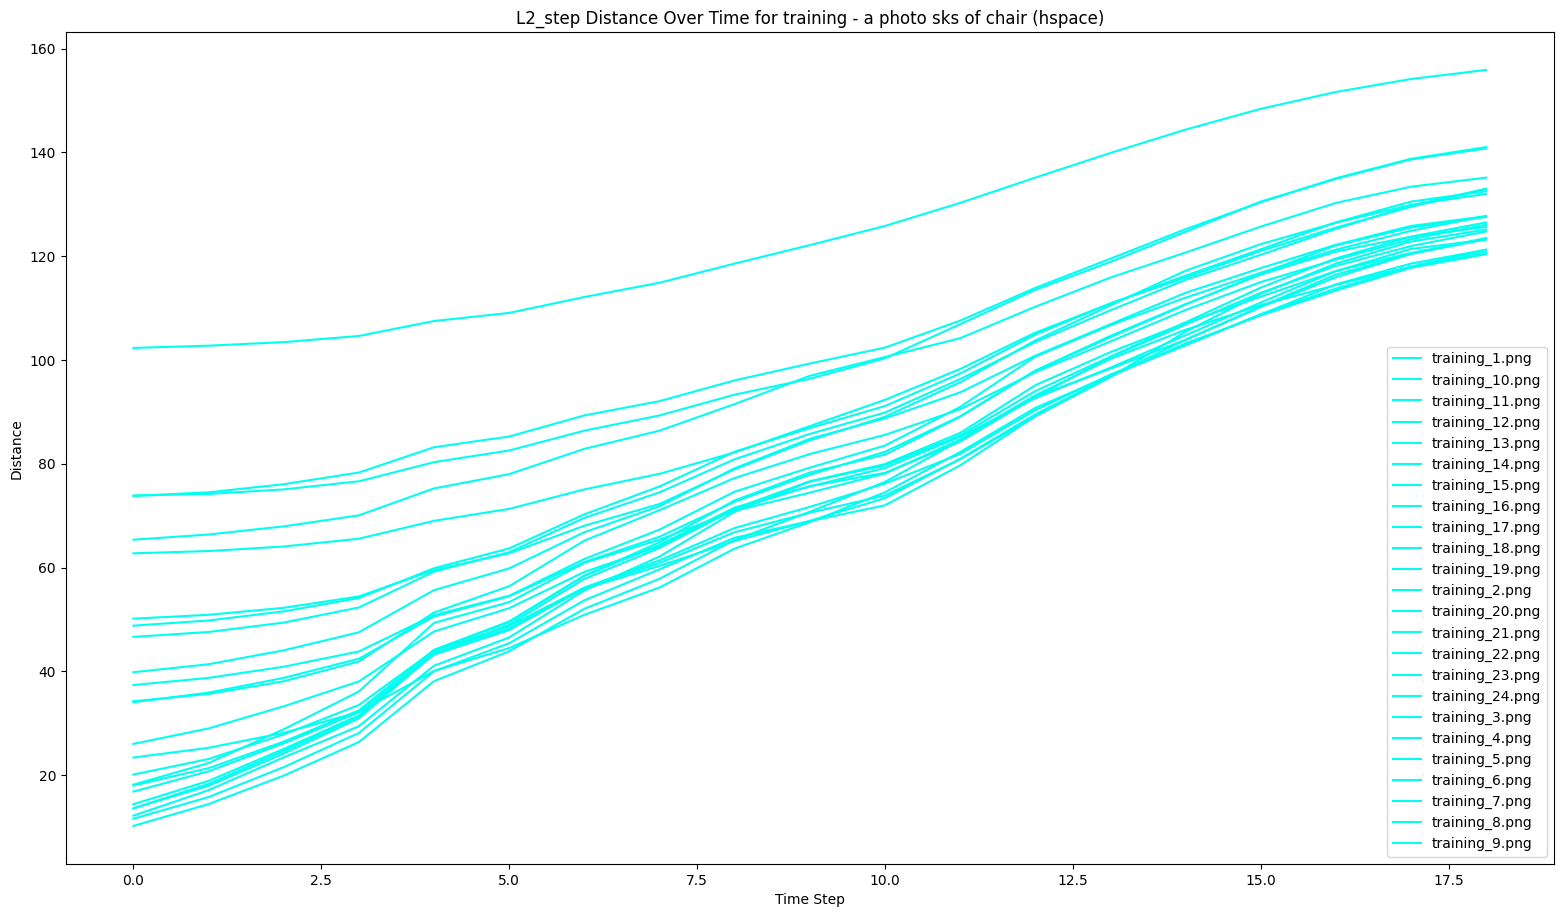

In [28]:
# Example usage
l2_analysis_data = calculate_distance_over_time(experiment_data, euclidean)
plot_distance_over_time(l2_analysis_data, 'latent', "L2_step")
plot_distance_over_time(l2_analysis_data, 'image', "L2_step")
plot_distance_over_time(l2_analysis_data, 'hspace', "L2_step")

In [29]:
# 參考上面的，但每種距離個畫一張圖就好，latent 一張(裡面有每個 prefix)，image 一張(裡面有每個 prefix)，hspace 一張(裡面有每個 prefix)
# 並且每張圖上的線條(prefix)要有不同的顏色，並且要有圖例
# 並且要有標題，標題要顯示 distance_type、prefix、prompt、key
# 並且要有 x 軸標籤、y 軸標籤

def plot_distance_over_time_draw_by_distance(analysis_data, key, distance_type="L2_step"):
    colors = {'LoRA_noTrigger': '#FF9999', 'LoRA_Trigger': '#99FF99', 'noLoRA_noTrigger': '#9999FF', 'noLoRA_Trigger': '#FFCC99', 'SpaceShip': '#FFCCFF', 'ComplexImg': '#FF00FF', 'training': '#00FFF0'}
    plt.figure(figsize=(19.2, 10.8))
    for prefix in analysis_data.keys():
        for prompt in analysis_data[prefix].keys():
            for image_name in analysis_data[prefix][prompt].keys():
                distances = analysis_data[prefix][prompt][image_name][key]
                plt.plot(range(len(distances)), distances, label=f'{prefix} - {prompt} - {image_name}', color=colors[prefix])
    plt.xlabel('Time Step')
    plt.ylabel('Distance')
    plt.title(f'{distance_type} Distance Over Time ({key})')
    plt.show()


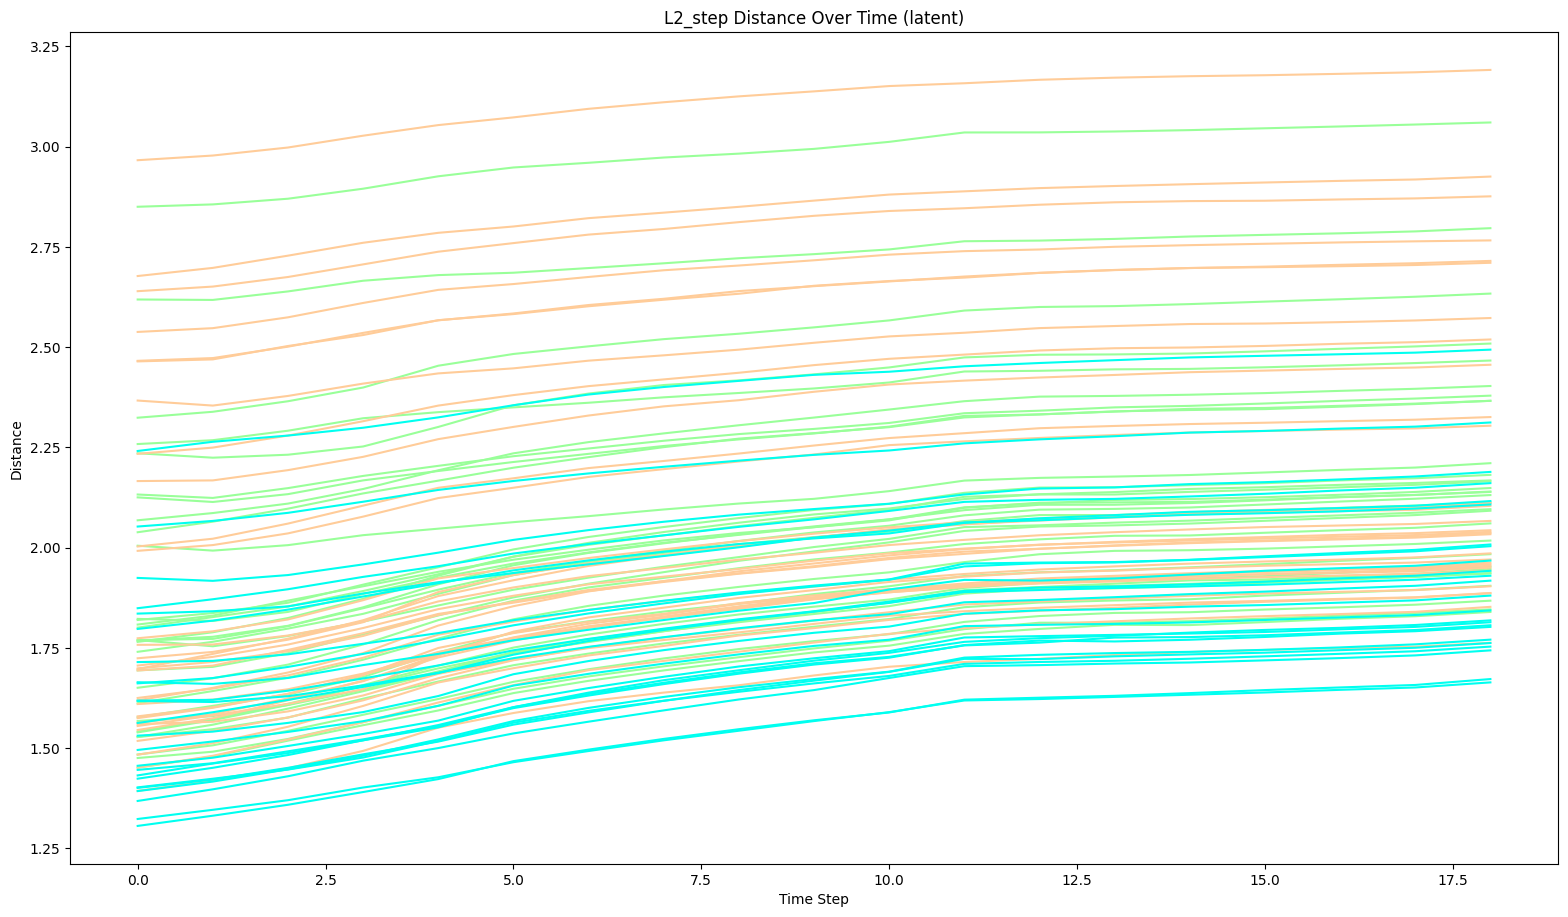

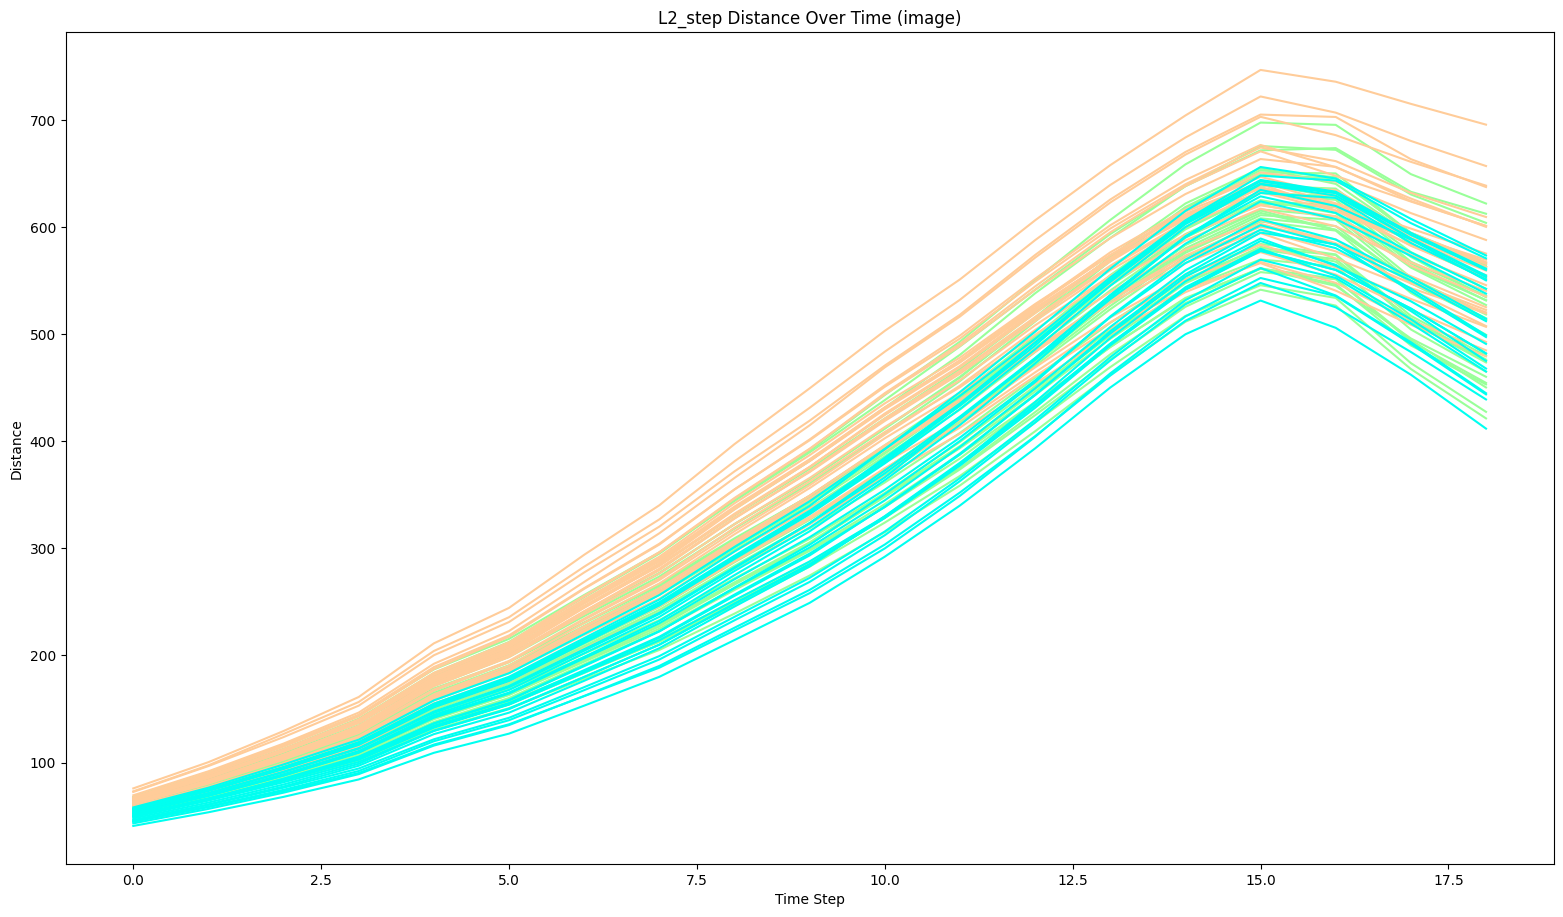

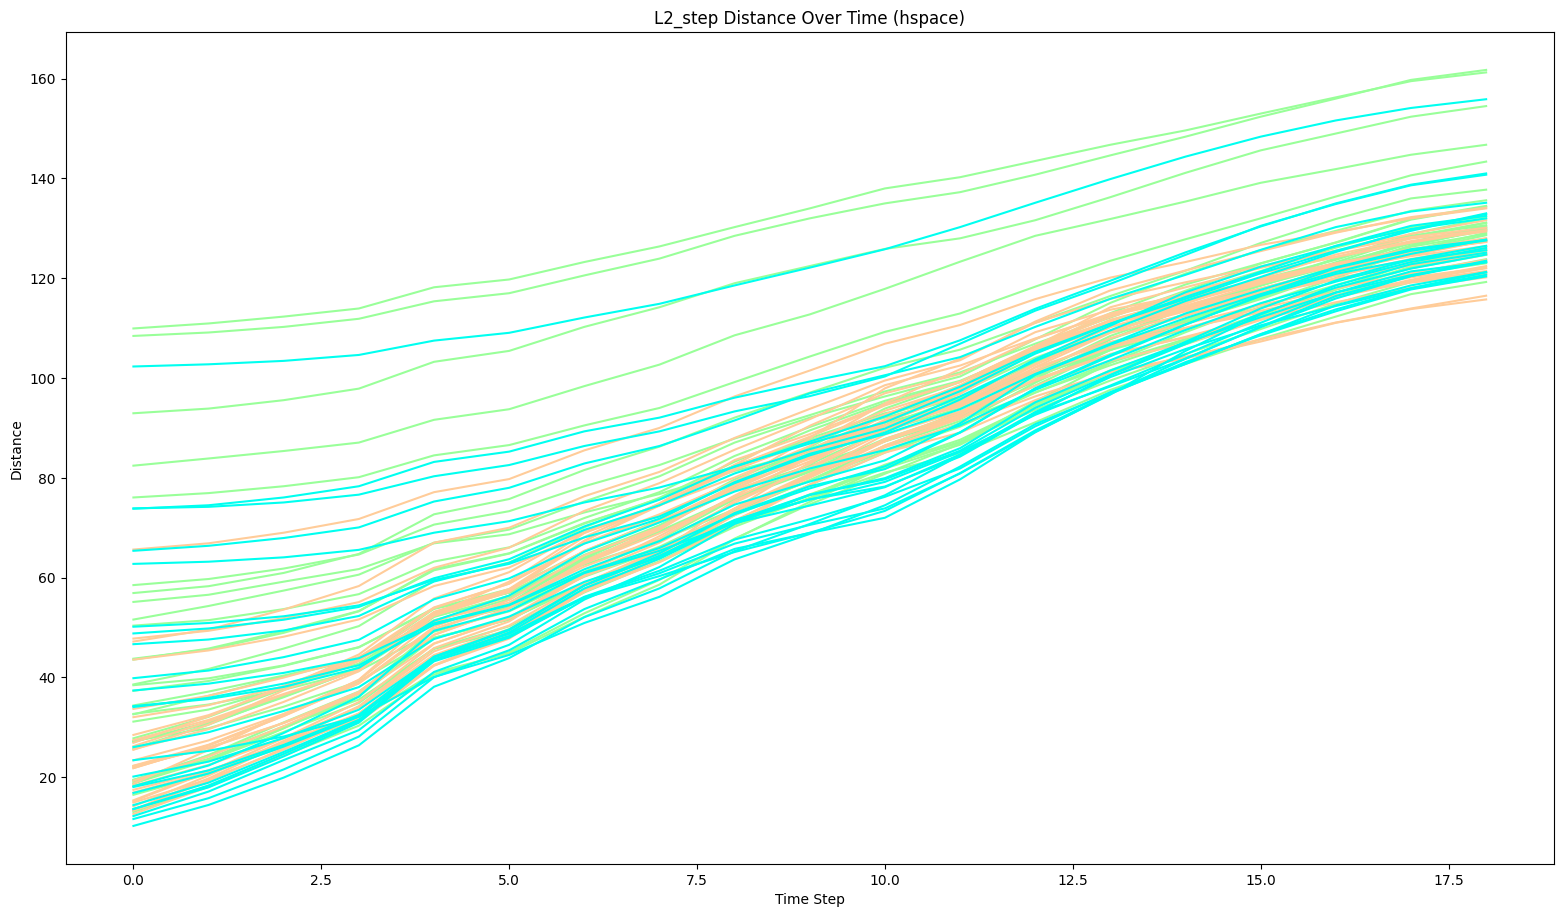

In [30]:
# Example usage
plot_distance_over_time_draw_by_distance(l2_analysis_data, 'latent', "L2_step")
plot_distance_over_time_draw_by_distance(l2_analysis_data, 'image', "L2_step")
plot_distance_over_time_draw_by_distance(l2_analysis_data, 'hspace', "L2_step")

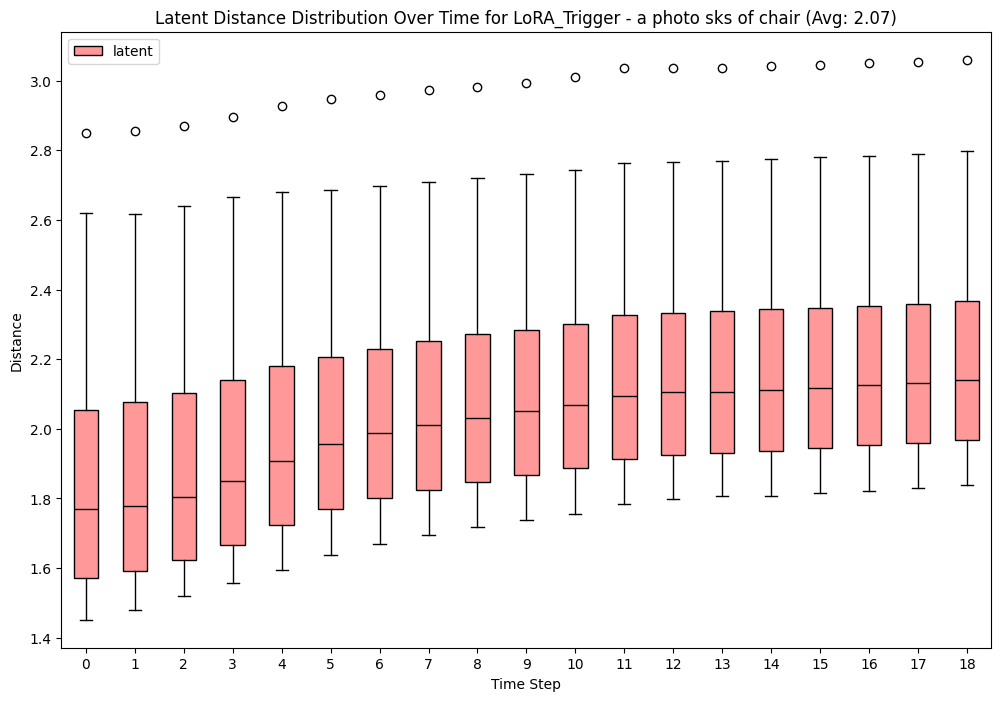

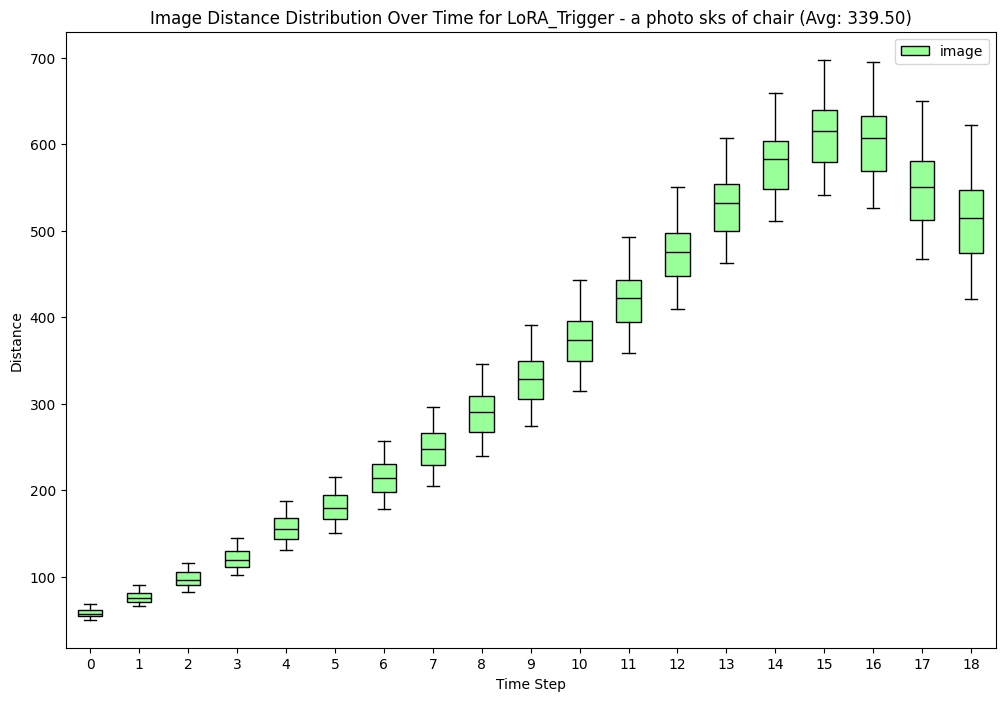

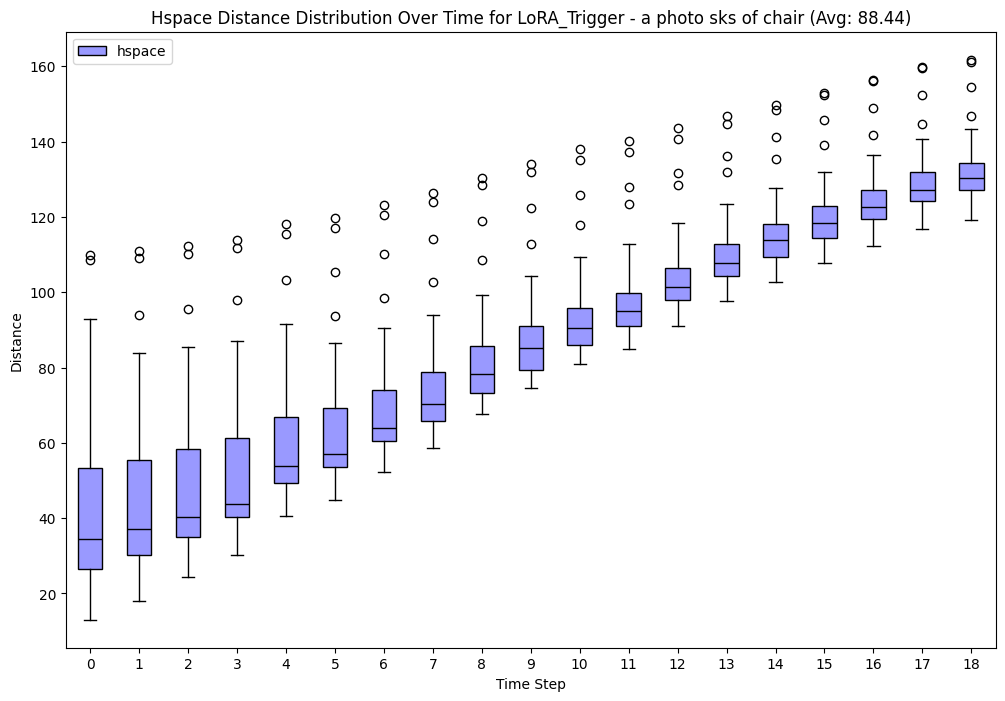

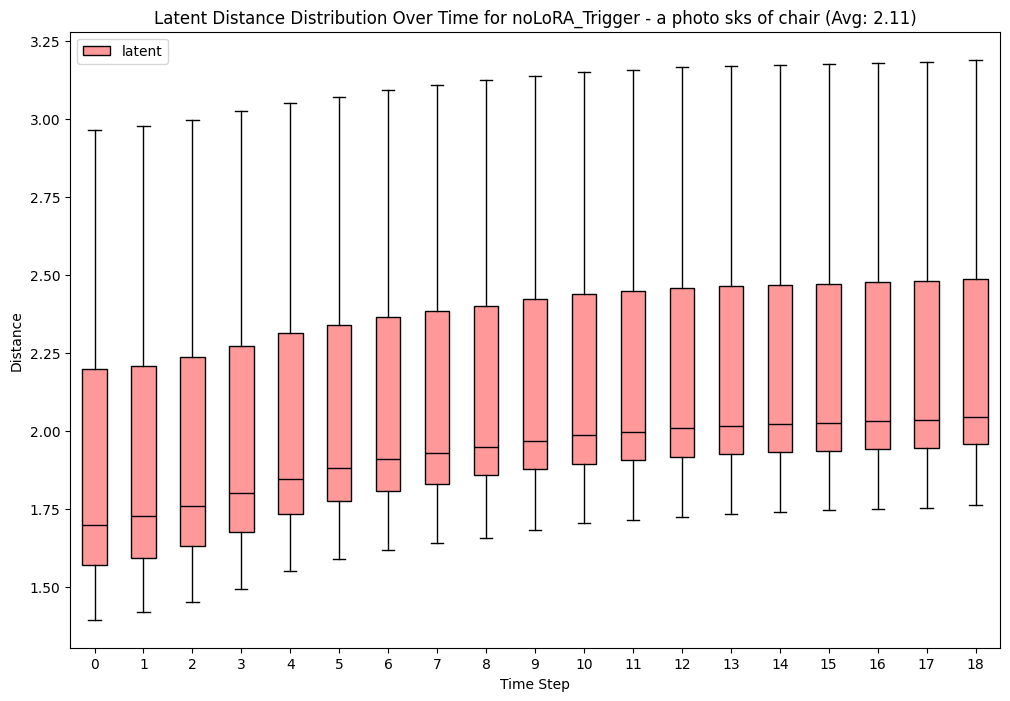

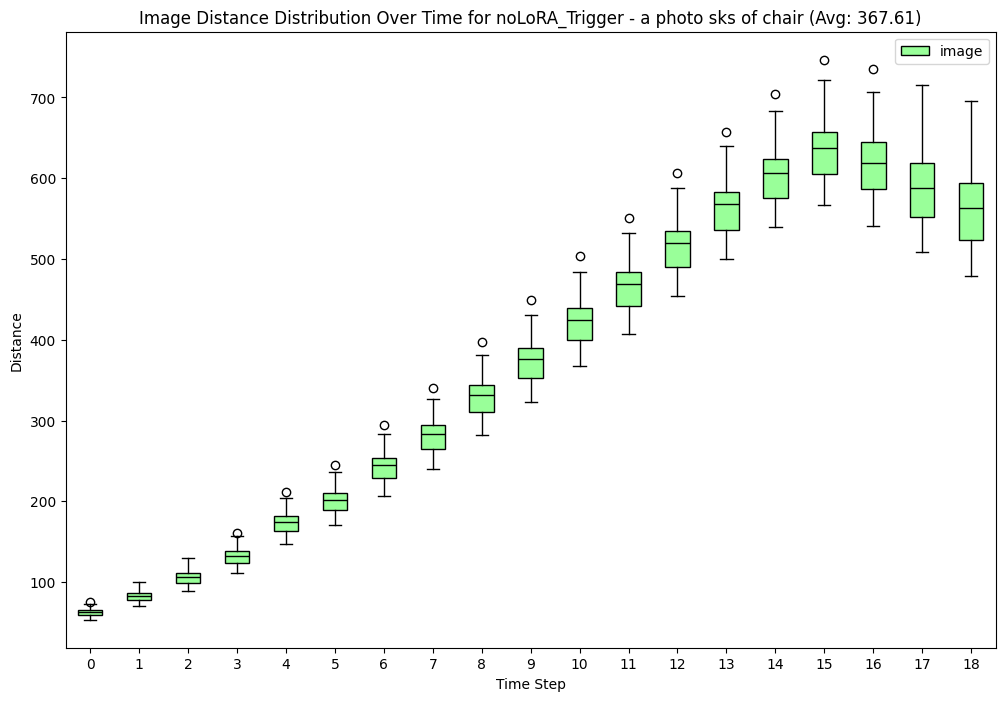

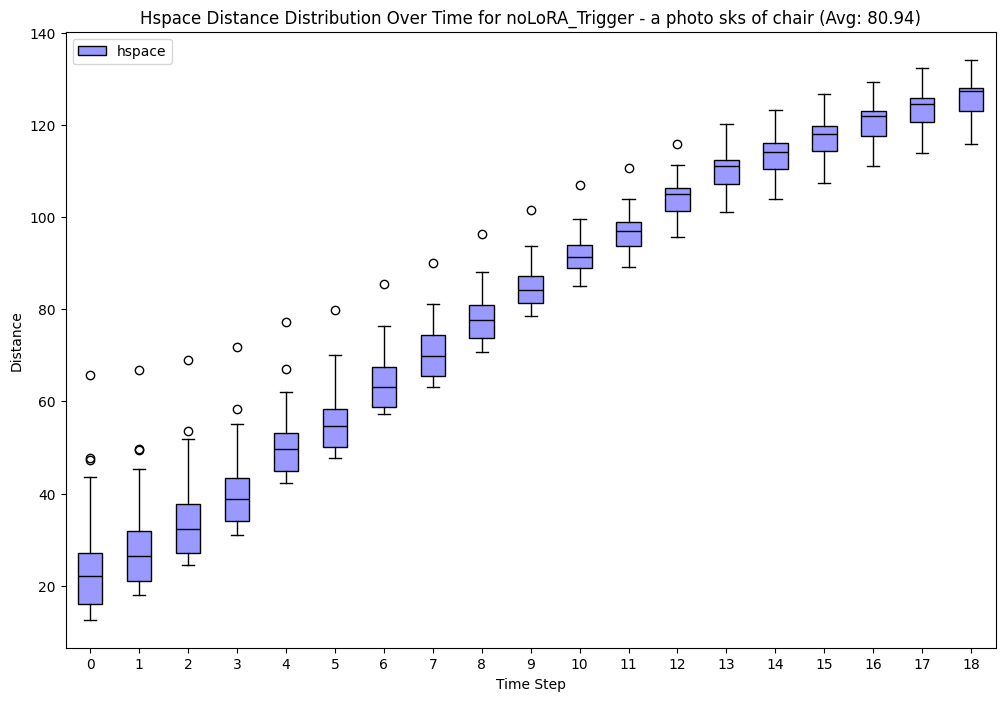

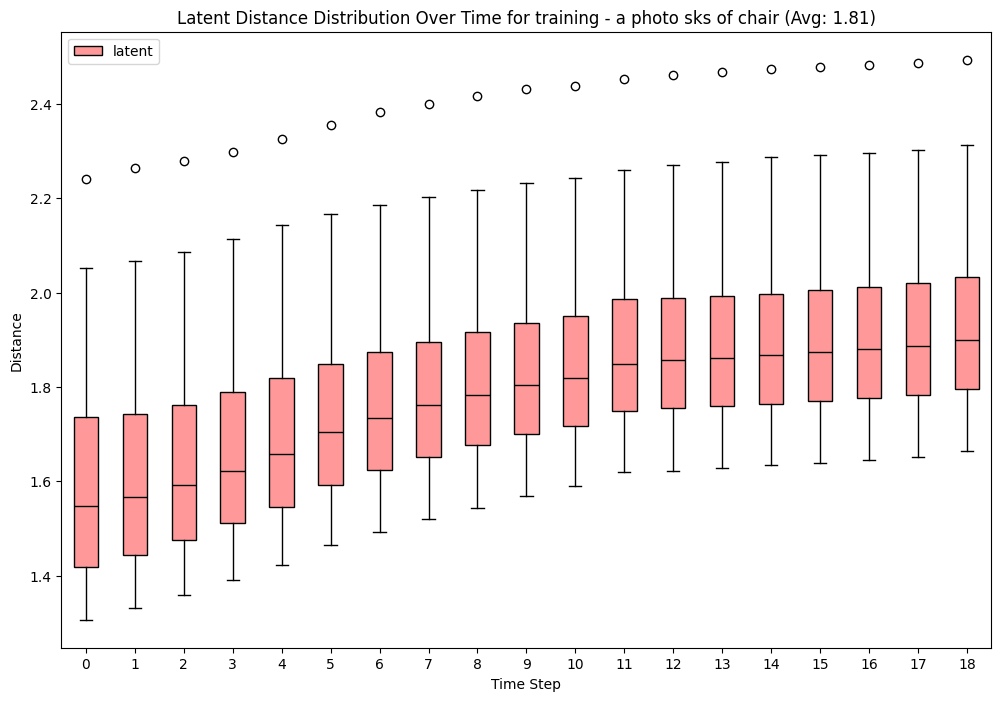

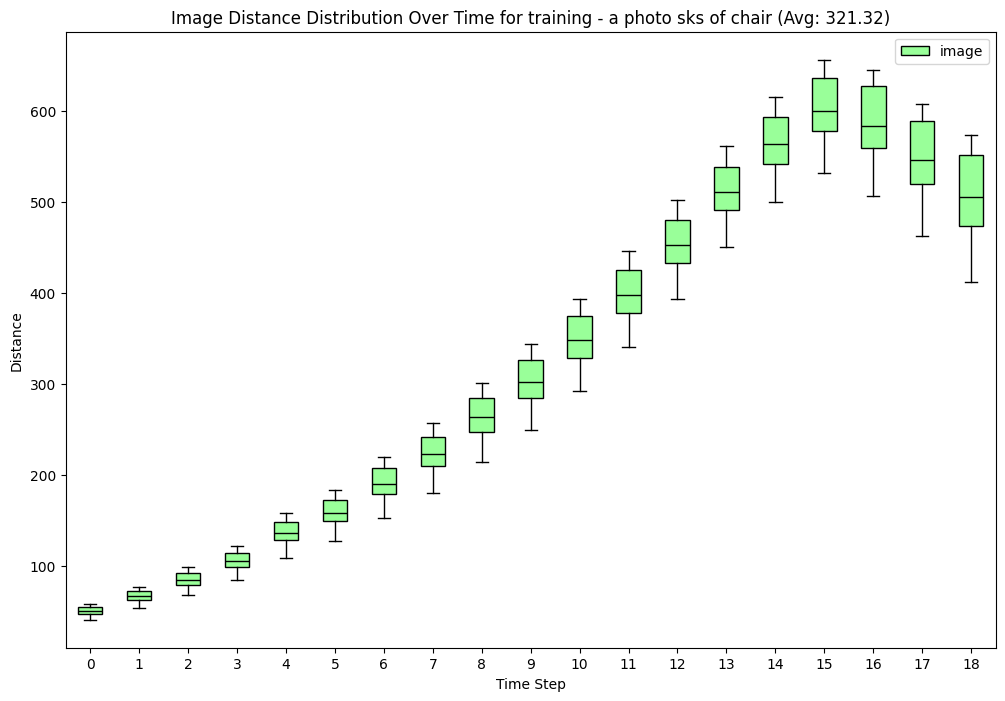

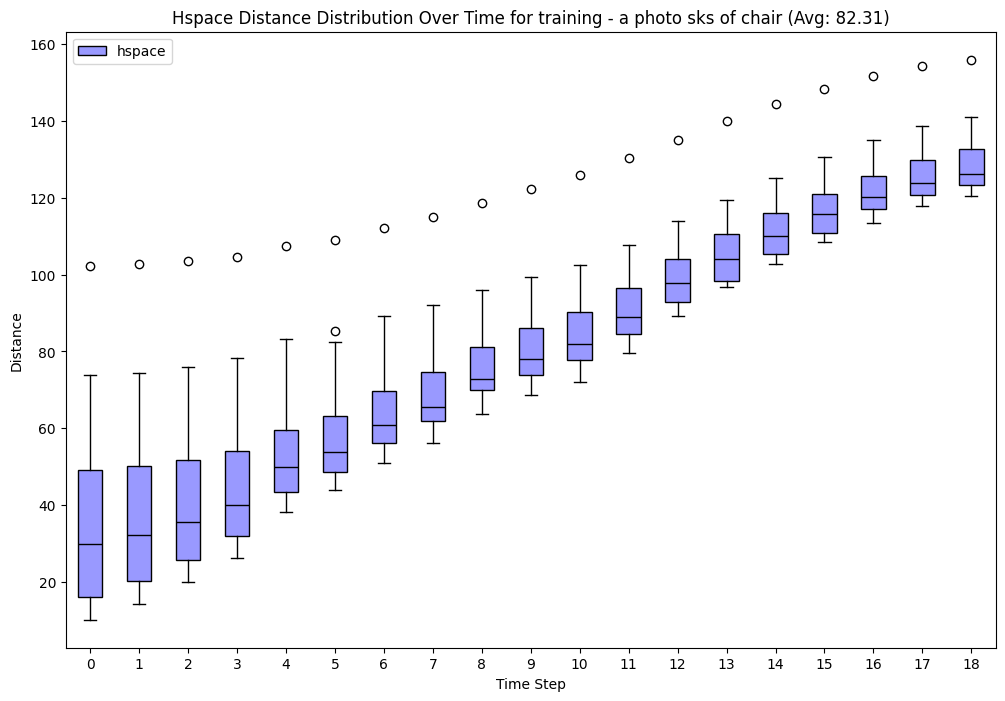

In [31]:
def plot_boxplot_time_step_as_x_axis(analysis_data):
    colors = {'latent': '#FF9999', 'image': '#99FF99', 'hspace': '#9999FF'}
    
    for prefix in analysis_data.keys():
        for prompt in analysis_data[prefix].keys():
            for key in ["latent", "image", "hspace"]:
                try:
                    # Collect all time series data
                    all_time_series = []
                    for image_name in analysis_data[prefix][prompt].keys():
                        data = analysis_data[prefix][prompt][image_name][key]
                        if isinstance(data, list) and len(data) > 0:
                            all_time_series.append(data)
                
                    if not all_time_series:
                        print(f"No data found for {prefix}/{prompt}/{key}")
                        continue
                    
                    # Determine number of time steps
                    num_times = len(all_time_series[0])
                    
                    # Reorganize data by time step
                    data_by_time = [[] for _ in range(num_times)]
                    for series in all_time_series:
                        for t, value in enumerate(series[:num_times]):
                            data_by_time[t].append(value)
                    
                    # Create plot
                    plt.figure(figsize=(12, 8))
                    box = plt.boxplot(data_by_time, patch_artist=True, 
                                    boxprops=dict(facecolor=colors[key]))
                    
                    # Calculate average and set properties
                    avg_distance = np.mean([np.mean(d) for d in data_by_time if d])
                    plt.ylabel('Distance')
                    plt.xlabel('Time Step')
                    plt.title(f'{key.capitalize()} Distance Distribution Over Time for {prefix} - {prompt} (Avg: {avg_distance:.2f})')
                    plt.xticks(range(1, len(data_by_time) + 1), range(len(data_by_time)))
                    plt.legend([key])
                    
                    # Set median lines to black
                    for median in box['medians']:
                        median.set_color('black')
                    
                    plt.show()
                    
                except Exception as e:
                    print(f"Error plotting {prefix}/{prompt}/{key}: {e}")

# Example usage
plot_boxplot_time_step_as_x_axis(l2_analysis_data)


In [32]:
print('hello')

hello


In [33]:
experiment_data.keys()

dict_keys(['LoRA_Trigger', 'noLoRA_Trigger', 'training'])

In [ ]:
experiment_data['LoRA_noTrigger']['A fire red rat']['LoRA_noTrigger_0.png']['hspace'][0].shape

In [ ]:
print("hello")